### CREATE DAILY INPUT FOR THE ML MODEL

Input:
- the measured runoff at the gauging station,
- the catchment area of the gauging station,
- the ERA5 datasets for Potential Evapotranspiration, Temperature and Precipitation.

Output:
    - a .csv file is saved in conda/daily_input folder.

In [1]:
from create_daily_csv import interpolate_df,readnetcdf_in_shp,xarray2df,check_data_gap,readnetcdf_in_shp_db,get_discharge_from_DB
import pandas as pd
import numpy as np
import os
import xarray as xr

In [2]:
import sys, importlib
importlib.reload(sys.modules['create_daily_csv'])

<module 'create_daily_csv' from 'C:\\Users\\mmazzolini\\OneDrive - Scientific Network South Tyrol\\Documents\\conda\\Runoff_prediction\\create_daily_csv.py'>

In [14]:
STAT_CODE = 'ADO_DSC_ITC1_0072'

In [15]:
runoff=get_discharge_from_DB(STAT_CODE)

shp_catchment_path = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\qgis\final_delineation'
shp_catchment_fileName =shp_catchment_path + r'\DONAU_Korneuburg.shp'

# Runoff
catchment_name = 'KORONEMBURG_DONAU.txt'
fileName = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\data_discharge\\' + catchment_name
#runoff = pd.read_csv(fileName, index_col=2, parse_dates=True)
runoff = pd.read_csv(fileName, delimiter=',', index_col=1
                     , parse_dates=True)

runoff=runoff.drop(columns=['id_station','quality'])

runoff.index = pd.to_datetime(runoff.Datum, format='%d.%m.%Y')

runoff['discharge_m3_s']=runoff['pretok (m3/s)']

#runoff=runoff.drop(columns='pretok (m3/s)')
runoff=runoff.drop(columns=['Datum','temp. vode (°C)','transport suspendiranega materiala (kg/s)','vsebnost suspendiranega materiala (g/m3)'])

In [20]:
runoff.index.day_of_year

Int64Index([  7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
            ...
            356, 357, 358, 359, 360, 361, 362, 363, 364, 365],
           dtype='int64', name='date', length=6238)

In [16]:
check_data_gap(runoff)
#runoff = runoff.reindex(pd.date_range(runoff.index.min() - pd.DateOffset(years=1), runoff.index.max()), fill_value=np.nan)
runoff = runoff.rename(columns={'discharge_m3_s': 'Q'})
#runoff.drop(['id_station','quality'],axis=1,inplace=True)

Date start: 2002-01-07, date end: 2019-12-31
Missing dates: 2002-06-09, 2002-06-10, 2002-06-11, 2002-06-12, 2002-06-13, 2002-06-14, 2002-06-15, 2002-06-16, 2002-06-17, 2002-06-18, 2002-06-19, 2002-06-20, 2002-06-21, 2002-06-22, 2002-06-23, 2002-06-24, 2002-06-25, 2002-06-26, 2002-06-27, 2002-06-28, 2002-06-29, 2002-06-30, 2002-07-01, 2002-07-02, 2002-07-03, 2002-07-04, 2002-07-05, 2002-07-06, 2002-07-07, 2002-07-08, 2002-07-09, 2002-07-10, 2002-07-11, 2002-07-12, 2002-07-13, 2002-07-14, 2002-07-15, 2002-07-16, 2002-07-17, 2002-07-18, 2002-07-19, 2002-07-20, 2002-07-21, 2002-07-22, 2002-07-23, 2002-07-24, 2002-07-25, 2002-07-26, 2002-07-27, 2002-07-28, 2002-07-29, 2002-07-30, 2002-07-31, 2002-08-01, 2002-08-02, 2002-08-03, 2002-08-04, 2002-08-05, 2002-08-06, 2002-08-07, 2002-08-08, 2002-08-09, 2002-08-10, 2002-08-11, 2002-08-12, 2002-08-13, 2002-08-14, 2002-08-15, 2002-08-16, 2002-08-17, 2002-08-18, 2002-08-19, 2002-08-20, 2002-08-21, 2002-08-22, 2002-08-23, 2002-08-24, 2002-08-25, 2002

n of pixels36
Date start: 1979-01-01, date end: 2018-12-31
No missing dates


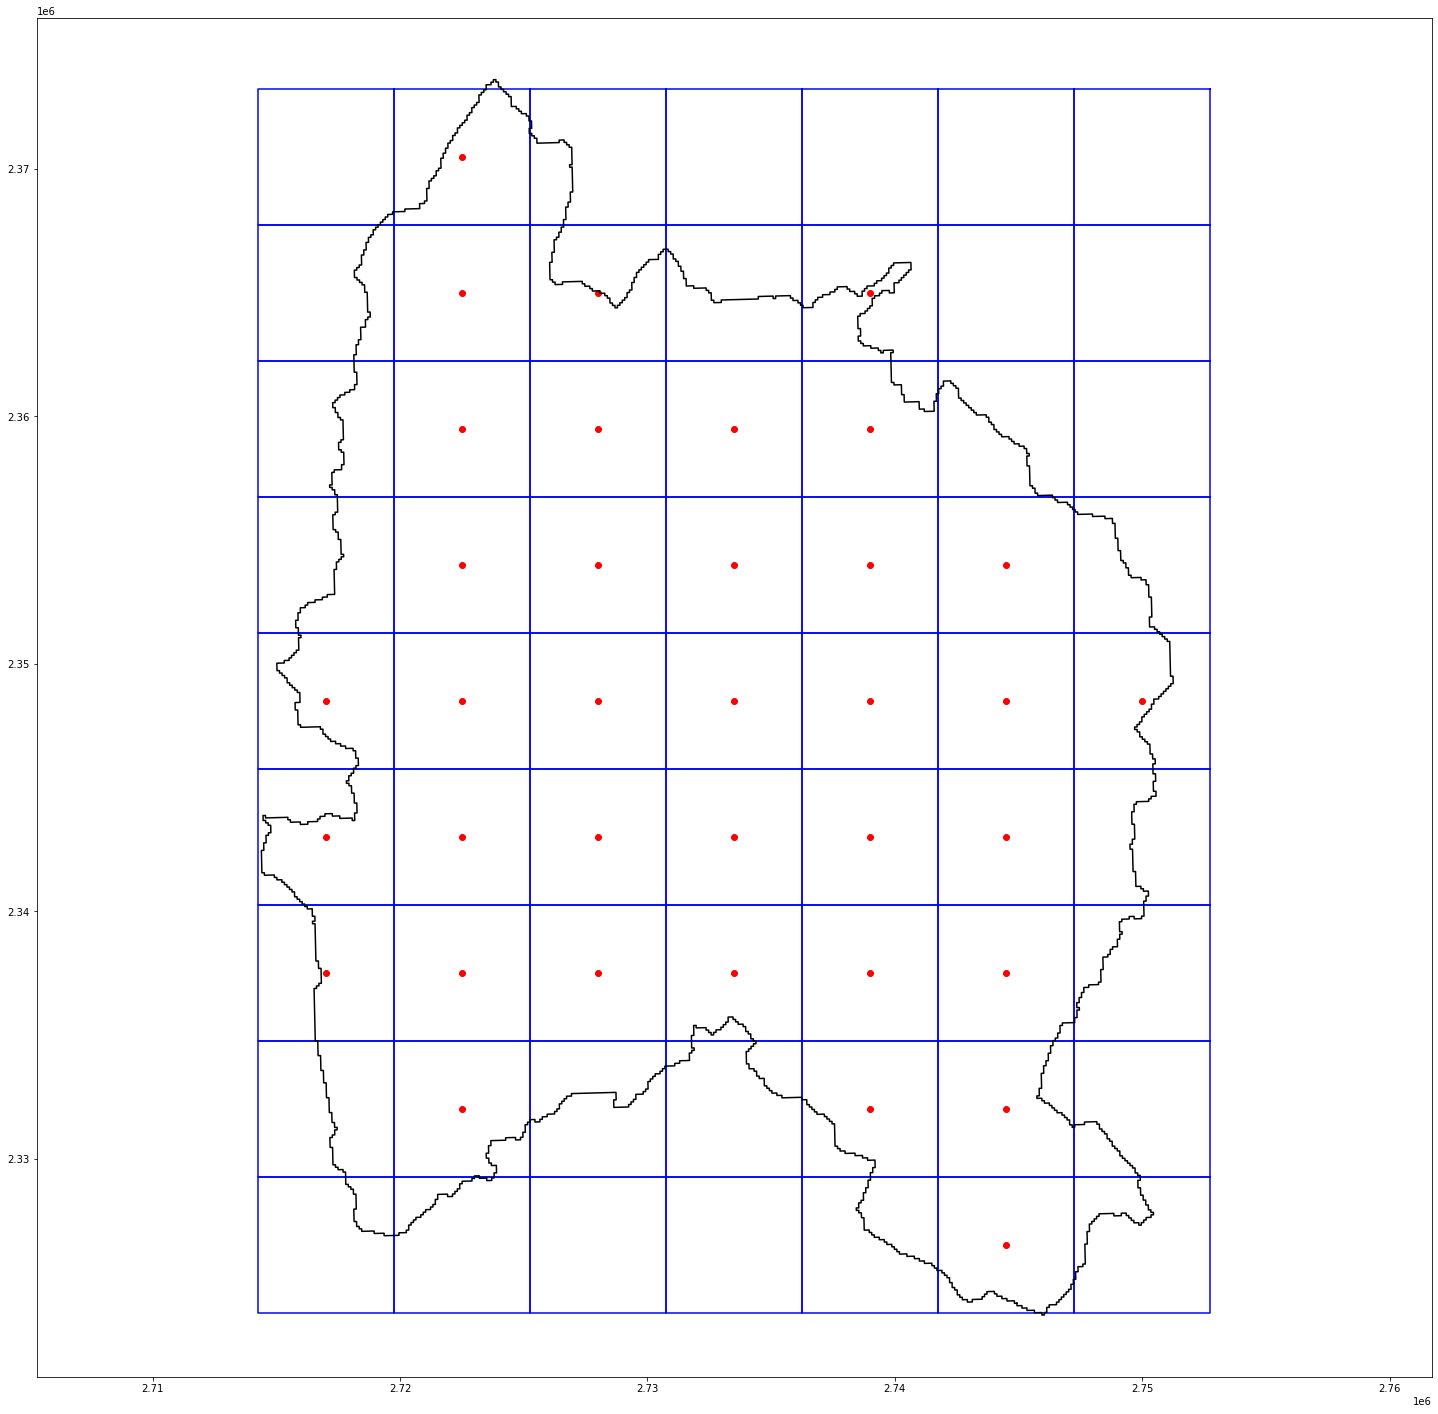

In [52]:
# ERA5 temperature

era5_fileName=  r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\2m_temperature-19790101_20181231-eusalp-qm_era5.nc'

t2m = readnetcdf_in_shp_db(era5_fileName,STAT_CODE ,plot=True,res=5500)['t2m']

t2m = xarray2df(t2m.resample(time='1d').mean(), 'T','t2m')

check_data_gap(t2m)

nc_fileName=era5_fileName
res=5500
plot=True

import psycopg2
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import psycopg2
import shapely.wkb as wkb
from geopandas import GeoSeries

    # Open the netcdf file
    ds = xr.open_dataset(nc_fileName)
    
    # Open the shape file and reproject it to the MESCAN-Surfex grid (unit=meters)

    conn = psycopg2.connect(host="10.8.244.31",
                       database="climate_data",
                       user="ado_user",
                       password="hydro#ado",
                       port=5432)
    cur = conn.cursor()
    
    # get the metadata
    query = f"""
            SELECT "geom" FROM "hydrology"."ado_basins_CCM2" WHERE "id_station" = '{STAT_CODE}'    
            """
    df = pd.read_sql_query(query, conn)
    
    shp=GeoSeries(wkb.loads(df.geom[0], hex=True))
    shp=shp.set_crs("EPSG:4326")
    shp_reproj = shp.to_crs('+proj=lcc +lat_1=50 +lat_2=50 +lat_0=50 +lon_0=8 +x_0=2937018.5829291 +y_0=2937031.41074803 +a=6371229 +b=6371229')
    
    # Crop ds with the shapefile bounding box (bb)
    bb = shp_reproj.bounds.iloc[0]
    ds = ds.sel(x=slice(bb['minx']-res, bb['maxx']+res), 
                y=slice(bb['miny']-res, bb['maxy']+res))
    
    

shp[0]

    #0000 Mask all the points in ds where the grid box do not intersect or is in the shapefile
    for i in ds.x.values:
        for j in ds.y.values:
            gridbox = Point(i, j)#.buffer(res/2, cap_style=3)
            if not (gridbox.intersects(shp_reproj.loc[0])):
                for k in ds.data_vars.keys():
                    if not (k =='Lambert_Conformal'):
                        ds[k].loc[dict(x=i, y=j)] = np.nan
    ds = ds.dropna(dim='x', how='all')
    ds = ds.dropna(dim='y', how='all')
    counter=0                    
    # Plot the era5 gridbox and the shapefile if plot=True
    if plot:
        plt.figure(figsize=(25,25))
        for x in ds.x.values:
            for y in ds.y.values:
                gridbox = Point(x, y).buffer(res / 2, cap_style=3)
                gridbox_x, gridbox_y = gridbox.exterior.xy
                plt.plot(gridbox_x, gridbox_y, color='blue')
                for k in ds.data_vars.keys():
                    if (k !='Lambert_Conformal'):
                        if not(ds[k].loc[dict(x=x, y=y)].isnull().all()):
                            plt.plot(x, y, marker='o', color='red')
                            counter=counter+1
        
        coords=[p.exterior.xy for p in shp_reproj.loc[0]]
        shp_x=coords[0][0]
        shp_y=coords[0][1]
        #shp_x, shp_y = *shp_reproj.loc[0].exterior.xy
        plt.plot(shp_x, shp_y, color='black')
        plt.axis('equal')                        
    print(f'n of pixels{counter}')  

In [53]:
t2m

,Tx5y0,Tx1y1,Tx4y1,Tx5y1,Tx0y2,Tx1y2,Tx2y2,Tx3y2,Tx4y2,Tx5y2,...,Tx4y5,Tx5y5,Tx1y6,Tx2y6,Tx3y6,Tx4y6,Tx1y7,Tx2y7,Tx4y7,Tx1y8
time,,,,,,,,,,,,,,,,,,,,,
1979-01-01,268.184064,268.571353,268.371203,267.861758,269.293647,268.479409,268.182577,268.159013,268.296139,267.774906,...,266.526258,266.169463,271.045055,269.922102,267.419943,266.204906,269.095541,268.351475,265.655428,267.467133
1979-01-02,262.145410,263.509280,262.648583,261.899174,262.980169,263.136230,262.911701,262.870769,262.825648,261.331035,...,260.836215,258.749729,266.130703,265.243198,262.929156,260.095657,264.001198,263.625652,259.911254,262.256879
1979-01-03,266.327720,266.301979,266.346589,266.110603,267.190874,266.310472,266.351181,266.263558,266.070565,265.713068,...,264.844002,263.810413,268.896488,267.957334,265.783288,263.903002,266.491510,266.118184,263.404730,265.531248
1979-01-04,269.496087,270.050011,269.936710,269.480072,270.885682,270.092108,270.142353,270.069025,270.033251,269.496609,...,269.006839,268.331747,272.866532,271.771810,269.568383,268.485499,271.003366,270.288217,267.995068,269.566525
1979-01-05,268.540576,269.585347,269.434125,268.877342,270.525919,269.703273,269.718121,269.612978,269.626448,269.016271,...,268.891937,268.178443,273.138465,271.928517,269.765640,268.491183,271.482834,270.716306,268.240798,270.334588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,272.689141,272.274086,273.102205,272.925049,272.640268,272.360640,272.640093,273.034188,273.338010,273.191550,...,272.372534,271.947828,274.900376,274.261017,272.746670,271.746870,273.140802,273.021161,271.613806,272.034129
2018-12-28,273.124676,273.092396,273.505112,273.435473,273.654620,273.196223,273.492303,273.681957,273.797810,273.571249,...,272.811312,272.398628,275.768850,275.114318,273.342115,272.299327,274.000306,273.822467,272.186604,272.735839
2018-12-29,273.535074,273.275915,273.647250,273.632786,273.794548,273.168197,273.376722,273.558703,273.753852,273.618697,...,272.661601,272.132172,275.572088,274.716069,272.979797,272.096756,273.873718,273.426462,271.831062,272.641393


n of pixels36
Date start: 1979-01-01, date end: 2018-12-31
No missing dates


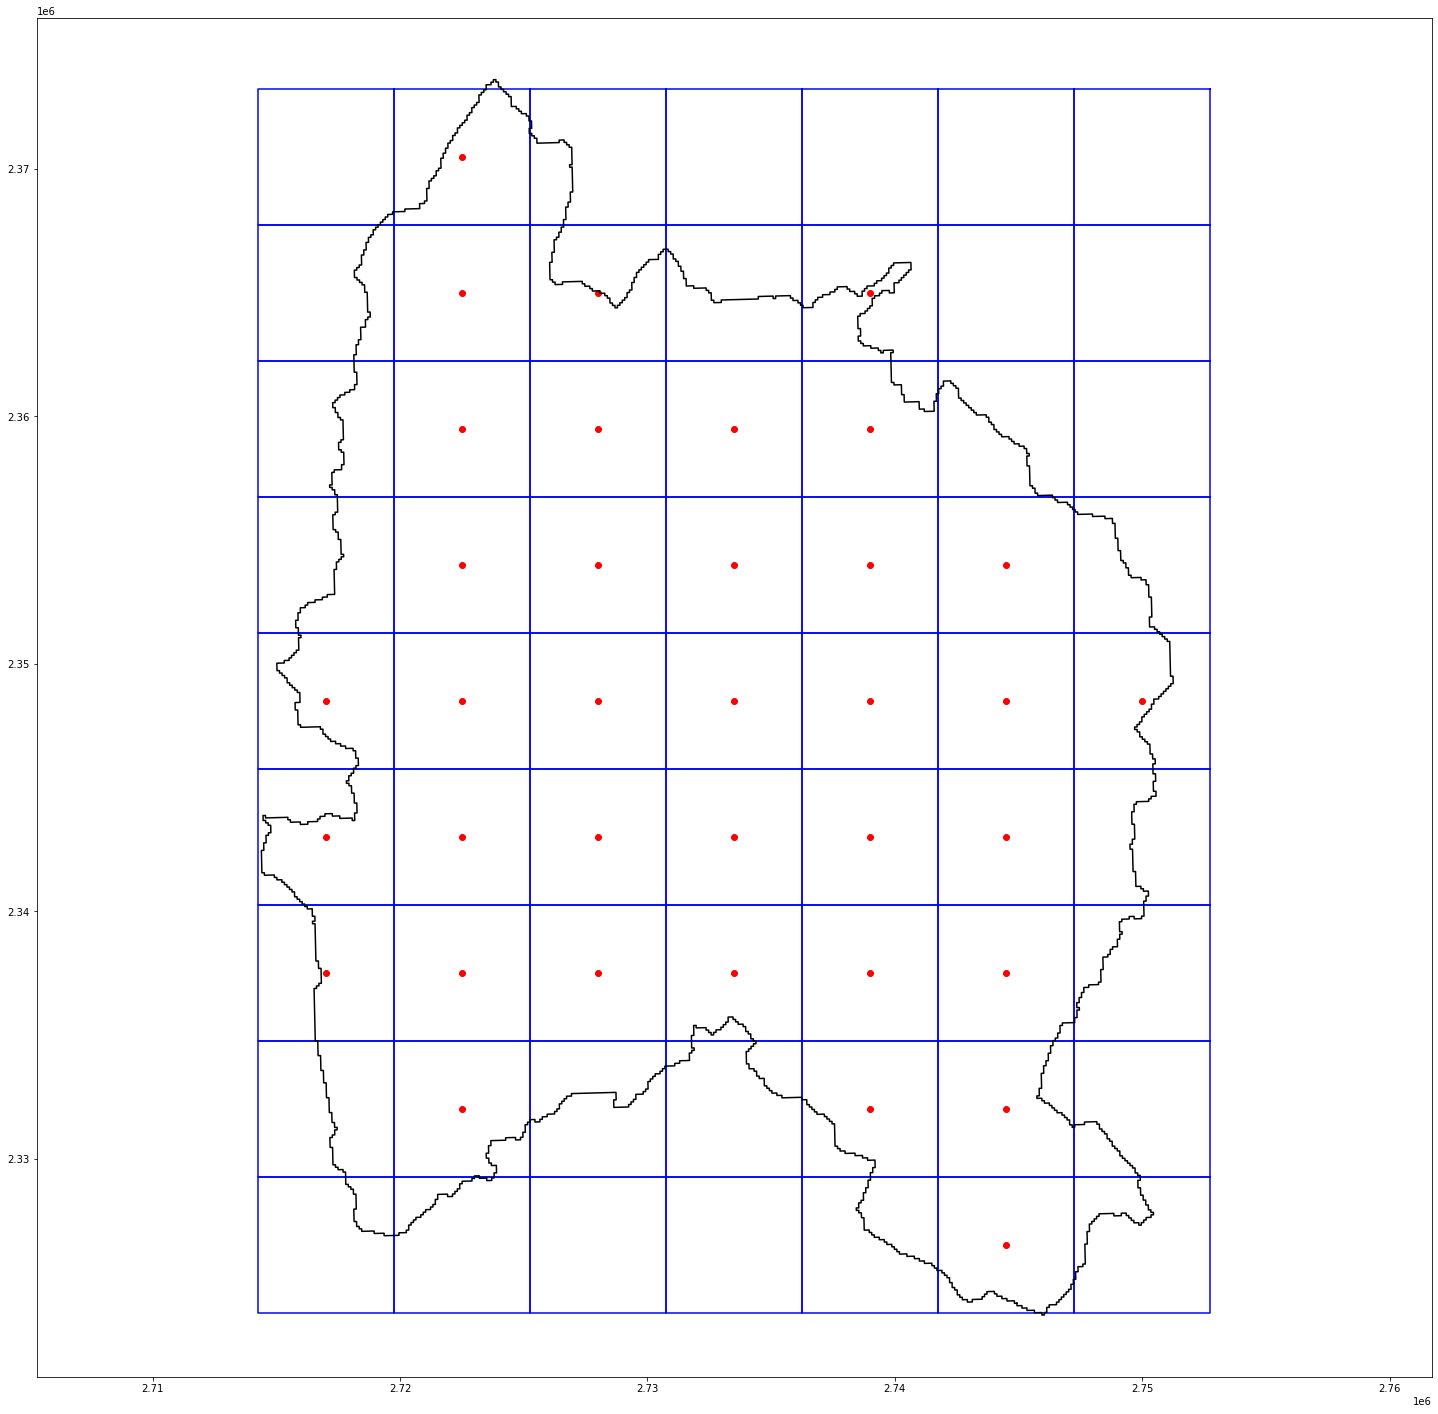

In [54]:
# ERA5 evapotranspiration
era5_fileName = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\potential_evapotranspiration-19790101_20181231-eusalp-qm_era5.nc'

pet = readnetcdf_in_shp_db(era5_fileName, STAT_CODE,plot=True)['pet']
pet = xarray2df(pet.resample(time='1d').sum(skipna=False), 'E','pet')

check_data_gap(pet)

n of pixels36
Date start: 1979-01-01, date end: 2018-12-31
No missing dates


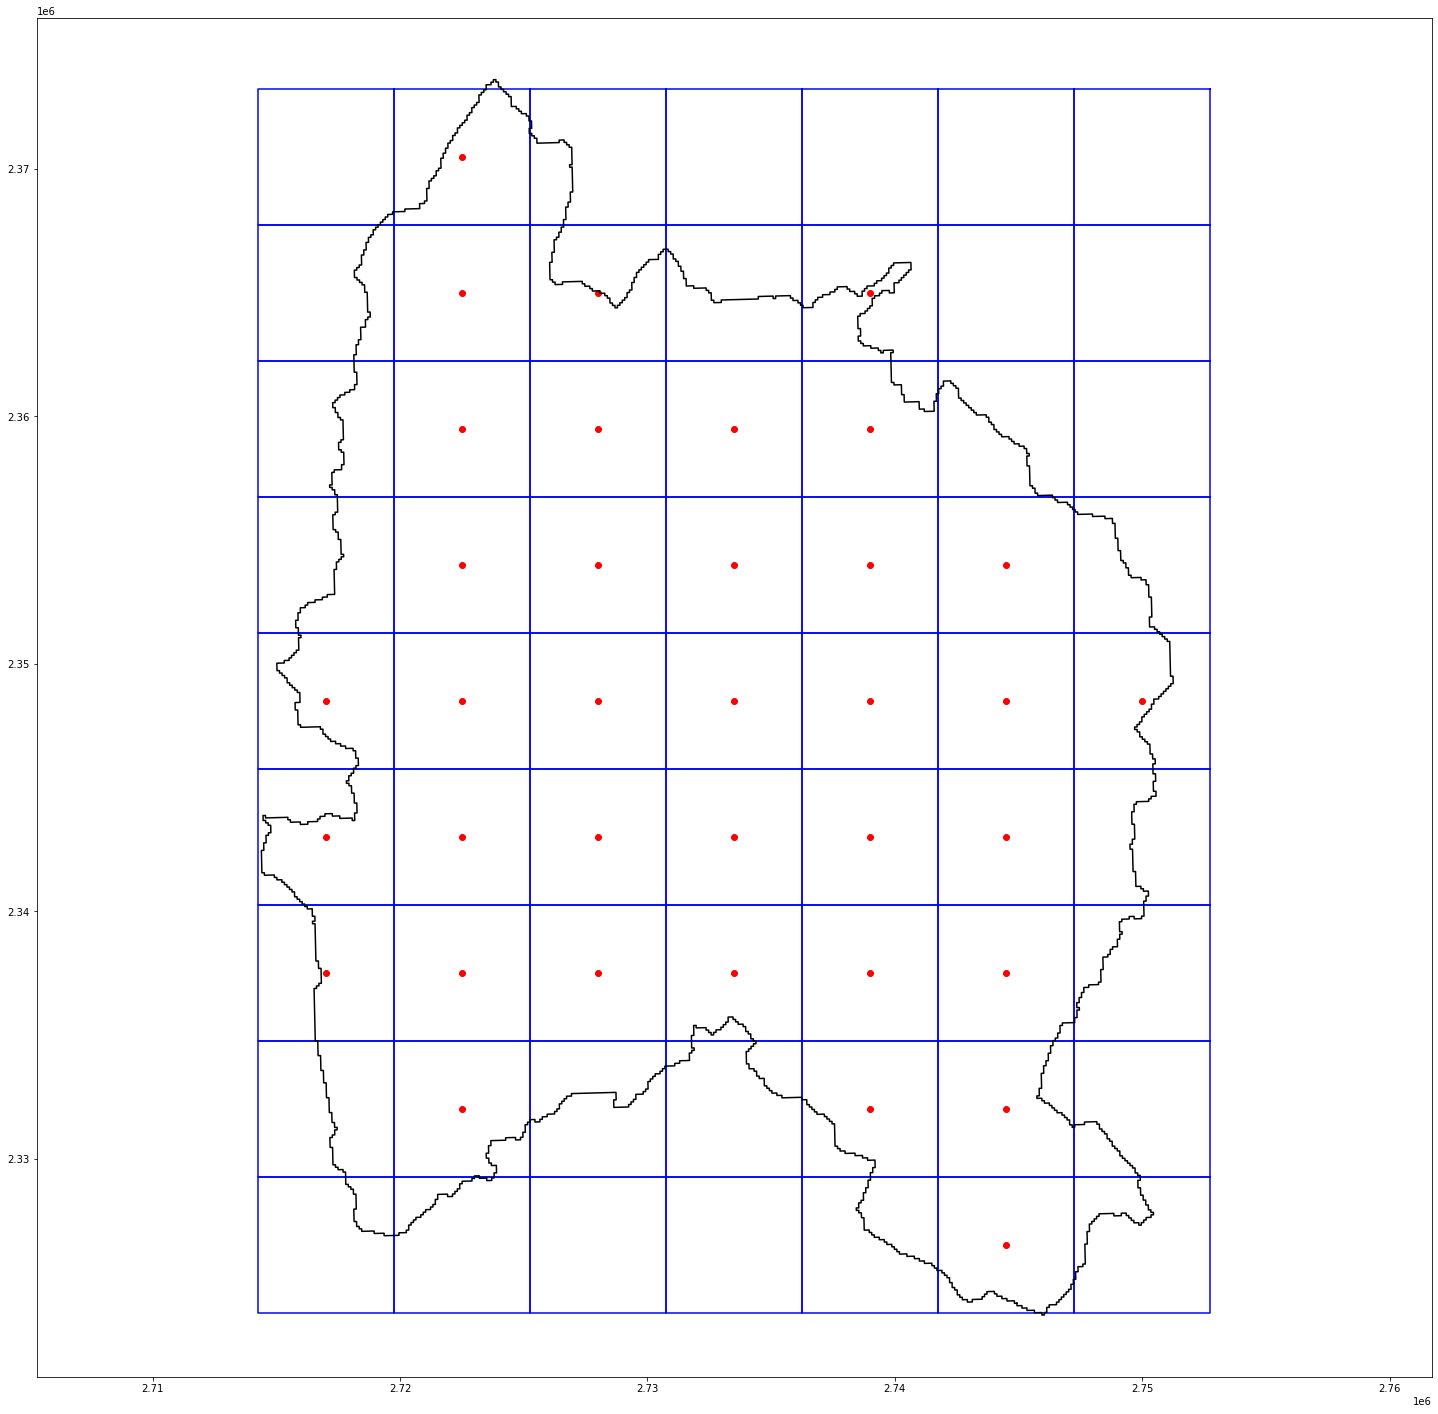

In [55]:
# ERA5 total precipitation
era5_fileName = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\total_precipitation-19790101_20181231-eusalp-qm_era5.nc'

tp = readnetcdf_in_shp_db(era5_fileName, STAT_CODE,plot=True)['tp']
tp = xarray2df(tp.resample(time='1d').sum(skipna=False), 'P','tp')

check_data_gap(tp)

n of pixels144
Date start: 1979-01-01, date end: 2020-12-31
No missing dates


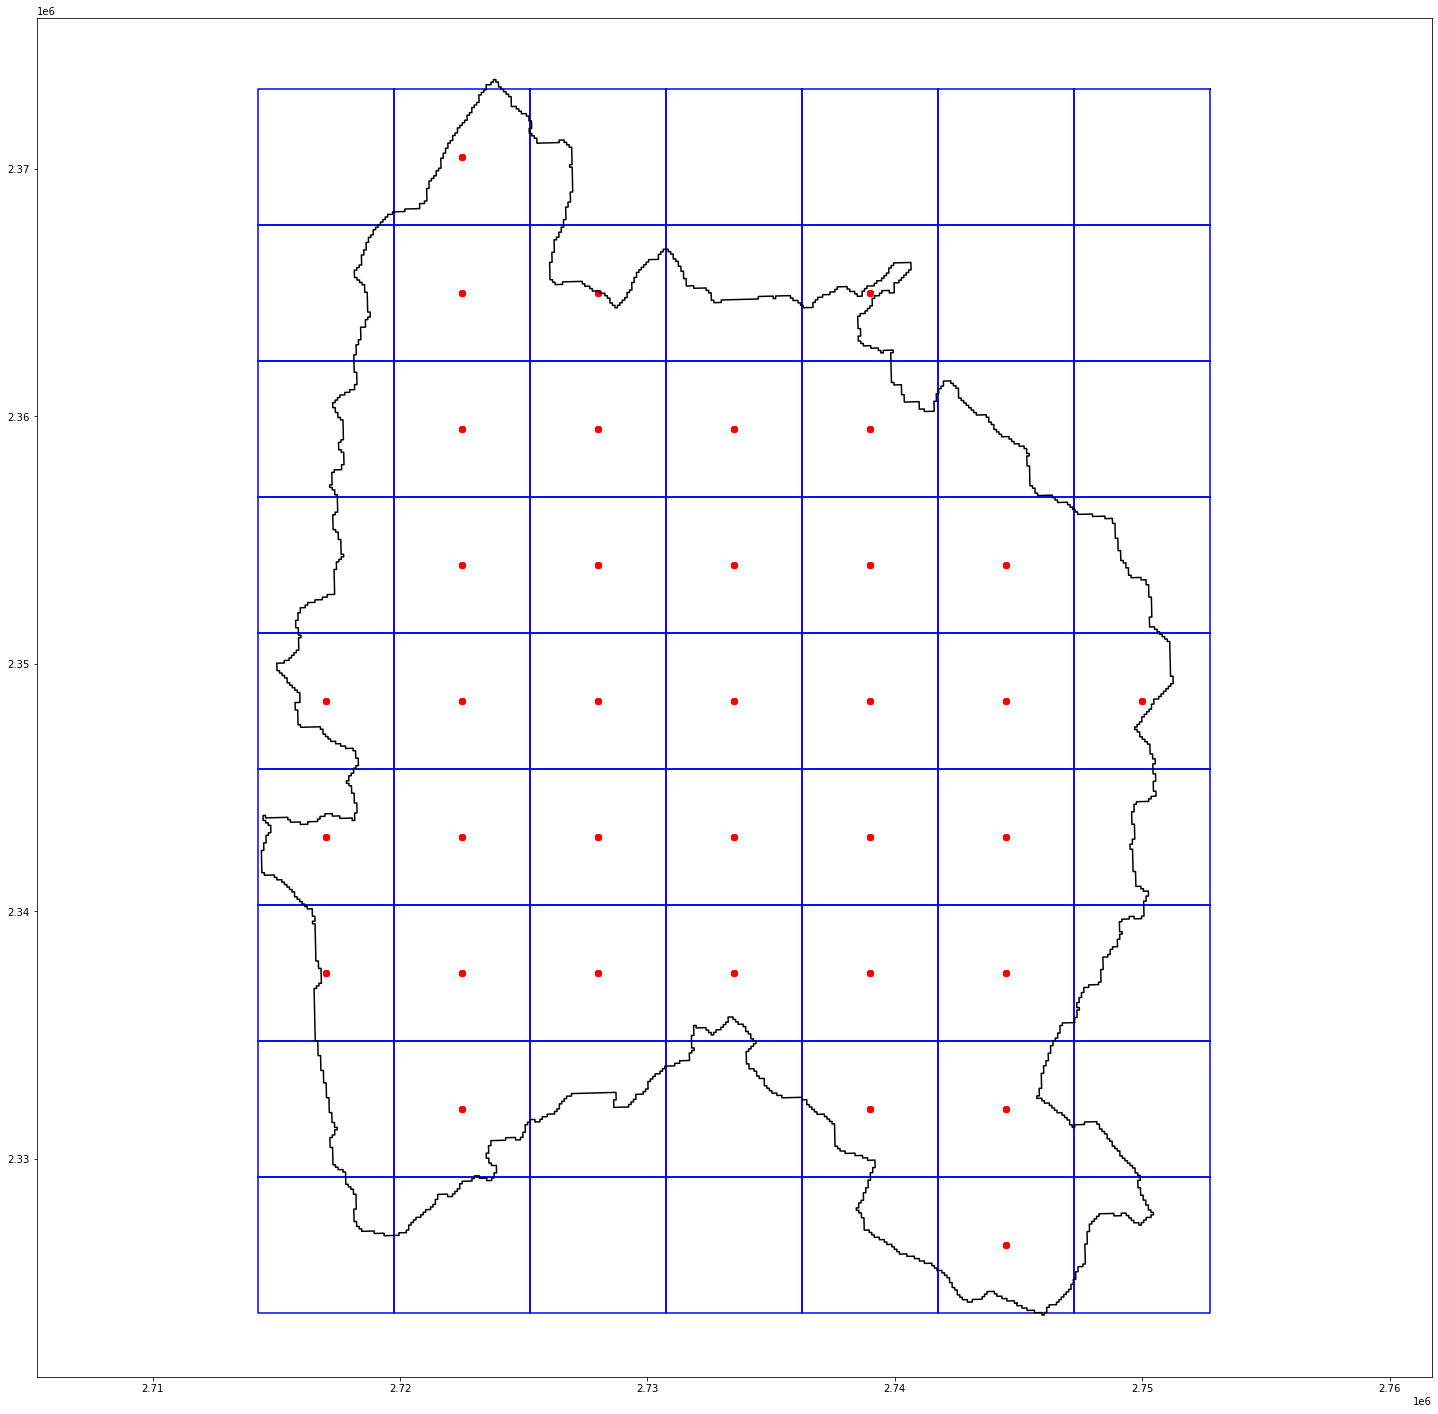

In [113]:
# ERA5 total SNOW VARIABLES
era5_fileName = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\SNOWGRID\ado-snowgrid.nc'

s = readnetcdf_in_shp_db(era5_fileName, STAT_CODE,plot=True)['swe_tot']
s = xarray2df(s.resample(time='1d').sum(skipna=False), 'S','swe_tot')

check_data_gap(s)

n of pixels144
Date start: 1979-01-01, date end: 2020-12-31
No missing dates


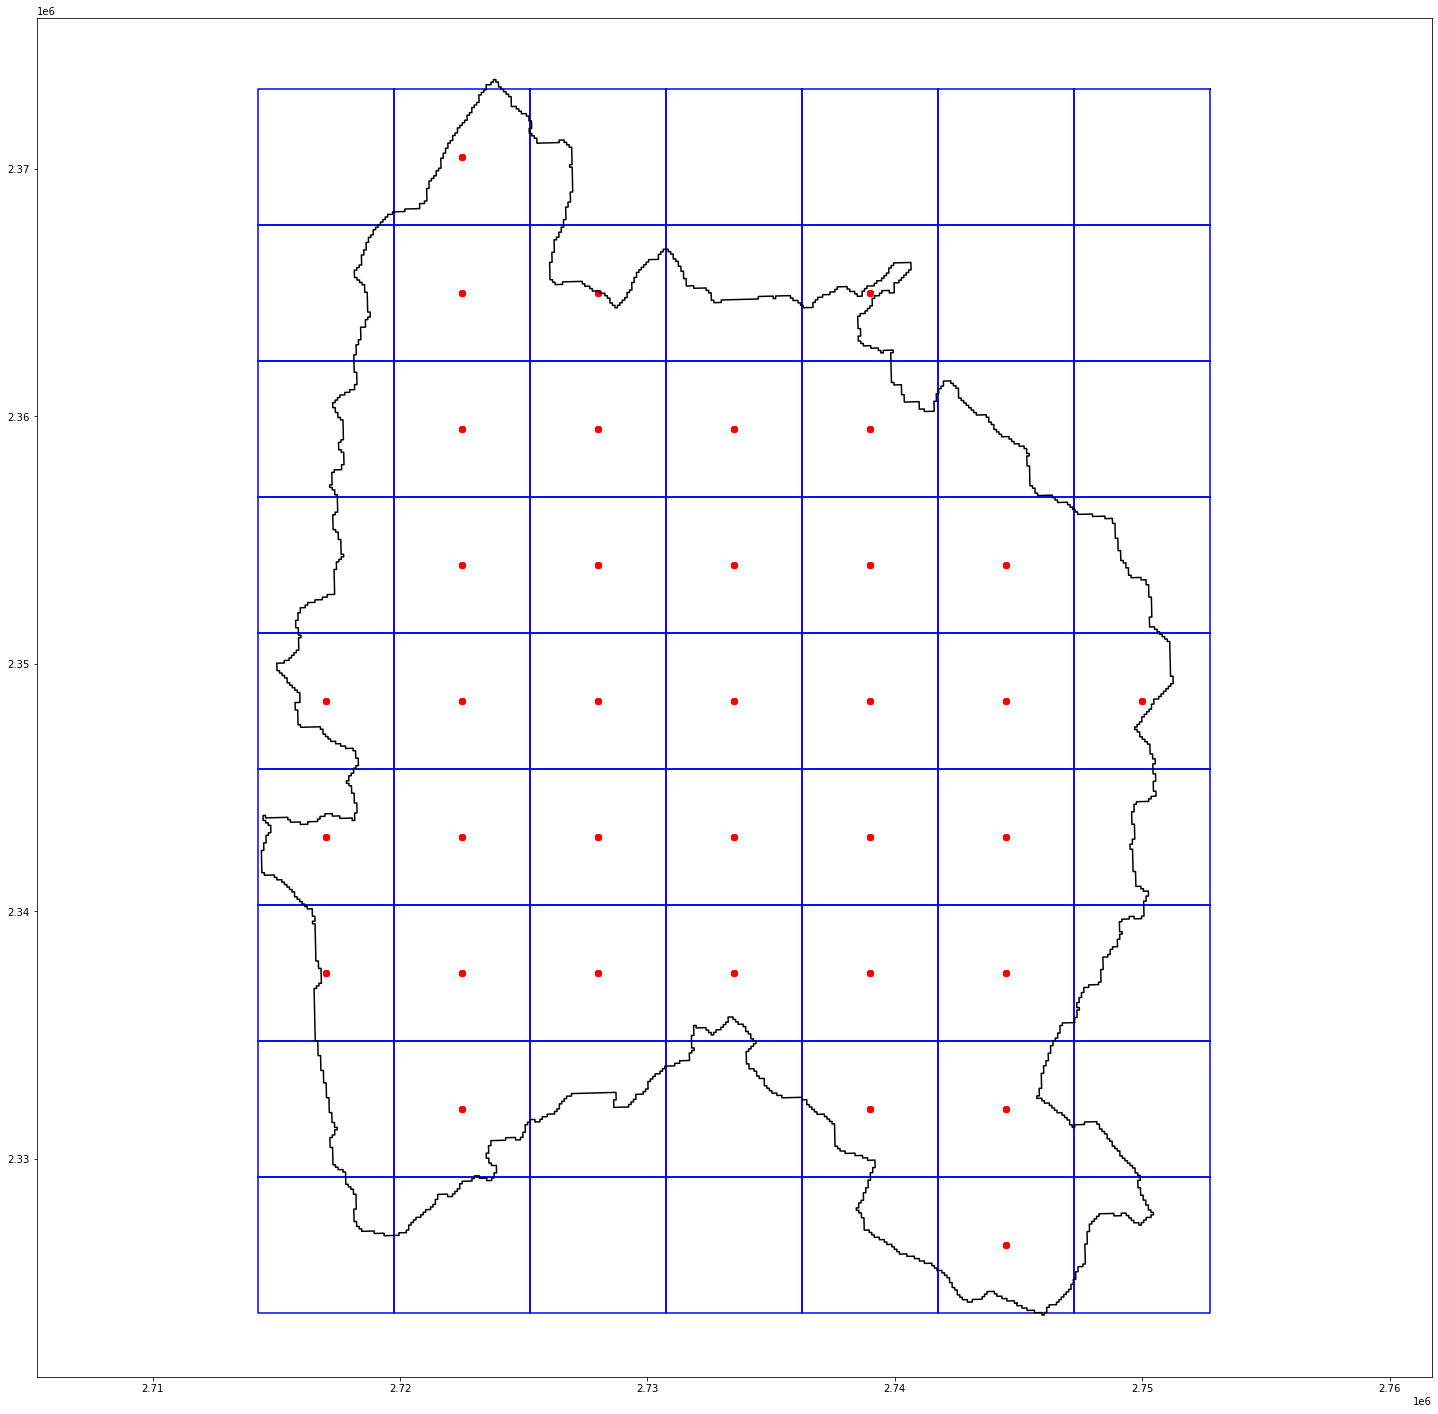

In [114]:

r = readnetcdf_in_shp_db(era5_fileName, STAT_CODE,plot=True)['runoff']
r = xarray2df(r.resample(time='1d').sum(skipna=False), 'R','runoff')

check_data_gap(r)

In [56]:
from os import walk
mypath= r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\SNOWGRID/'

filenames = next(walk(mypath), (None, None, []))[2]  # [] if no file

n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144


C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\Runoff_prediction\create_daily_csv.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(25,25))


n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144
n of pixels144


KeyboardInterrupt: 

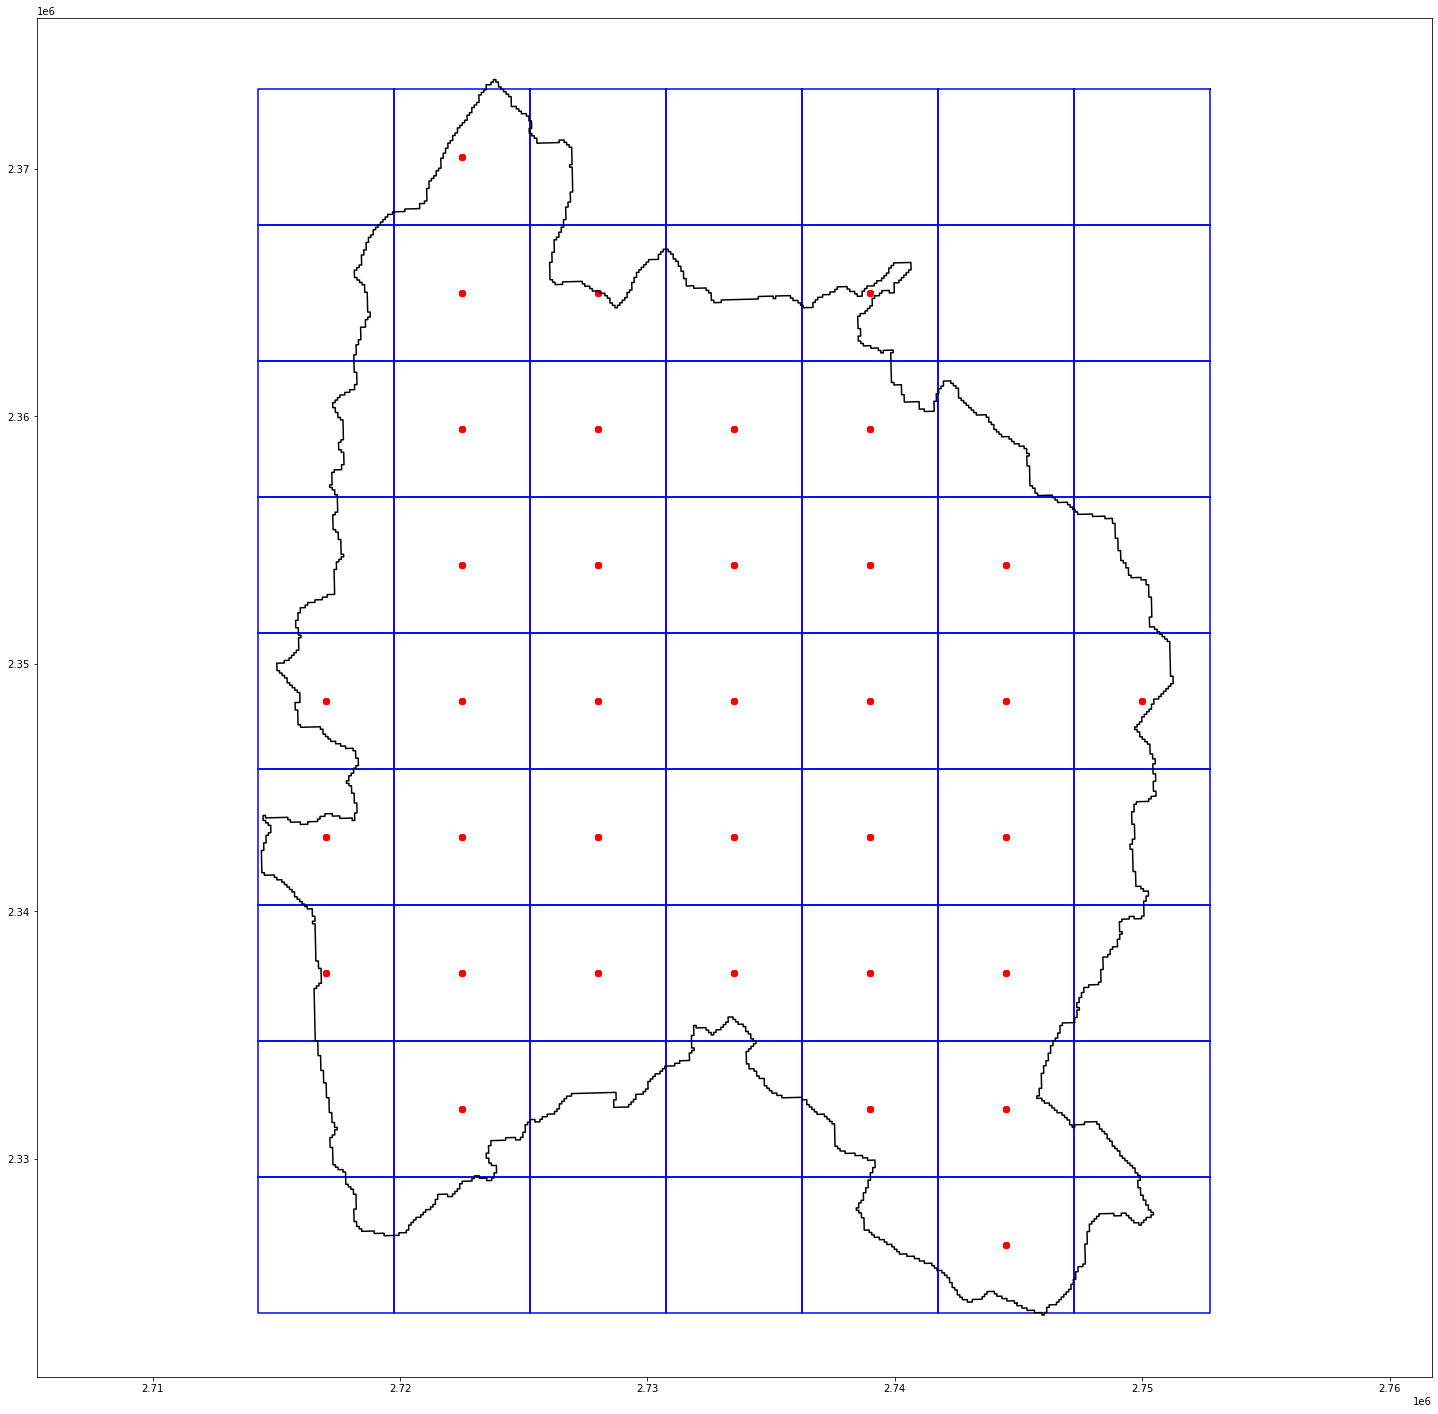

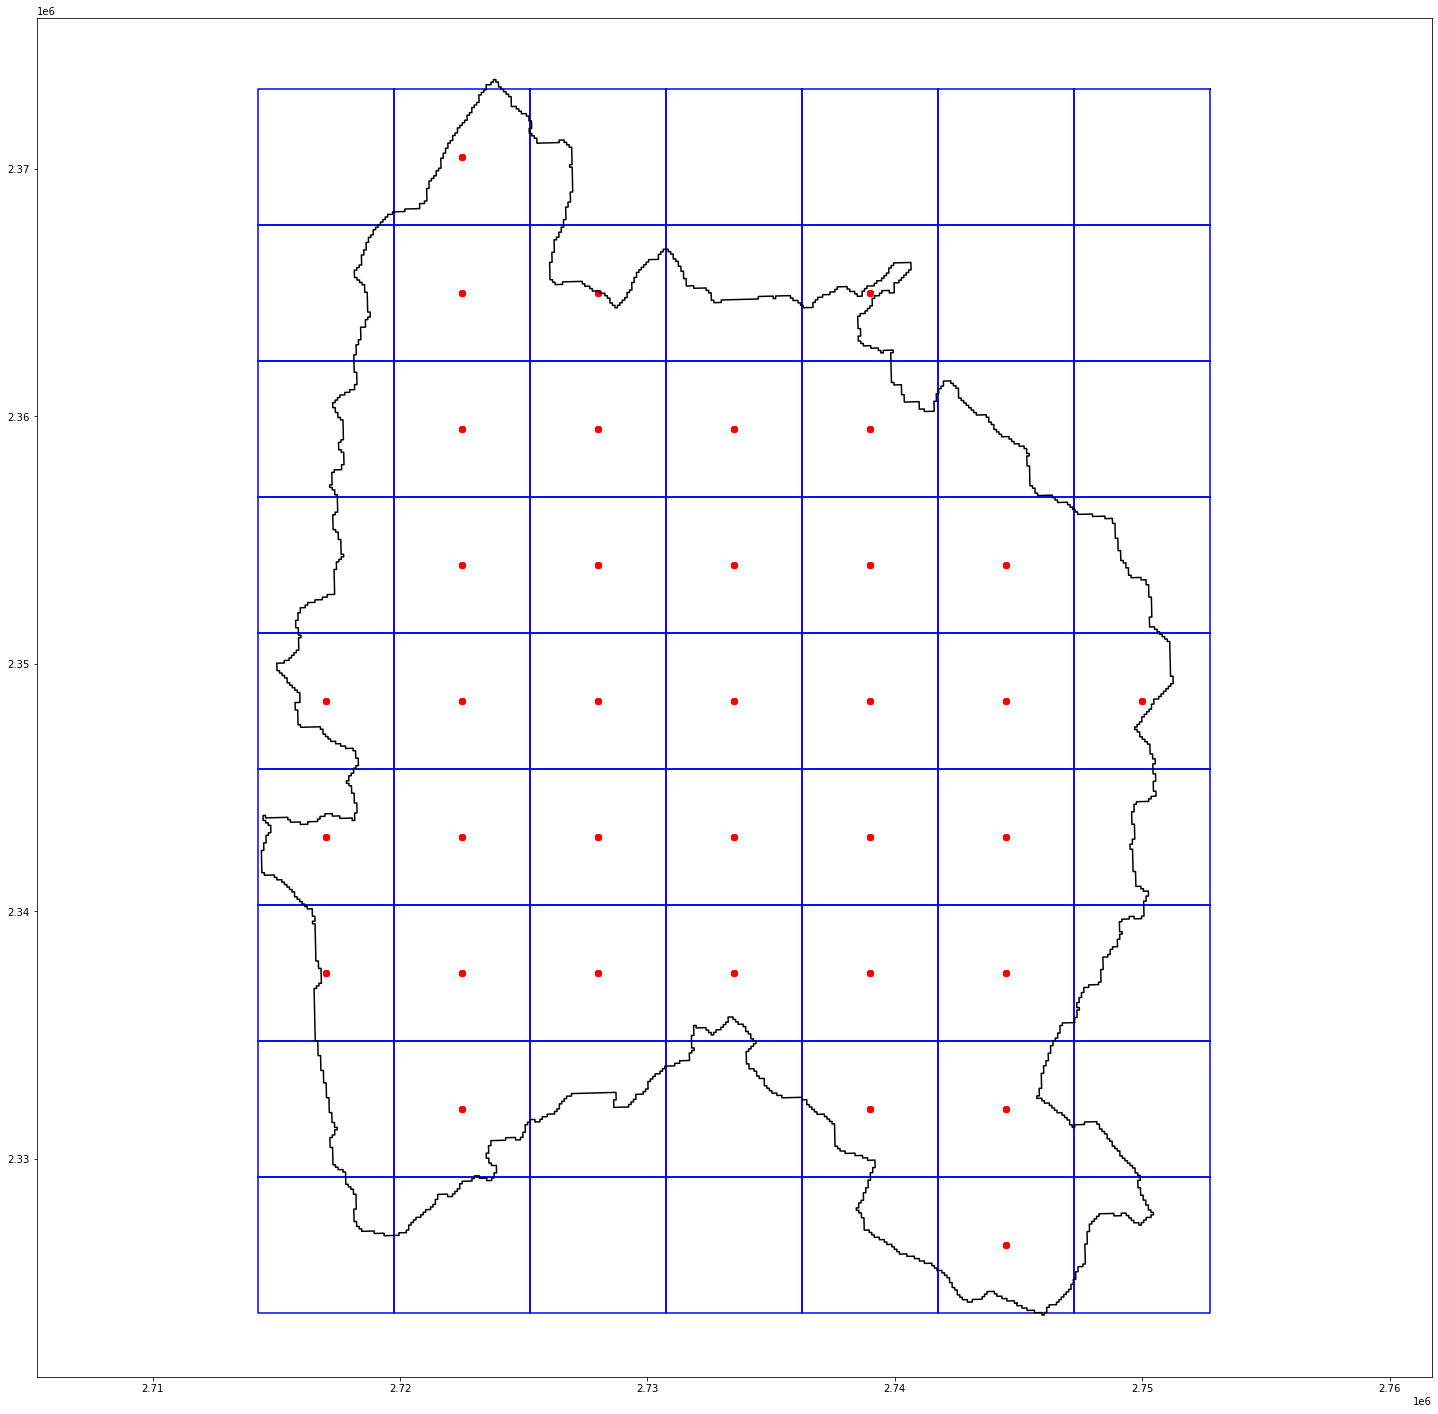

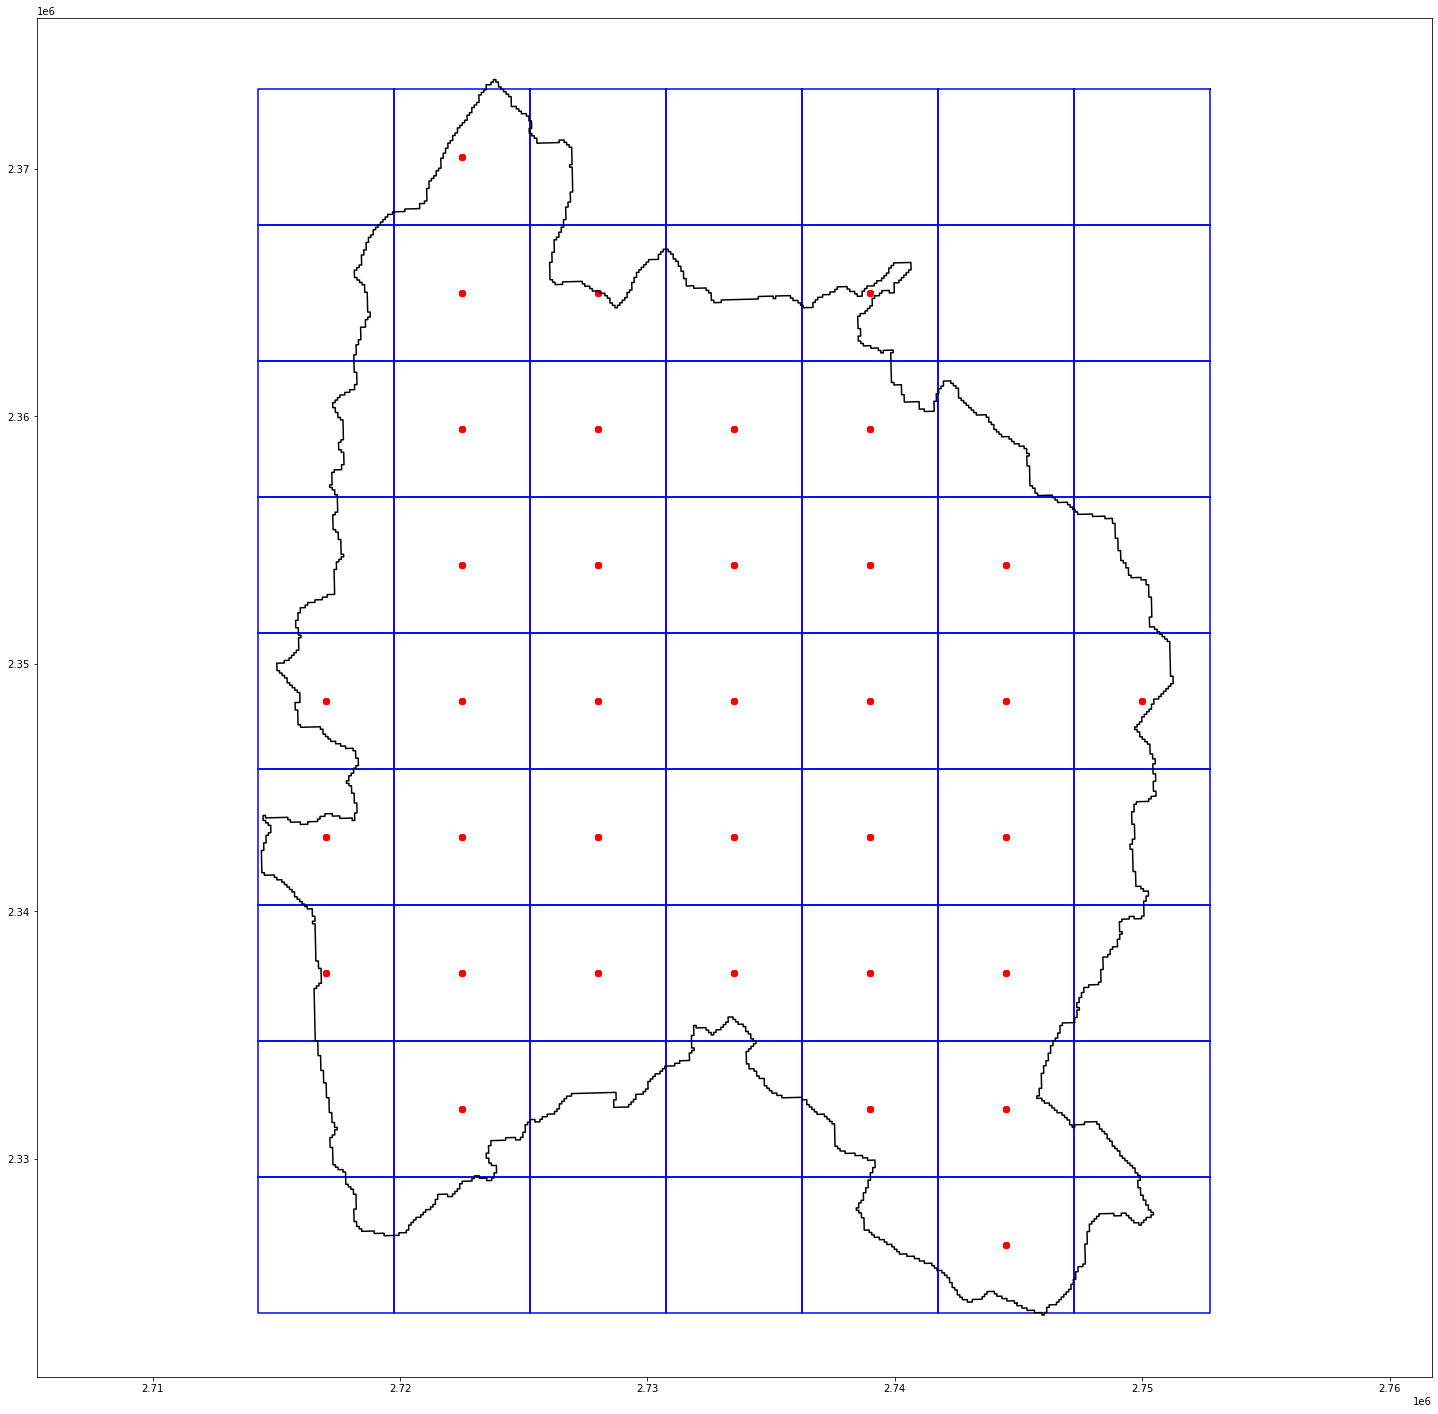

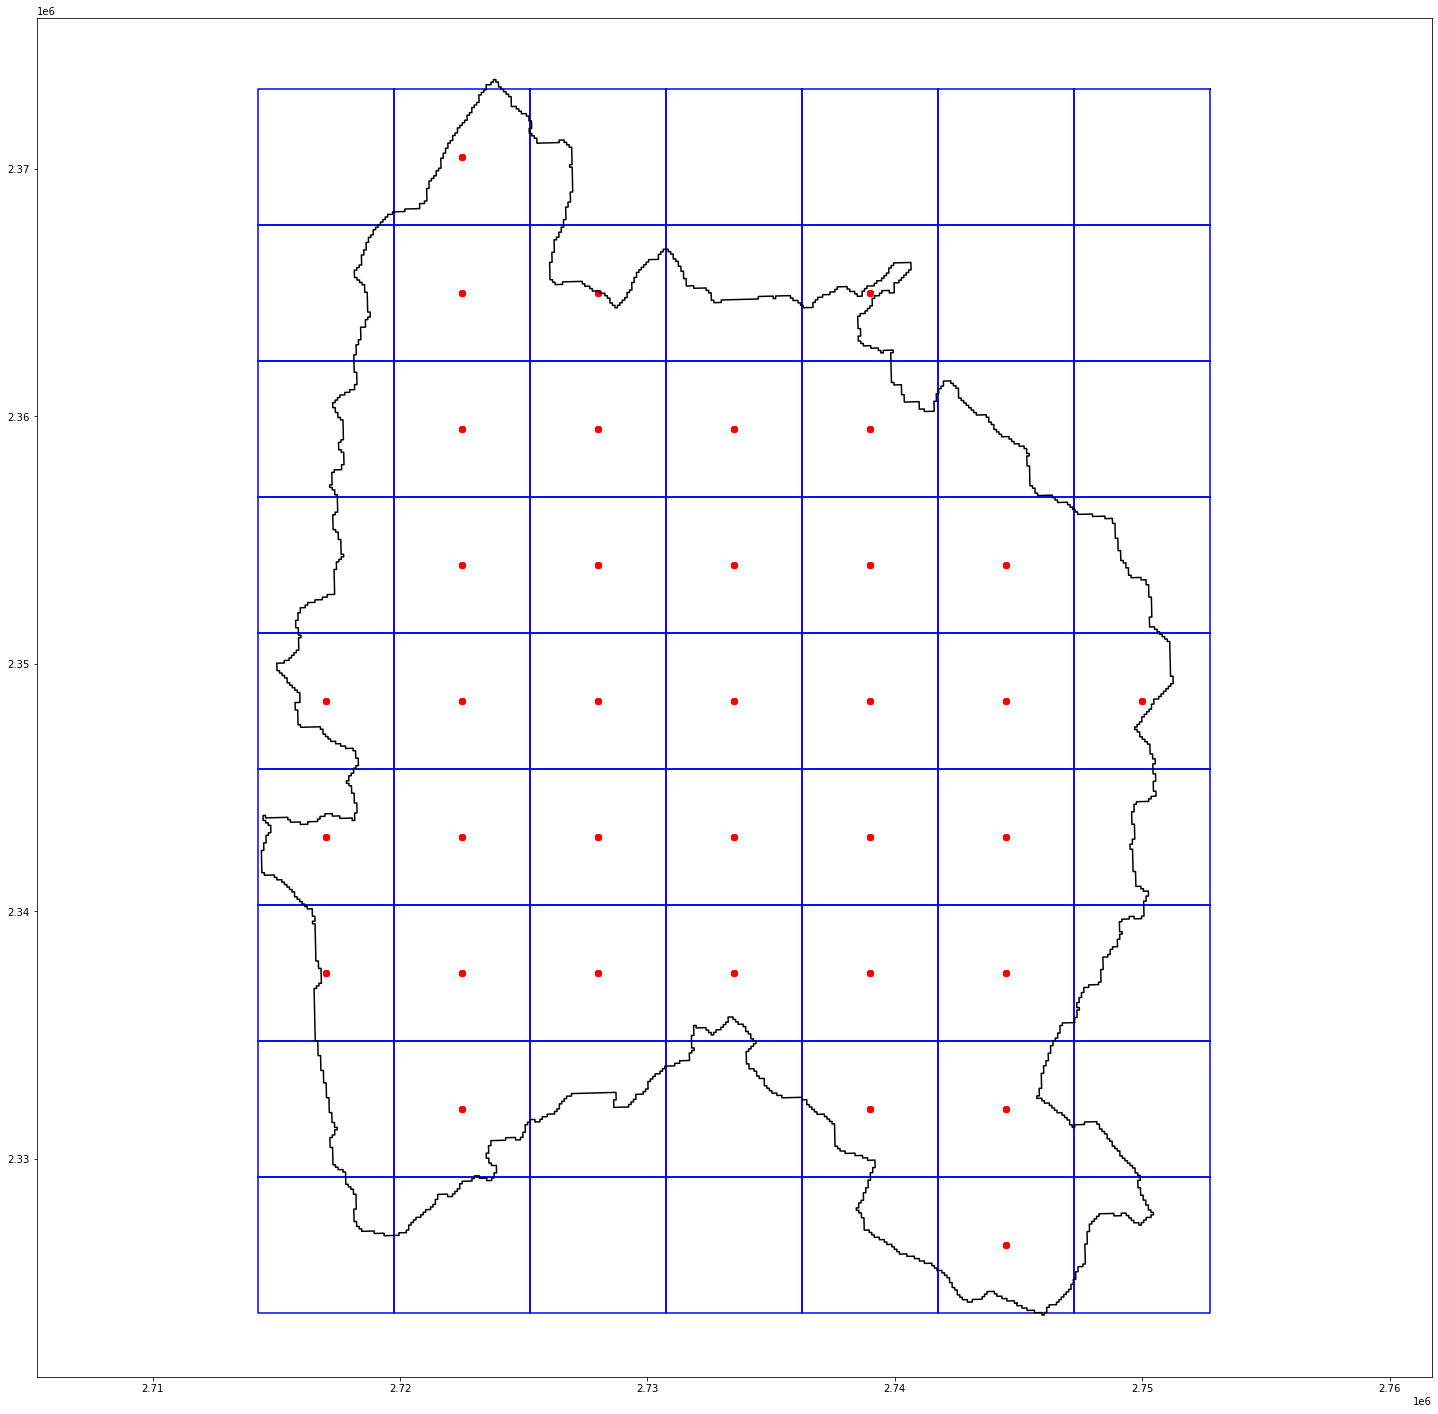

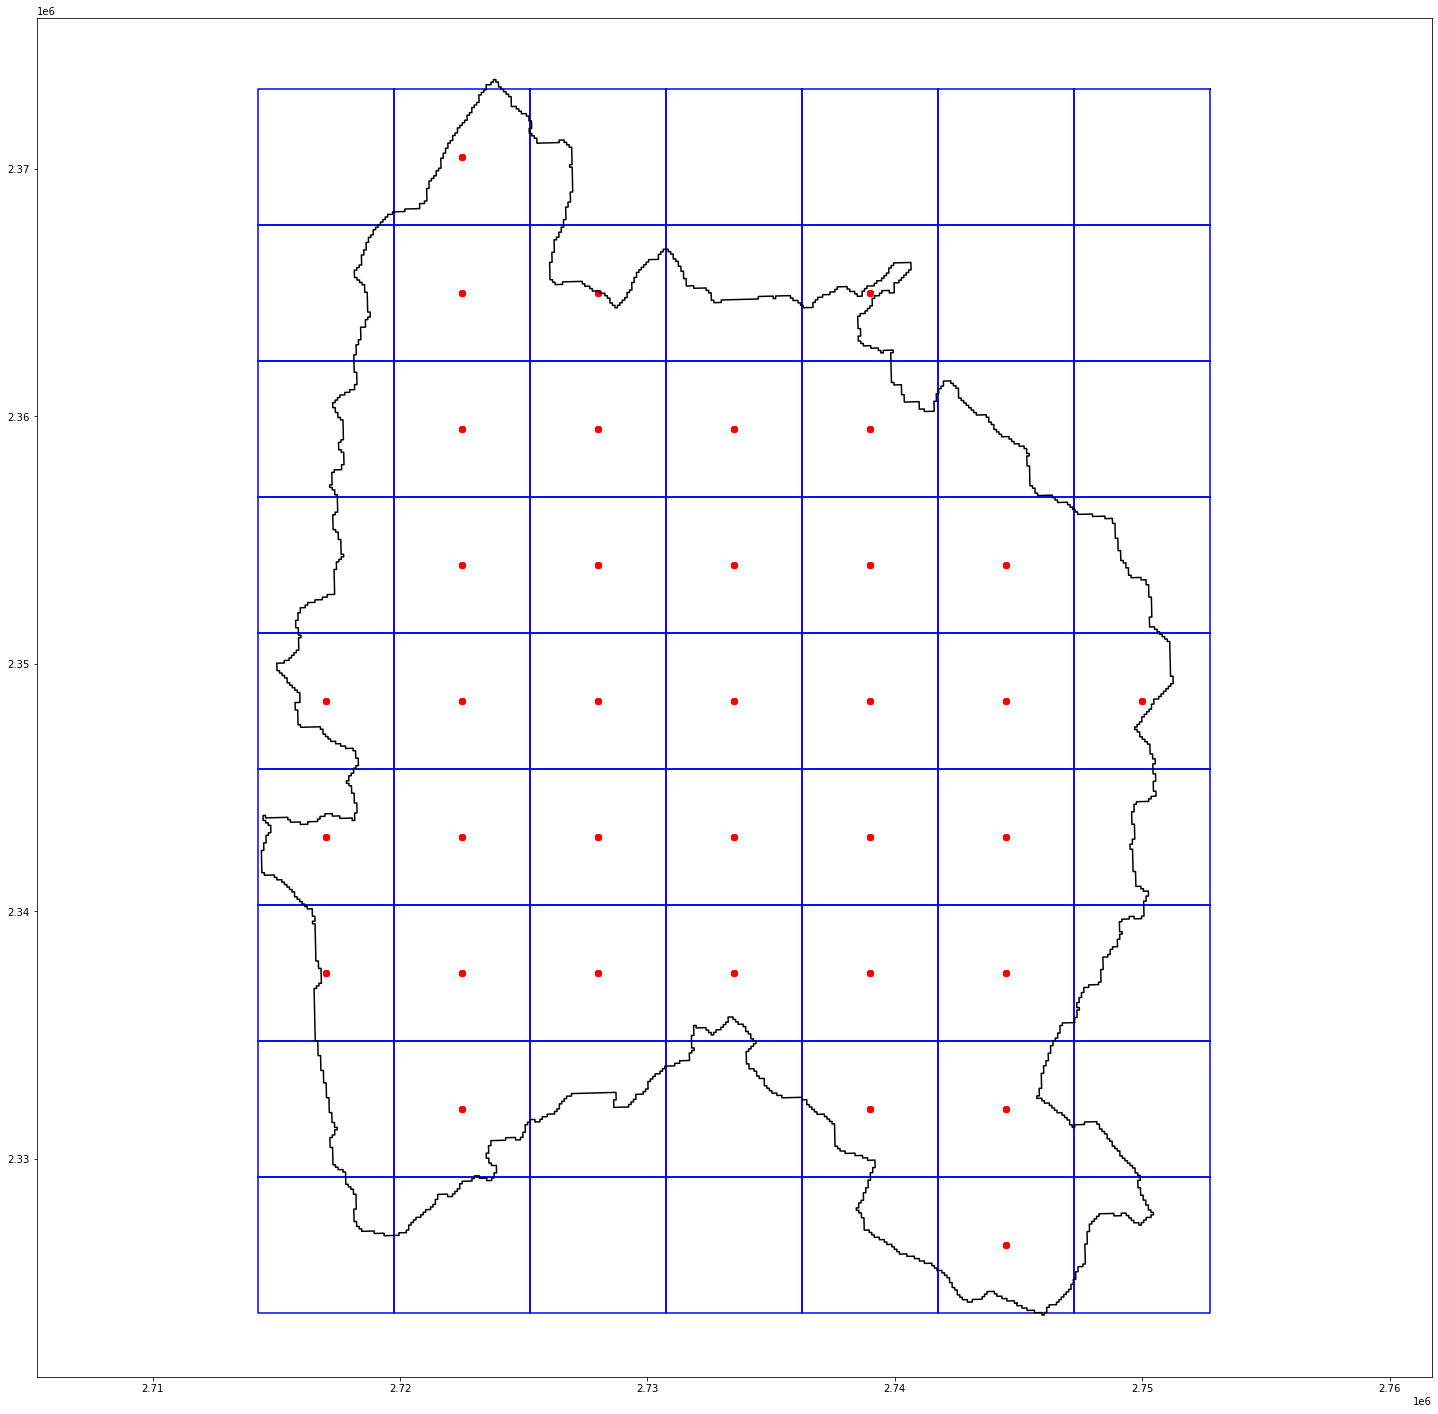

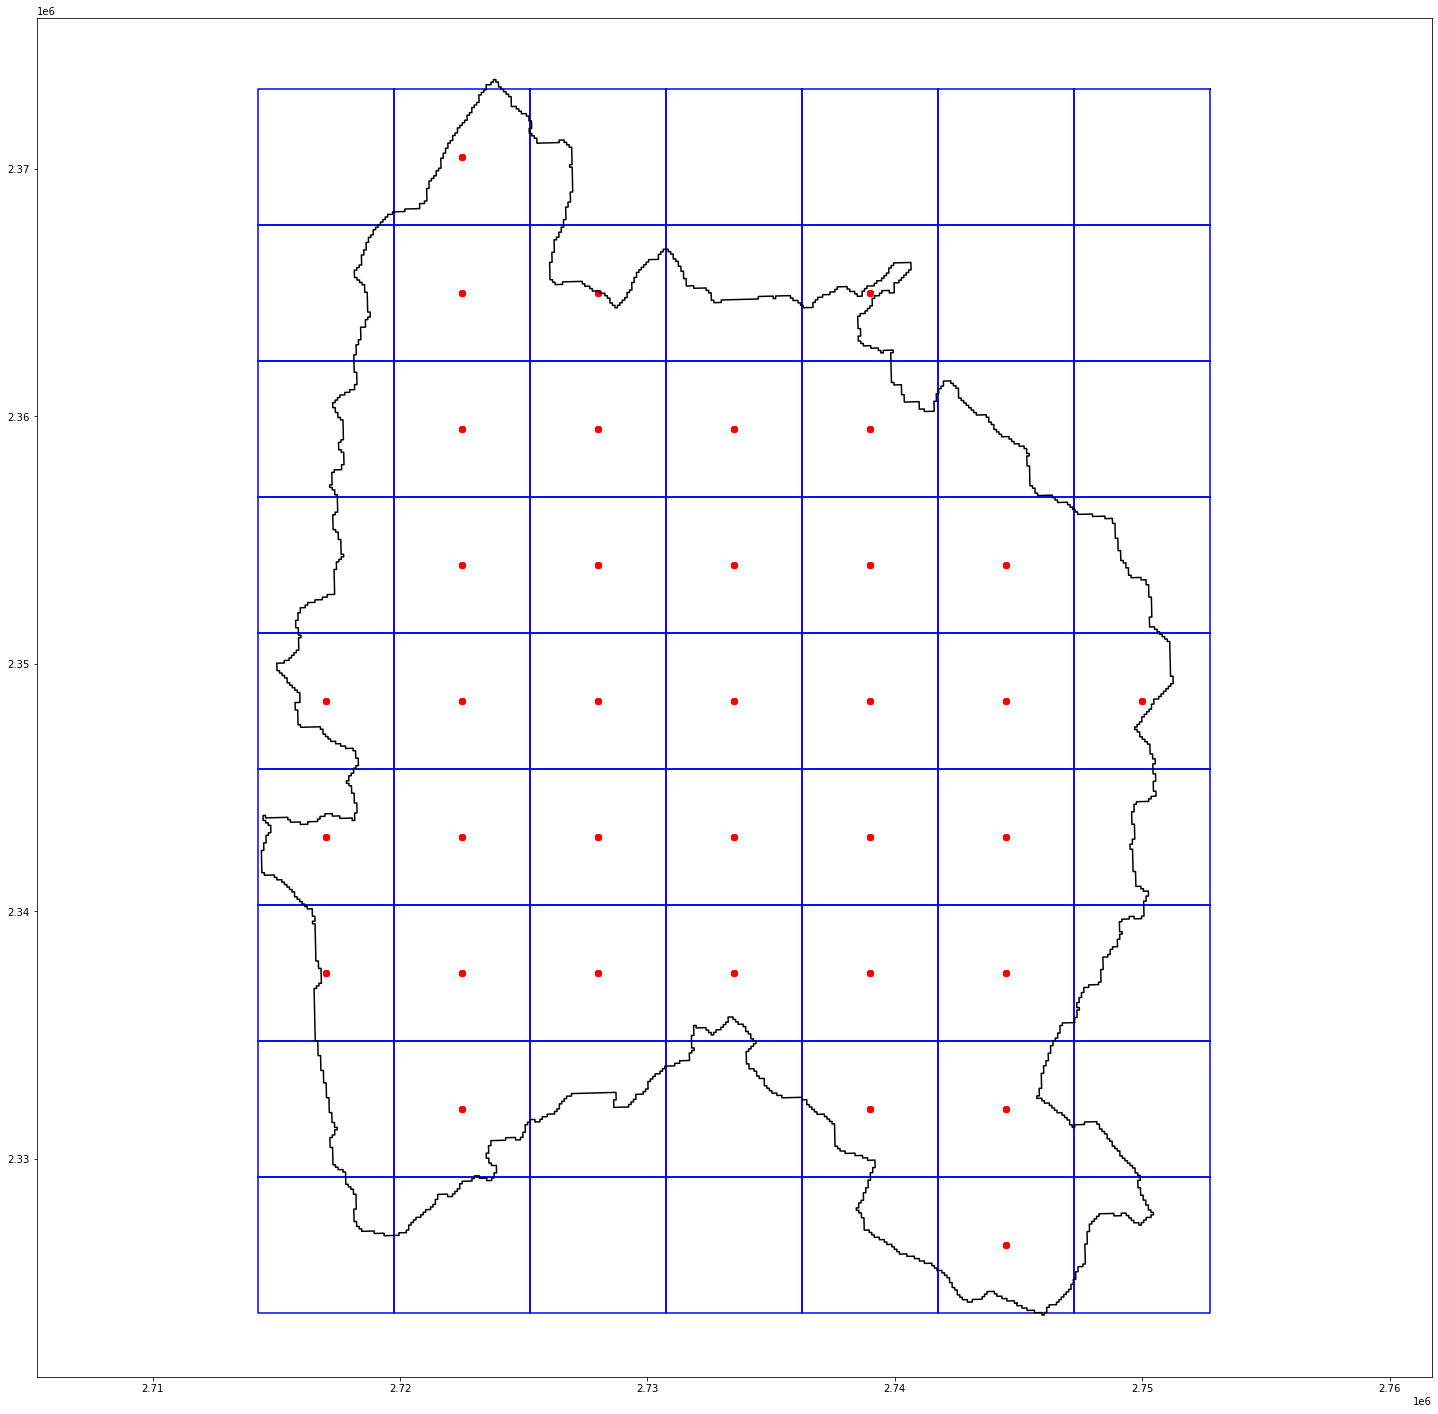

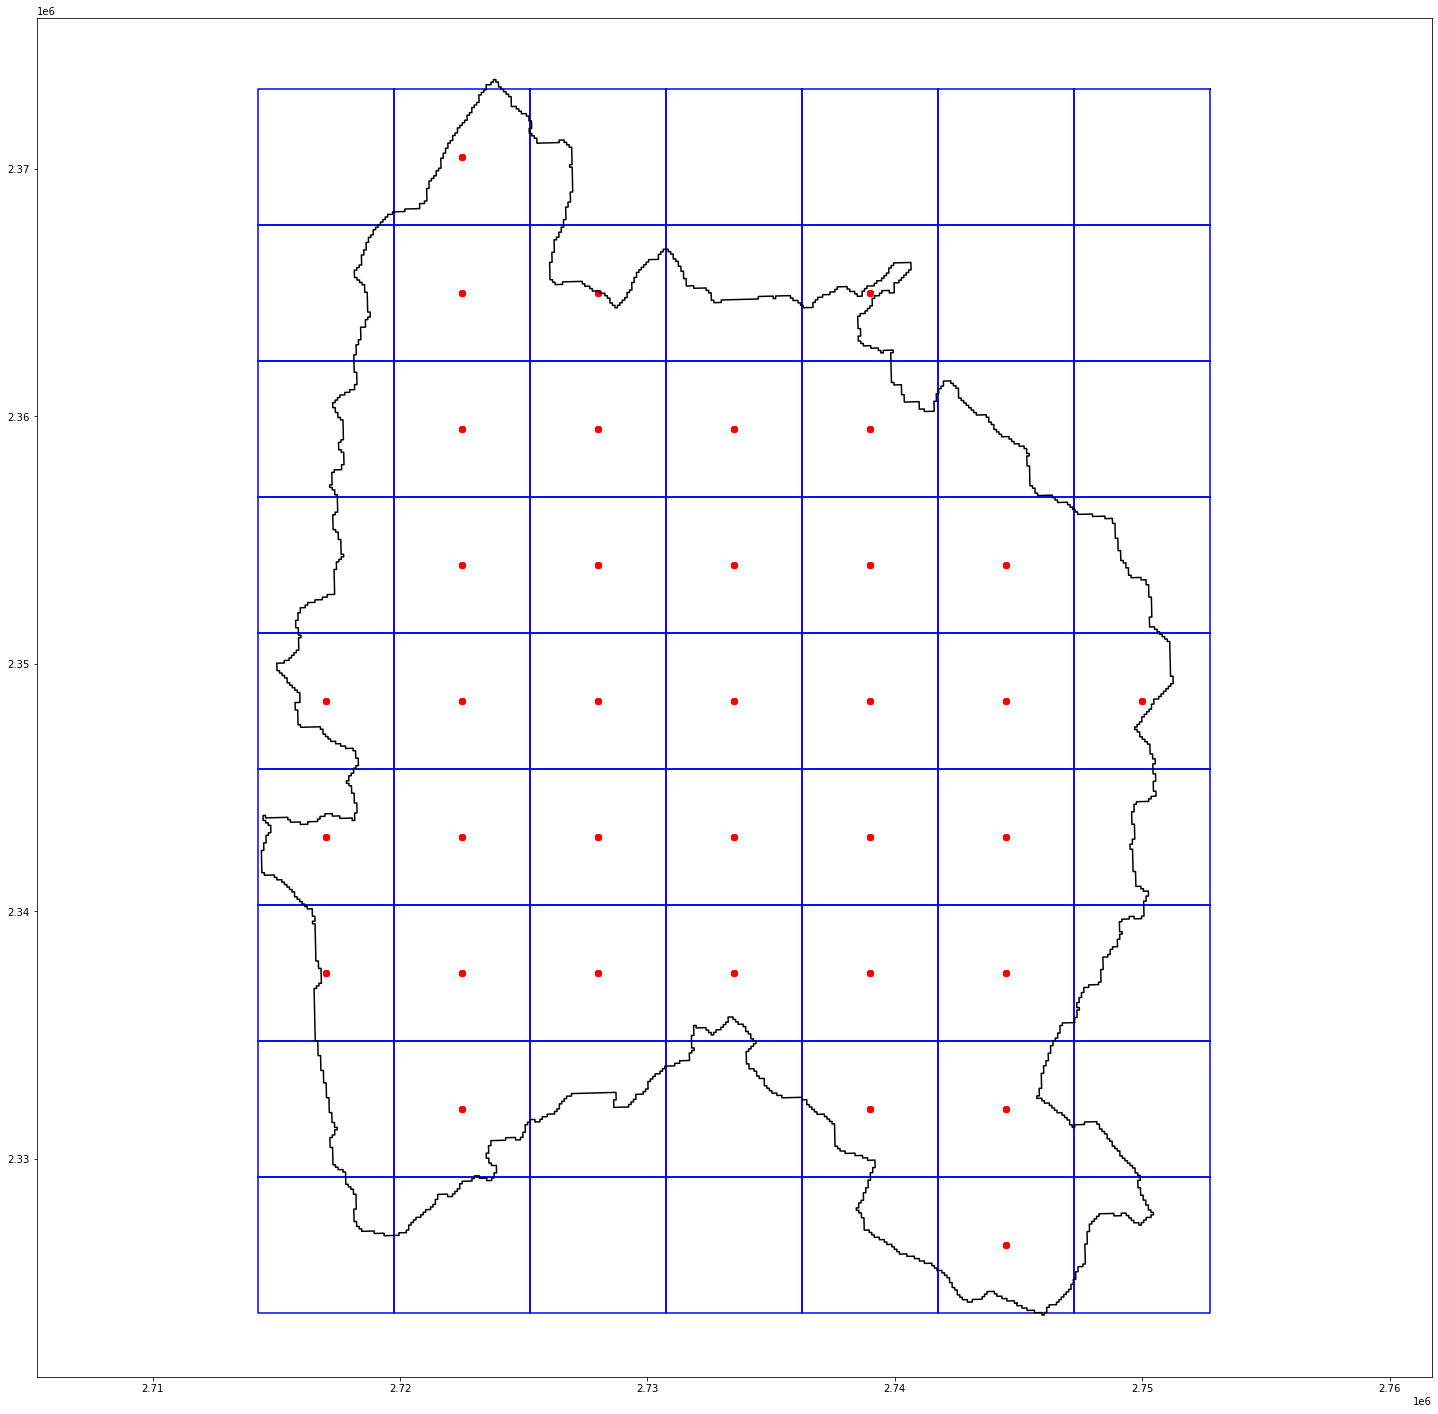

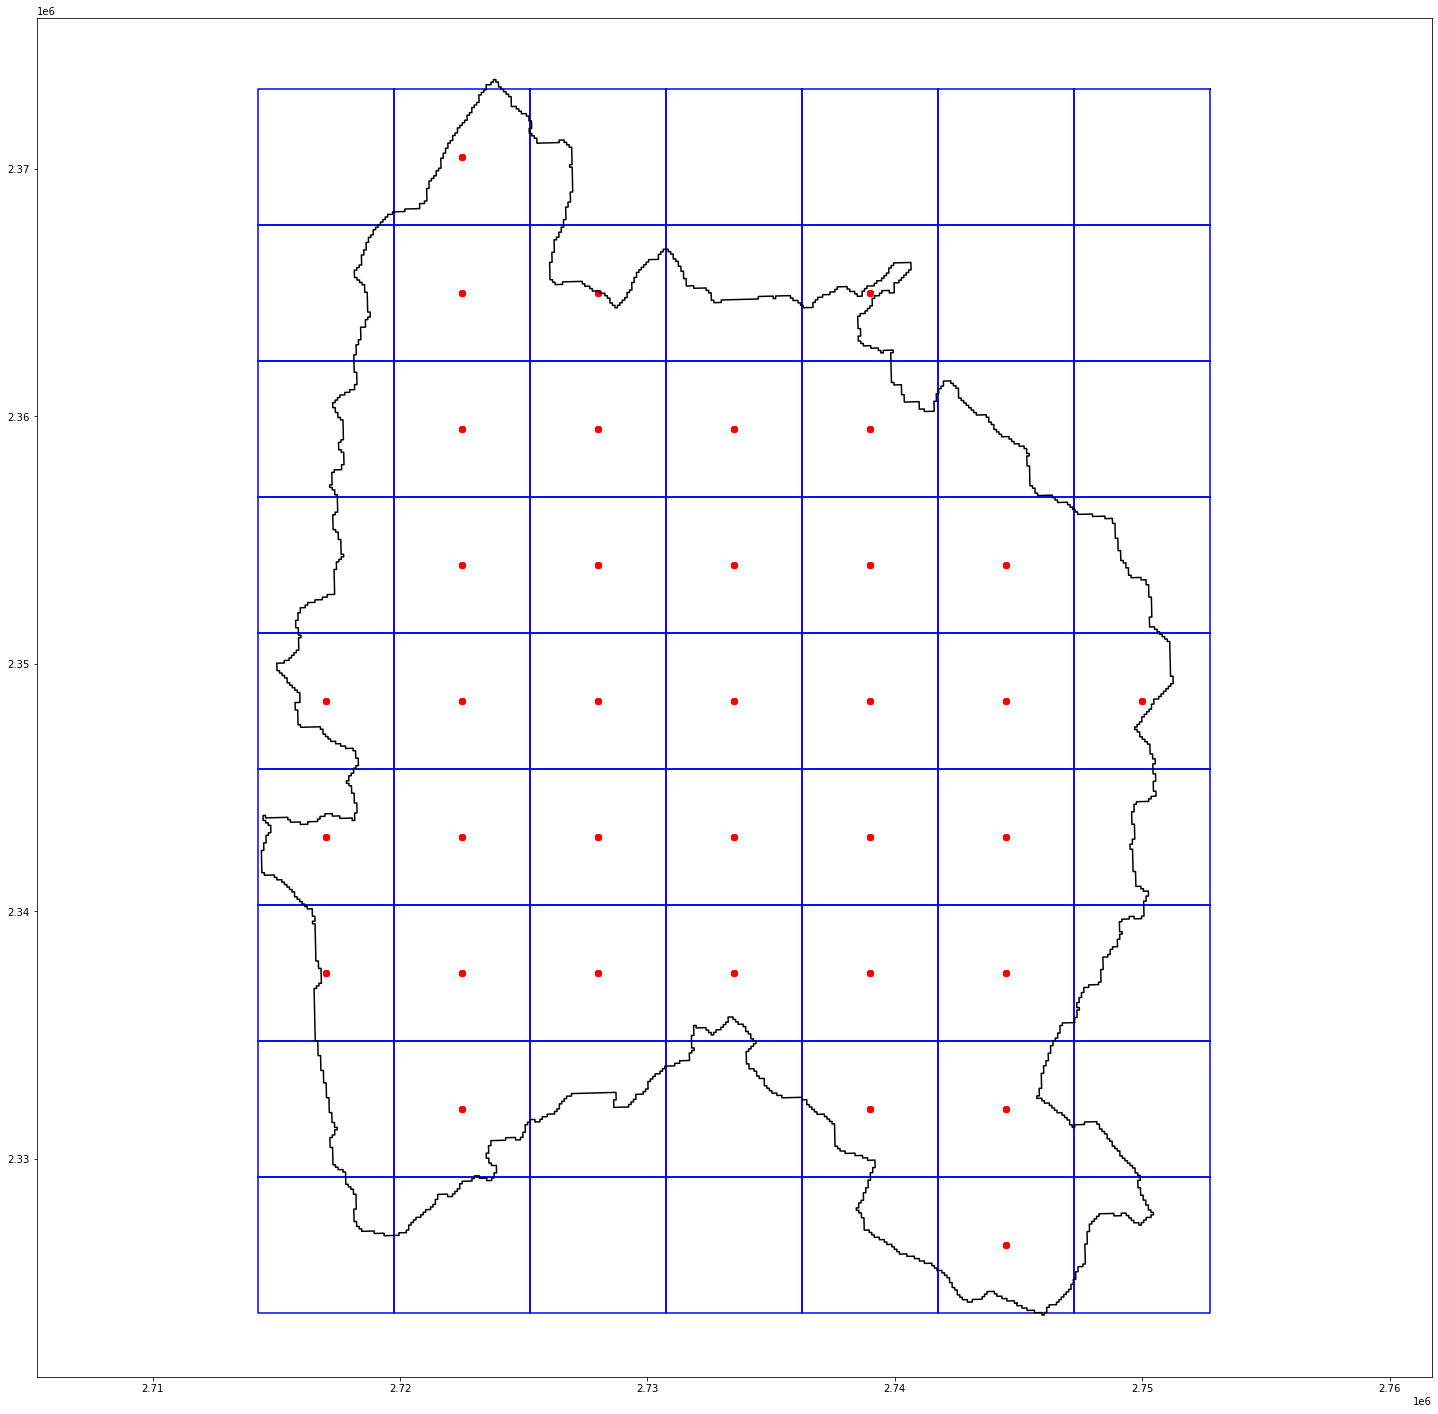

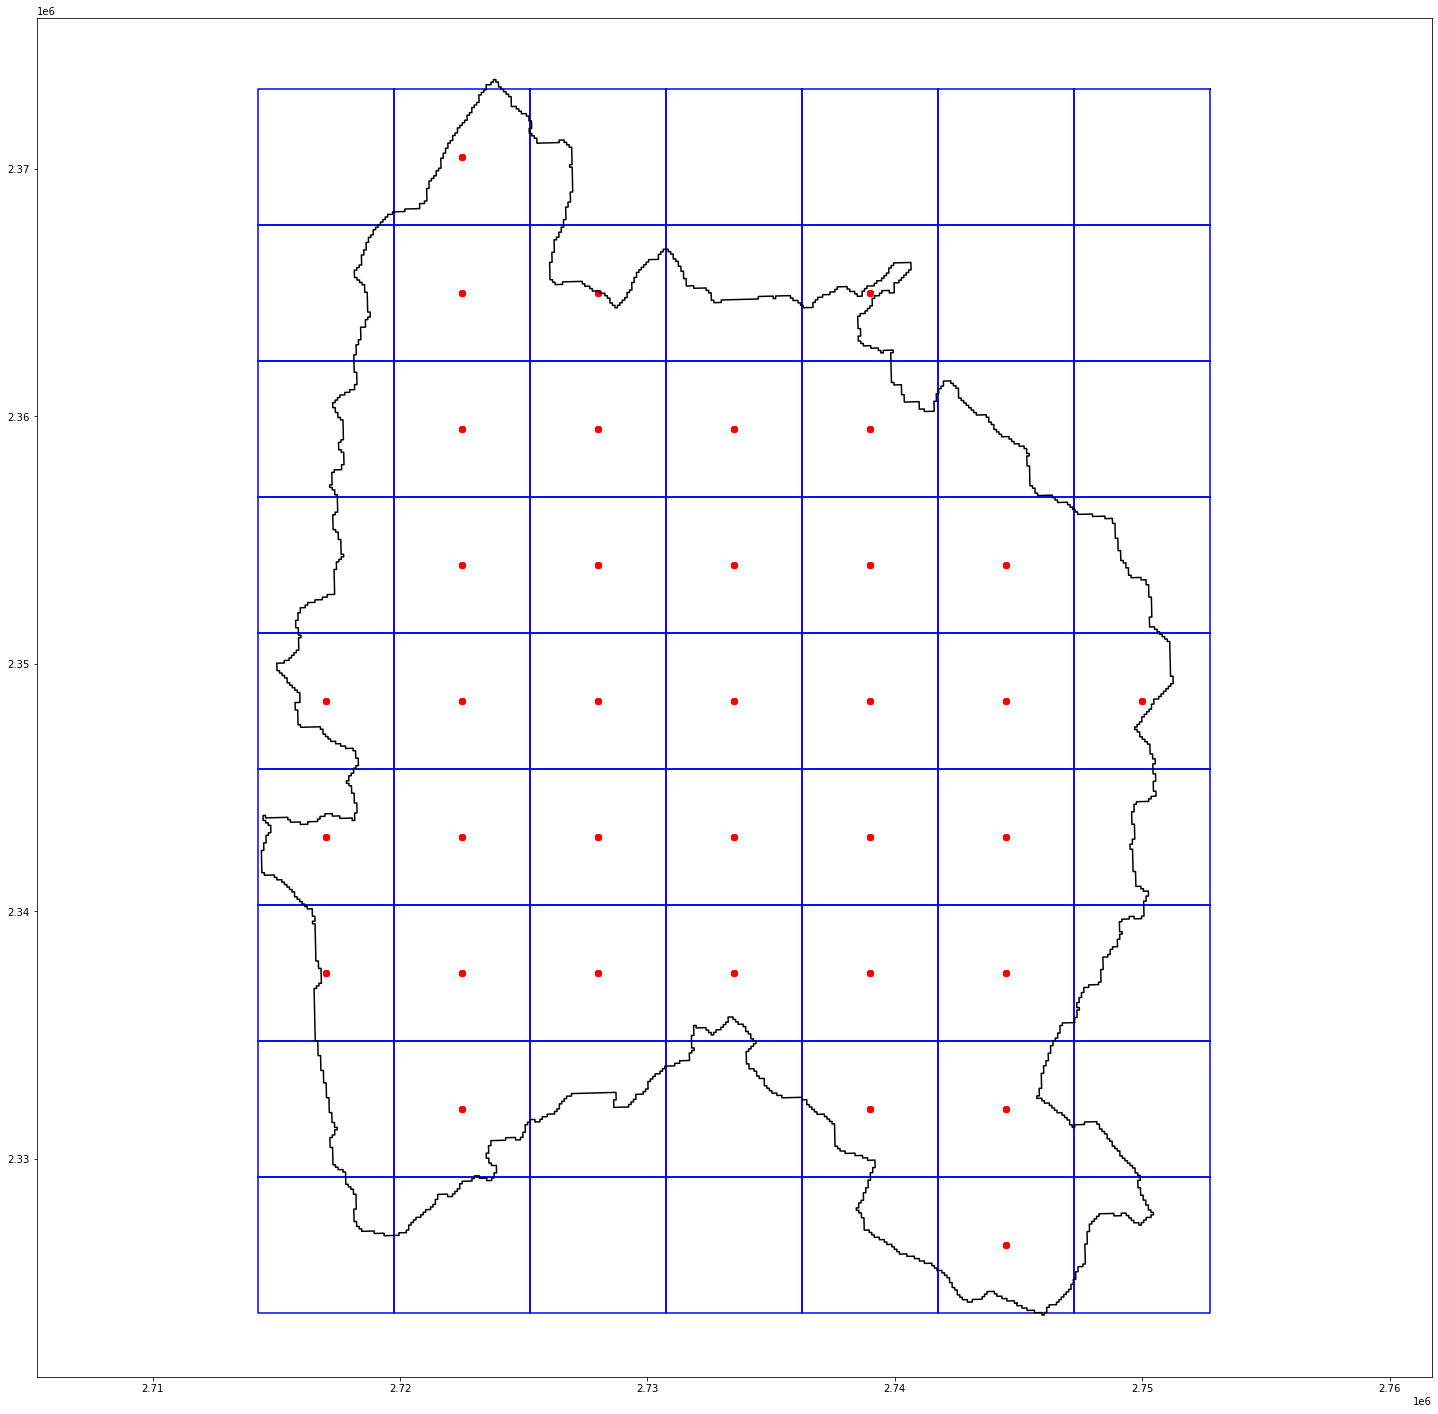

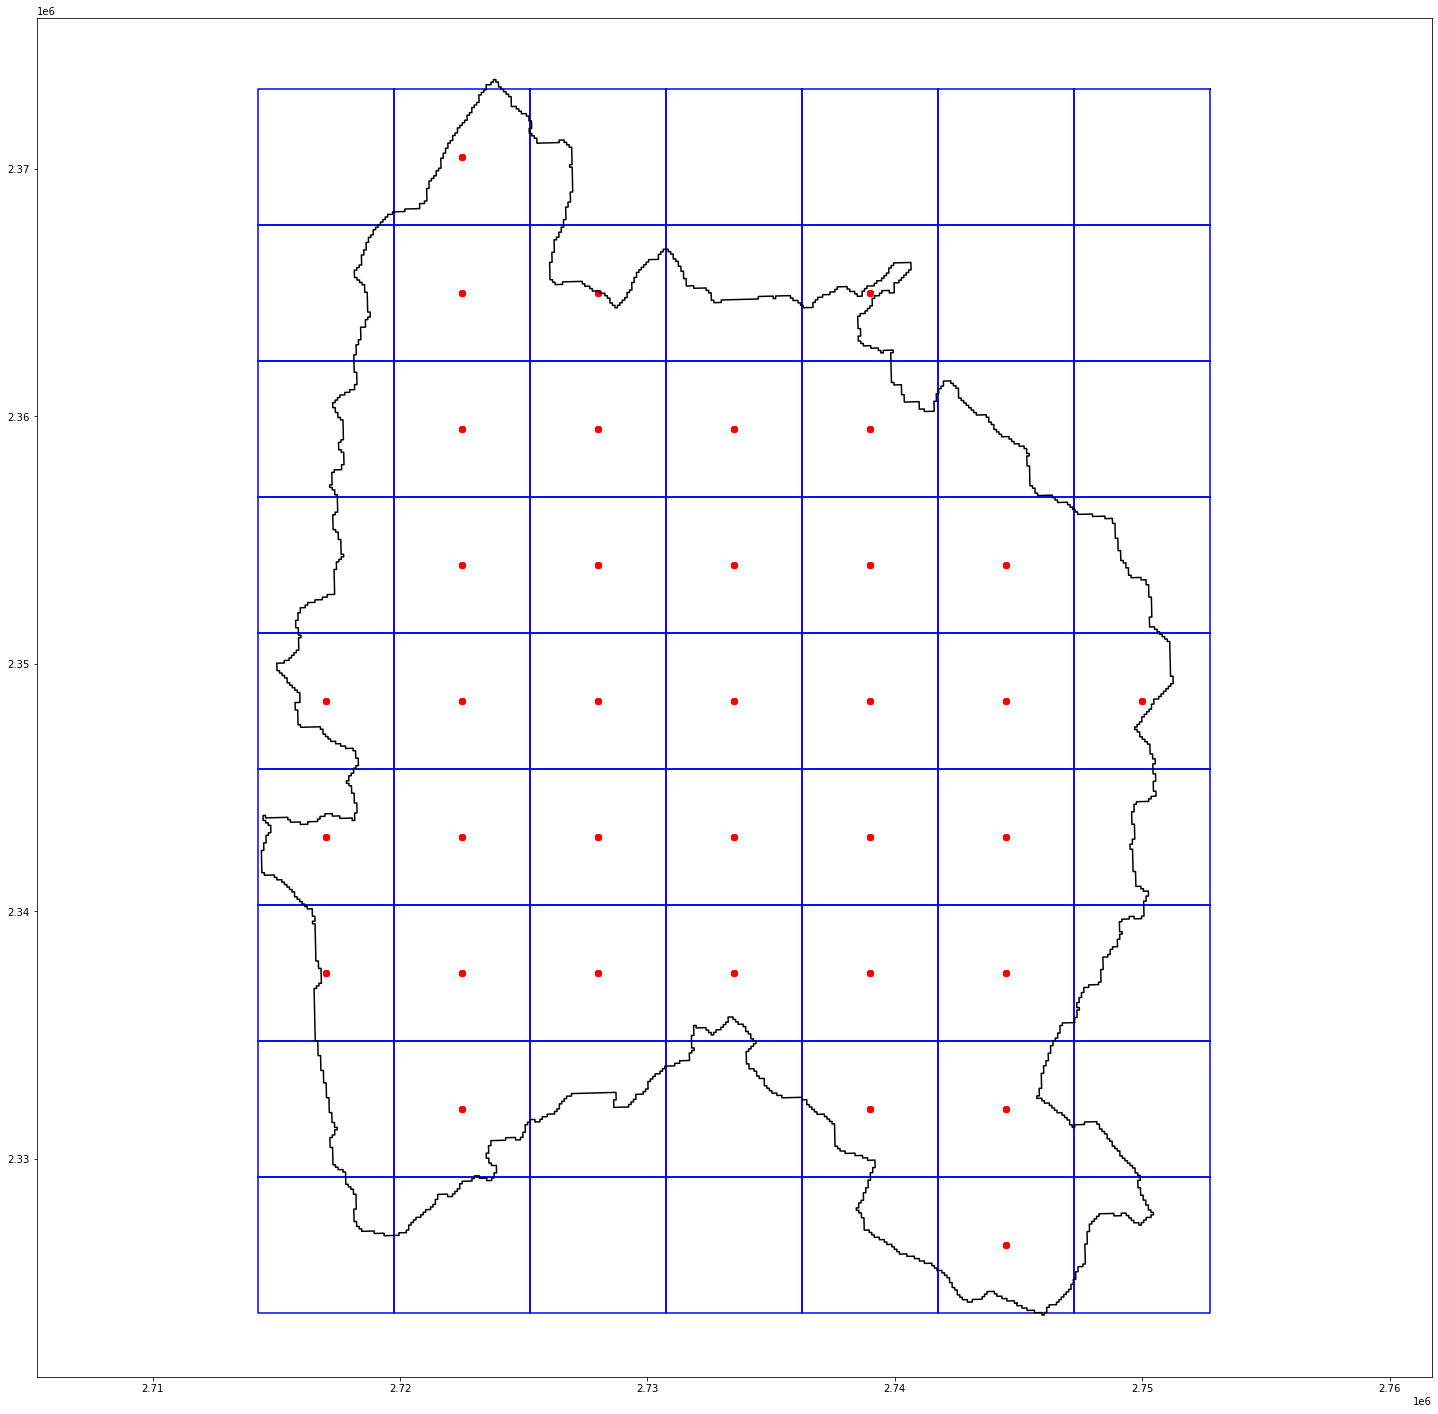

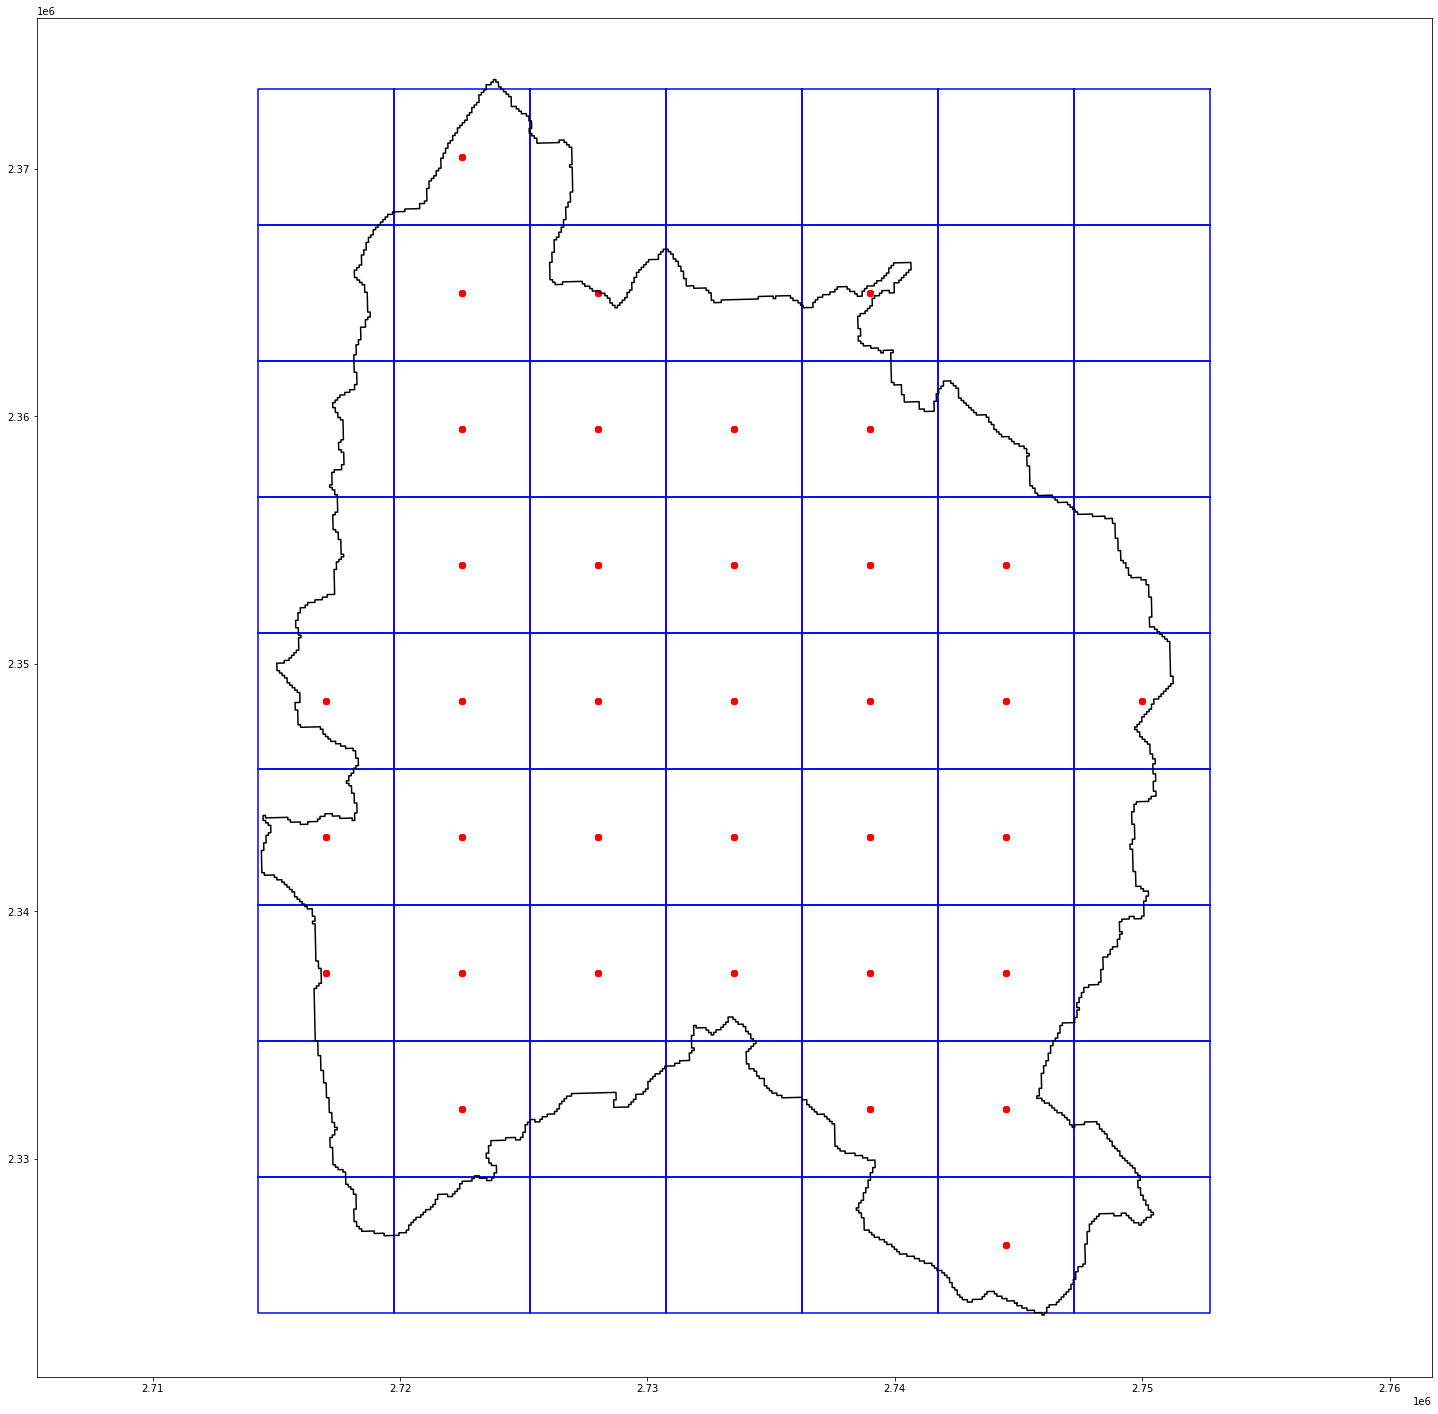

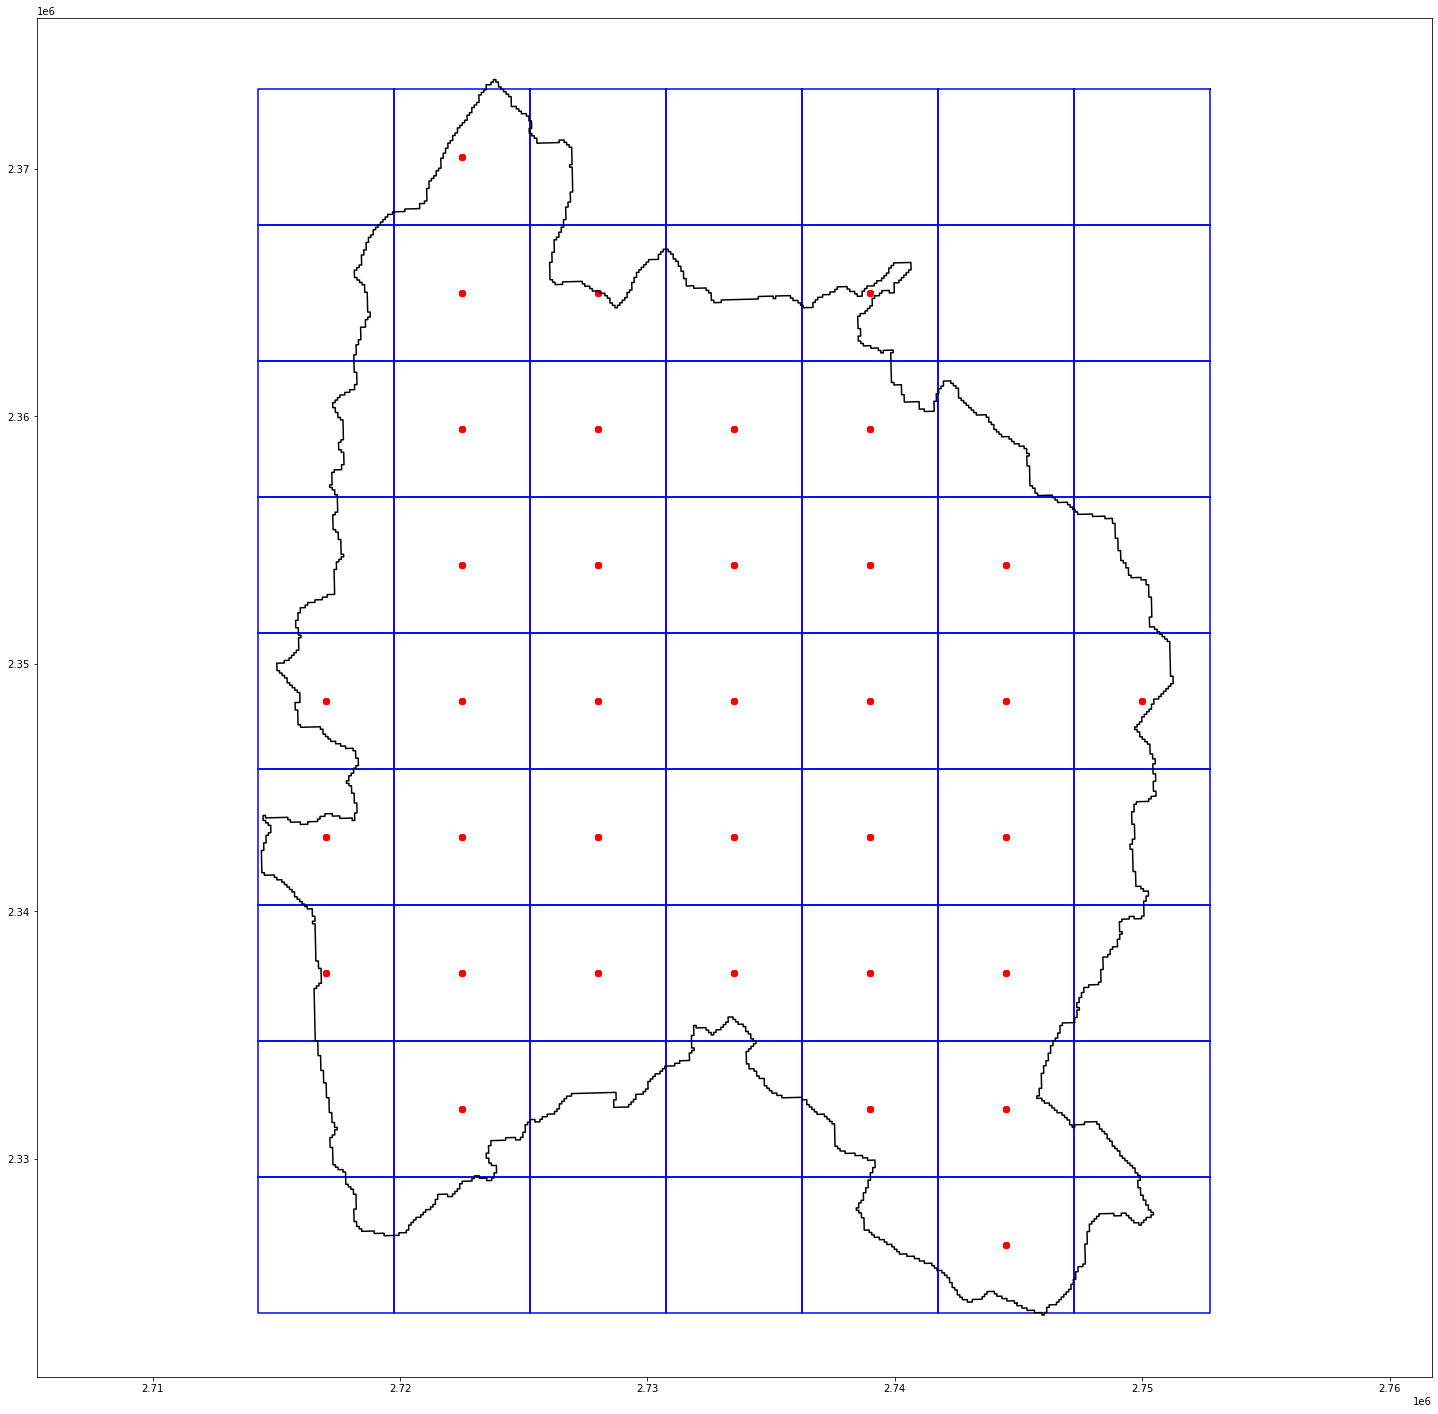

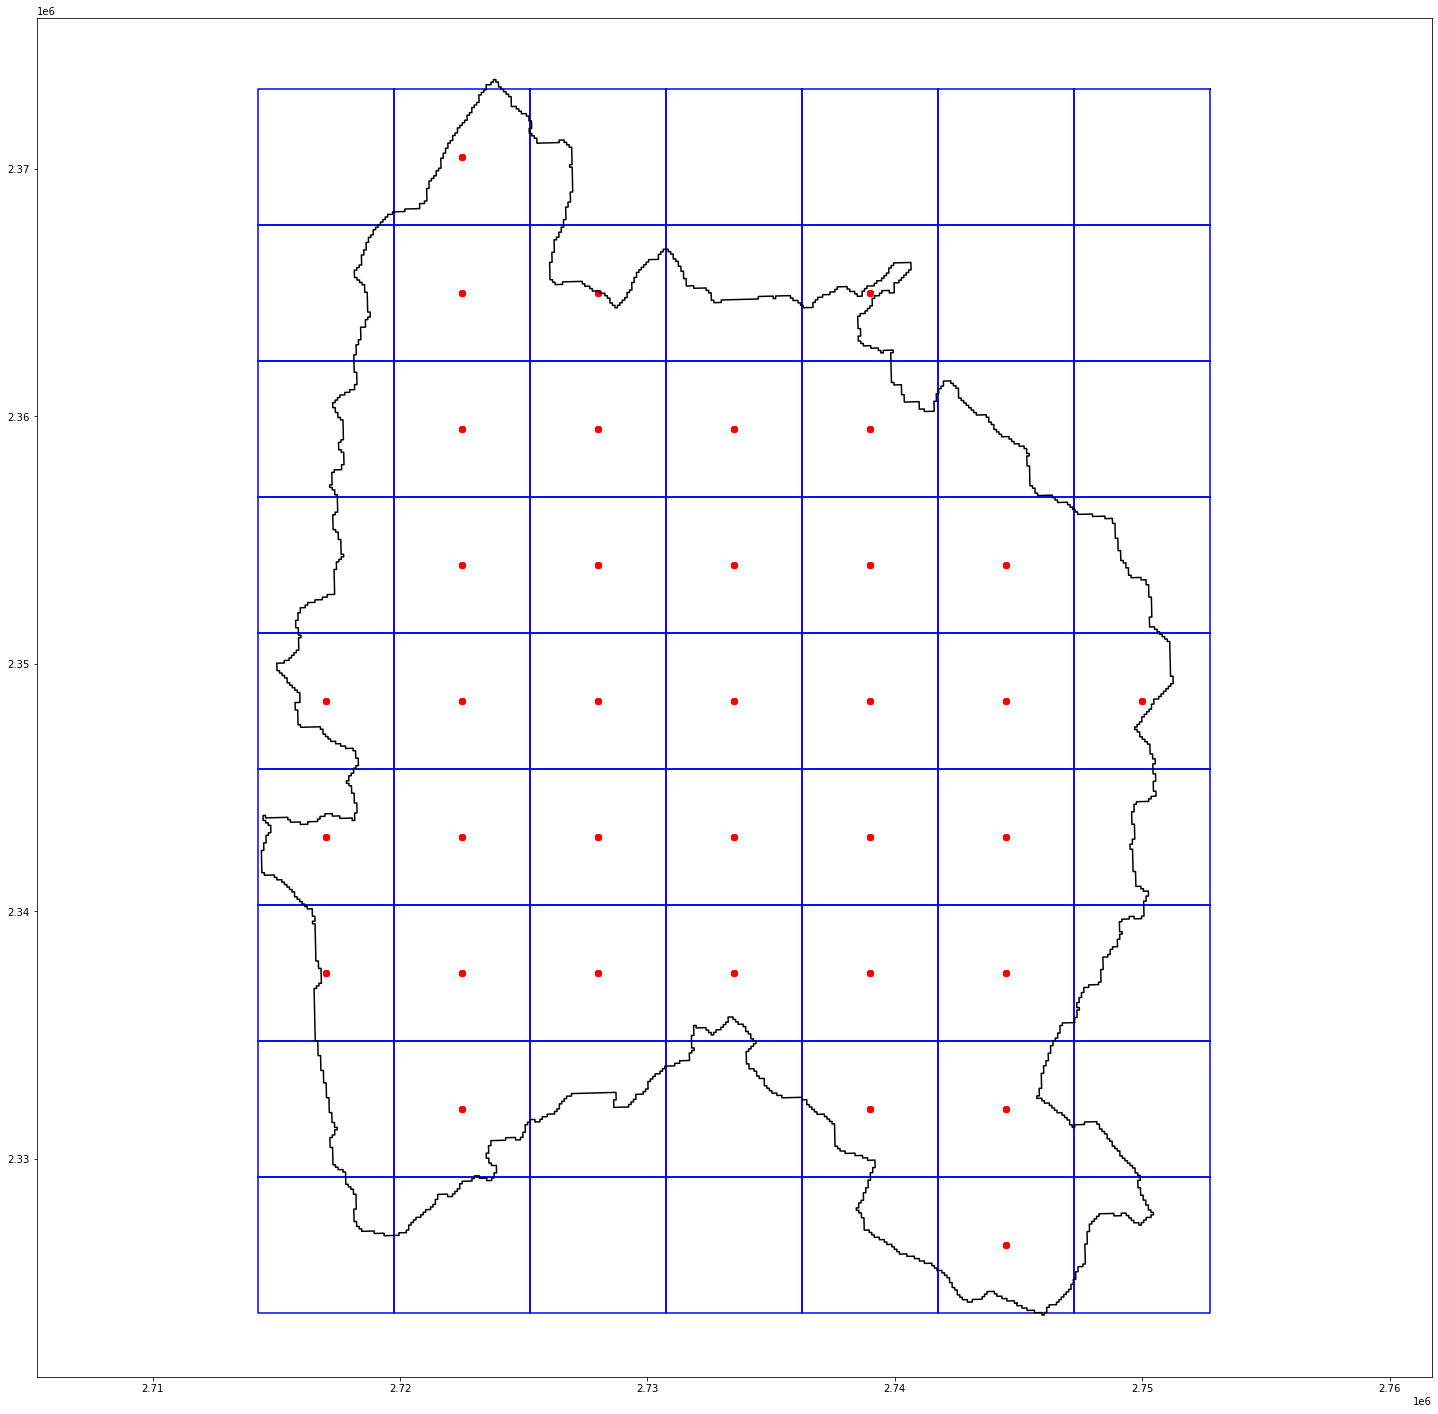

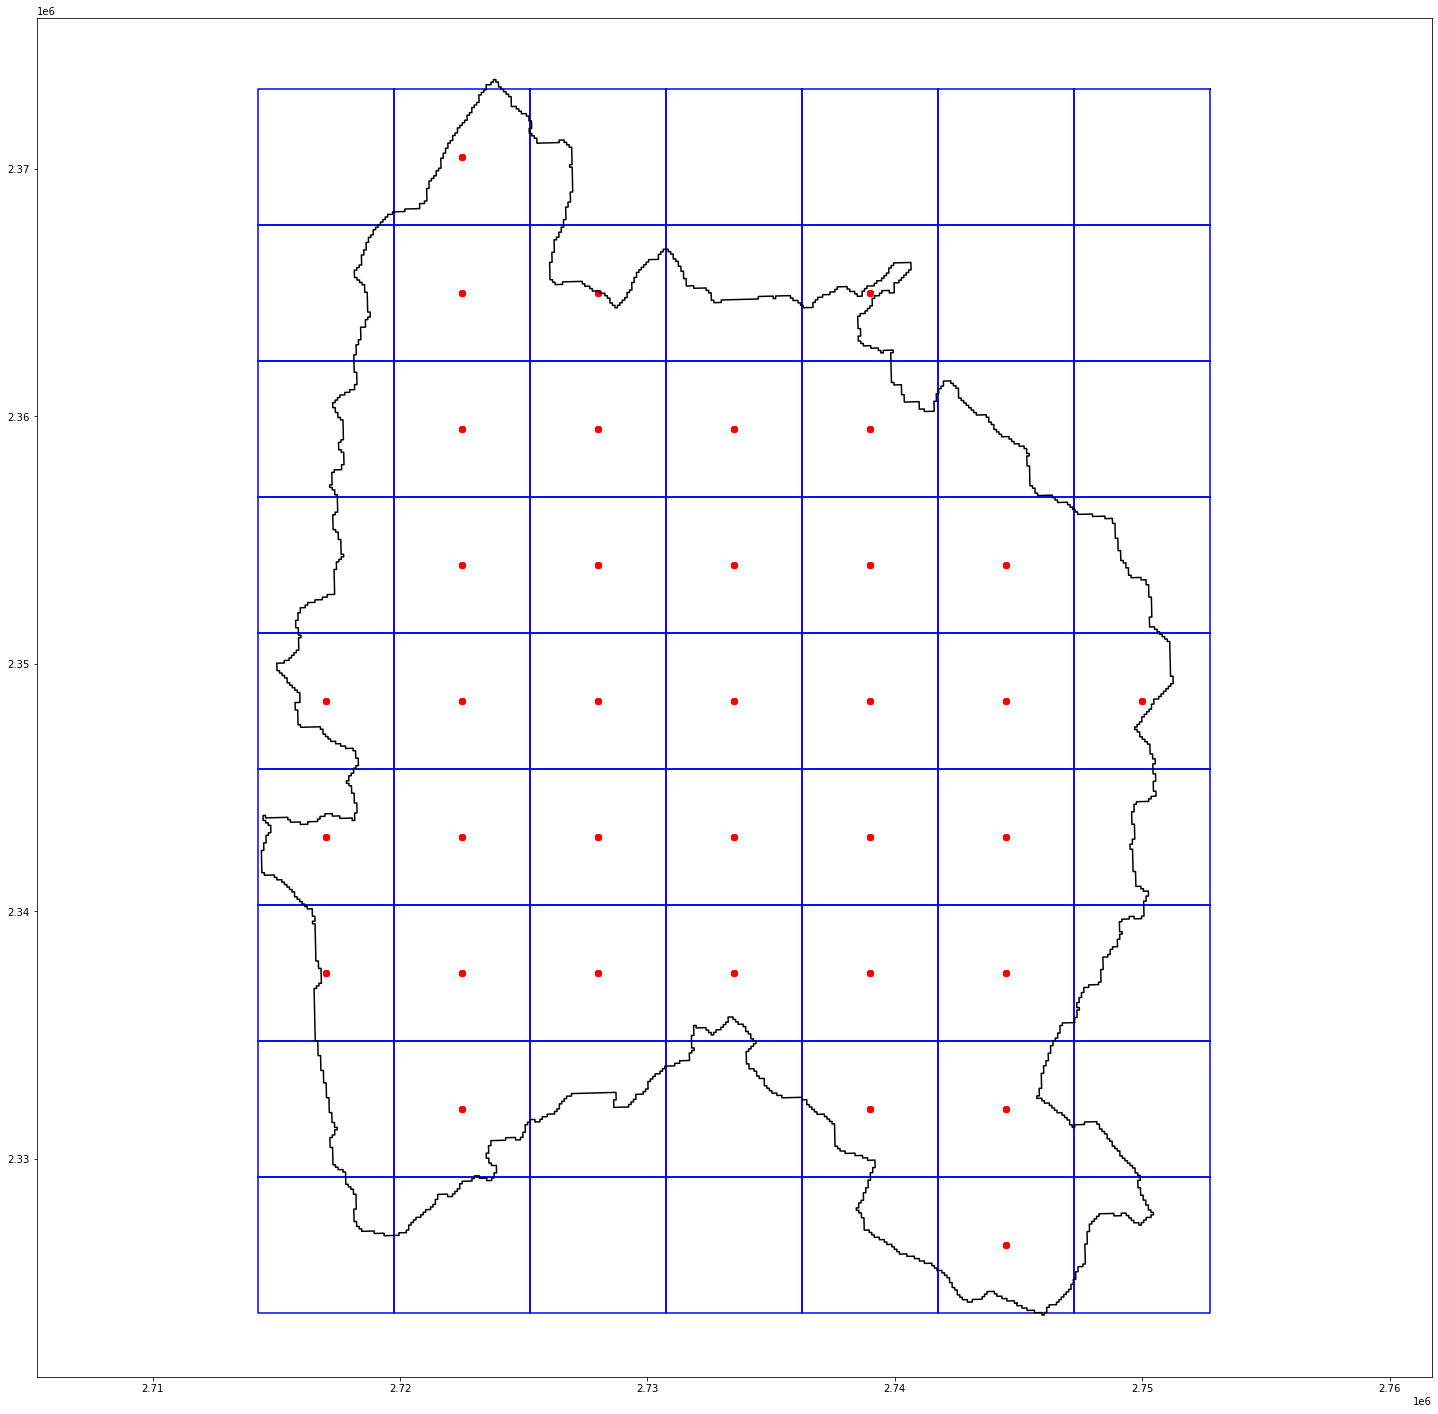

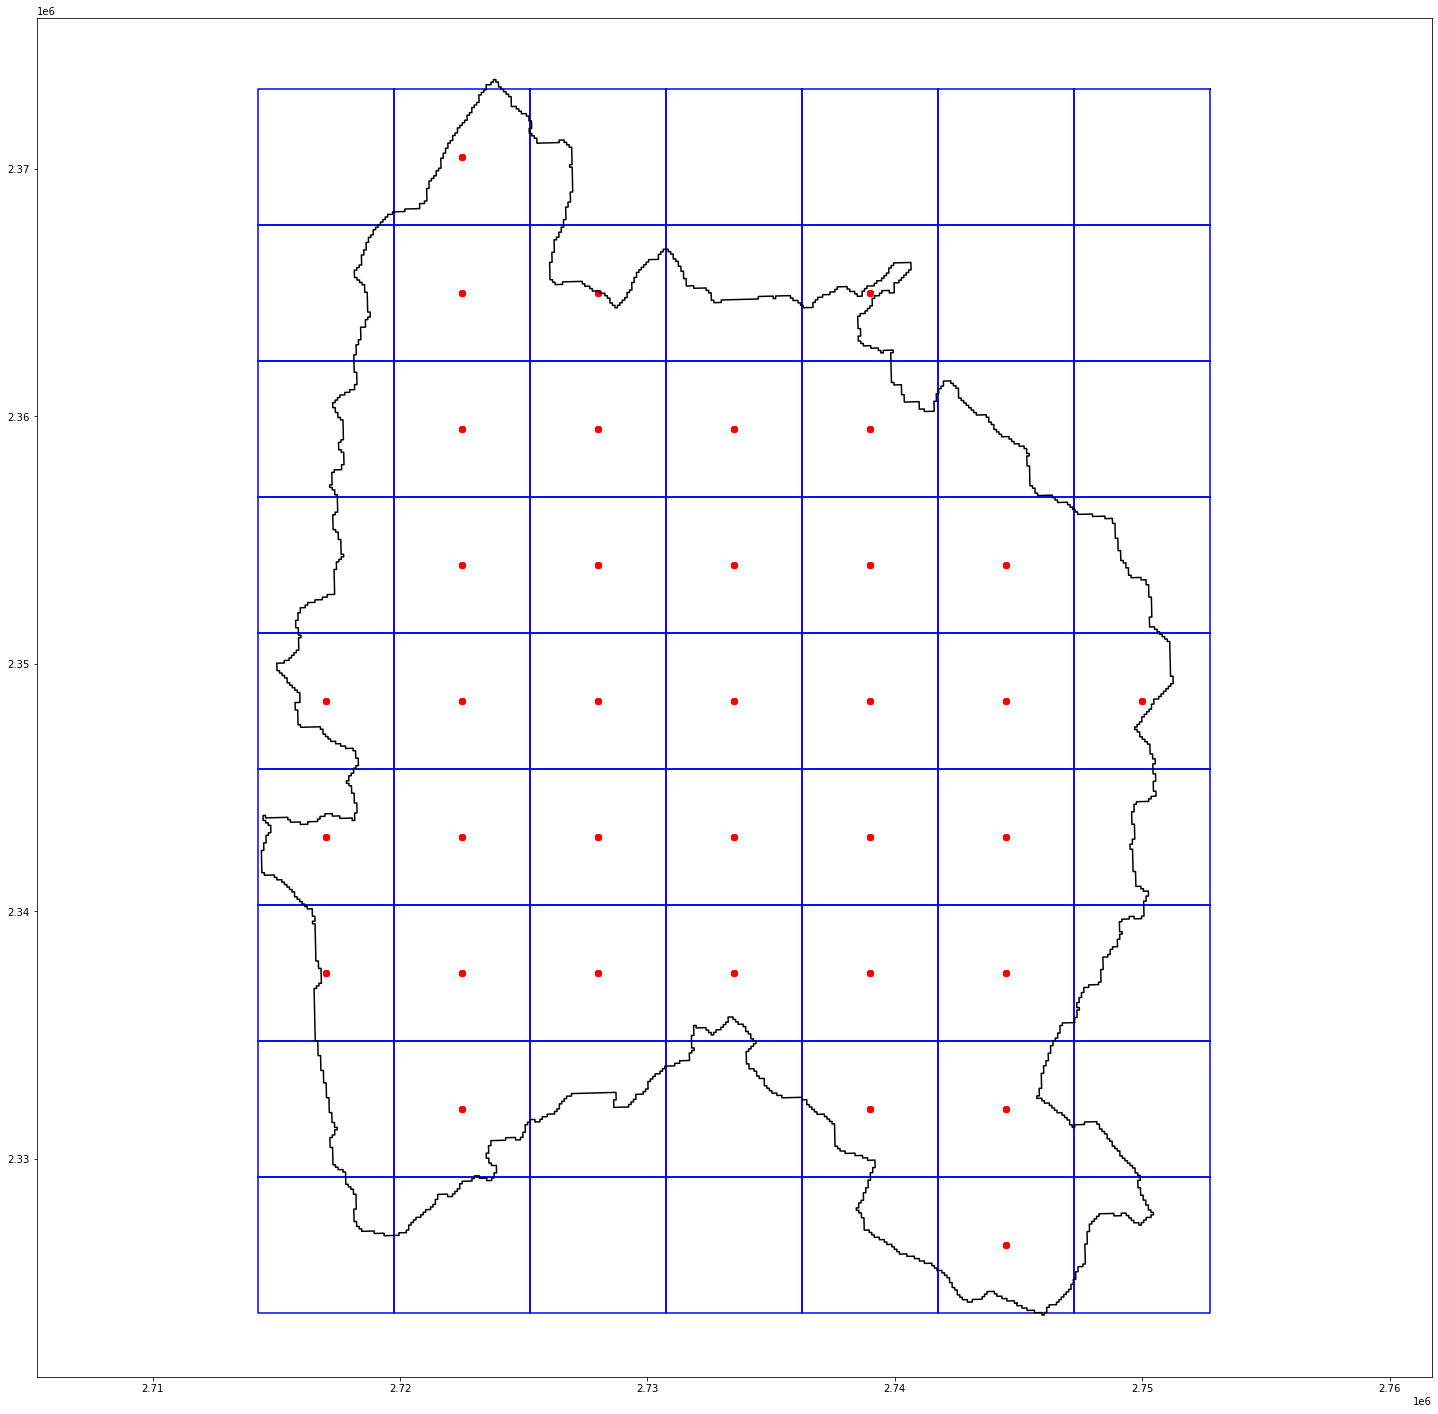

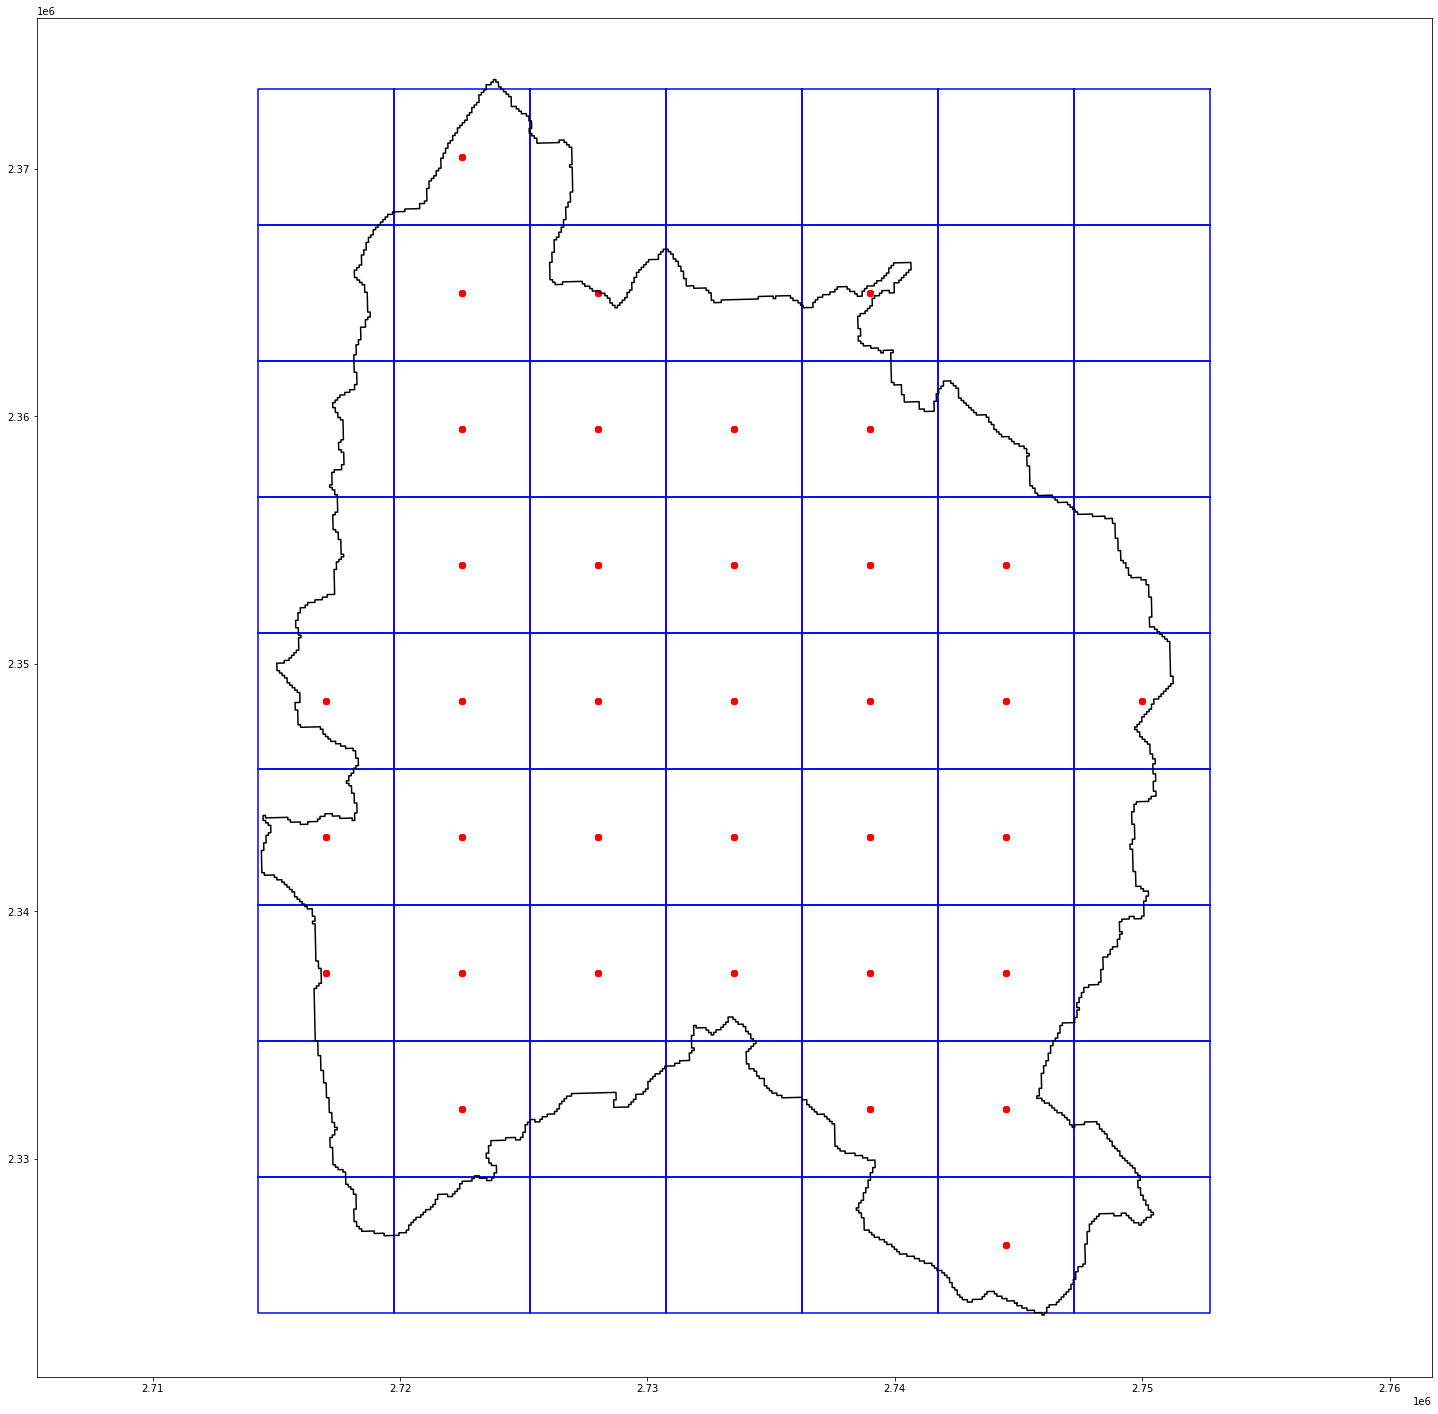

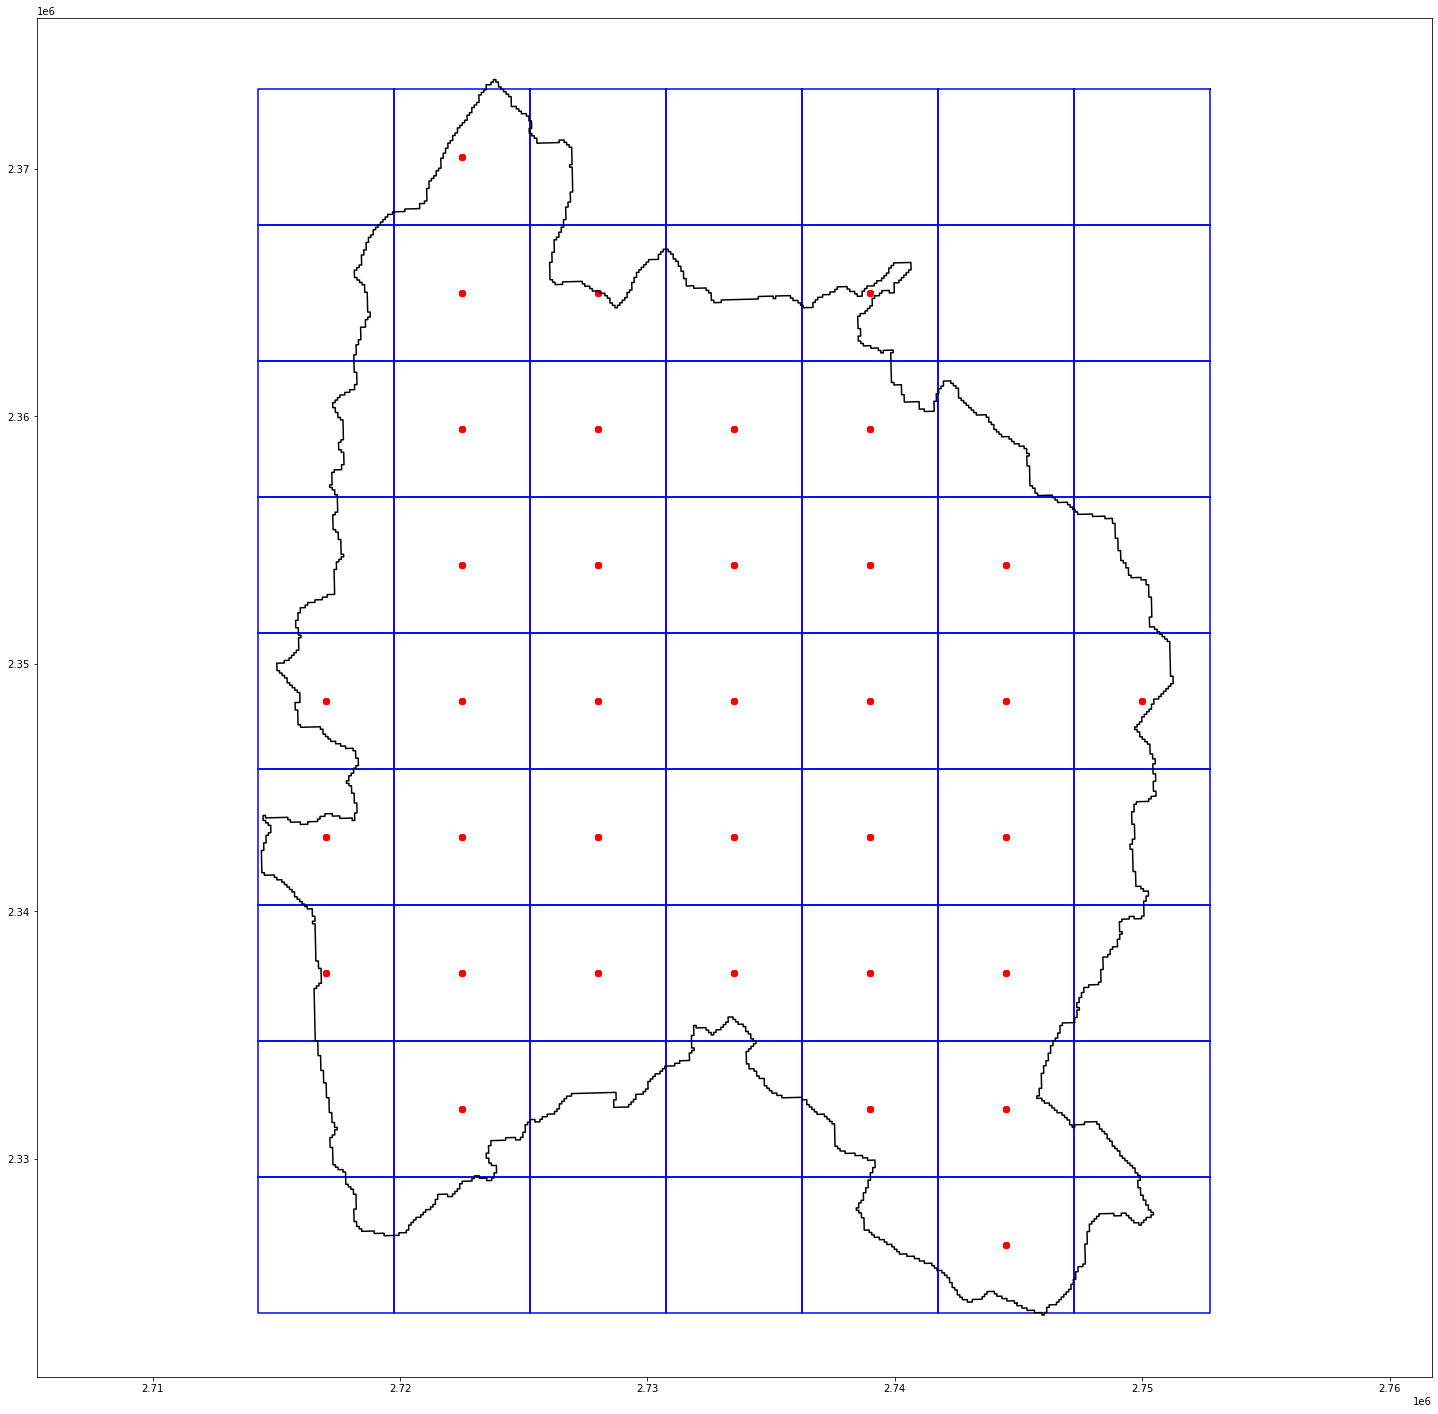

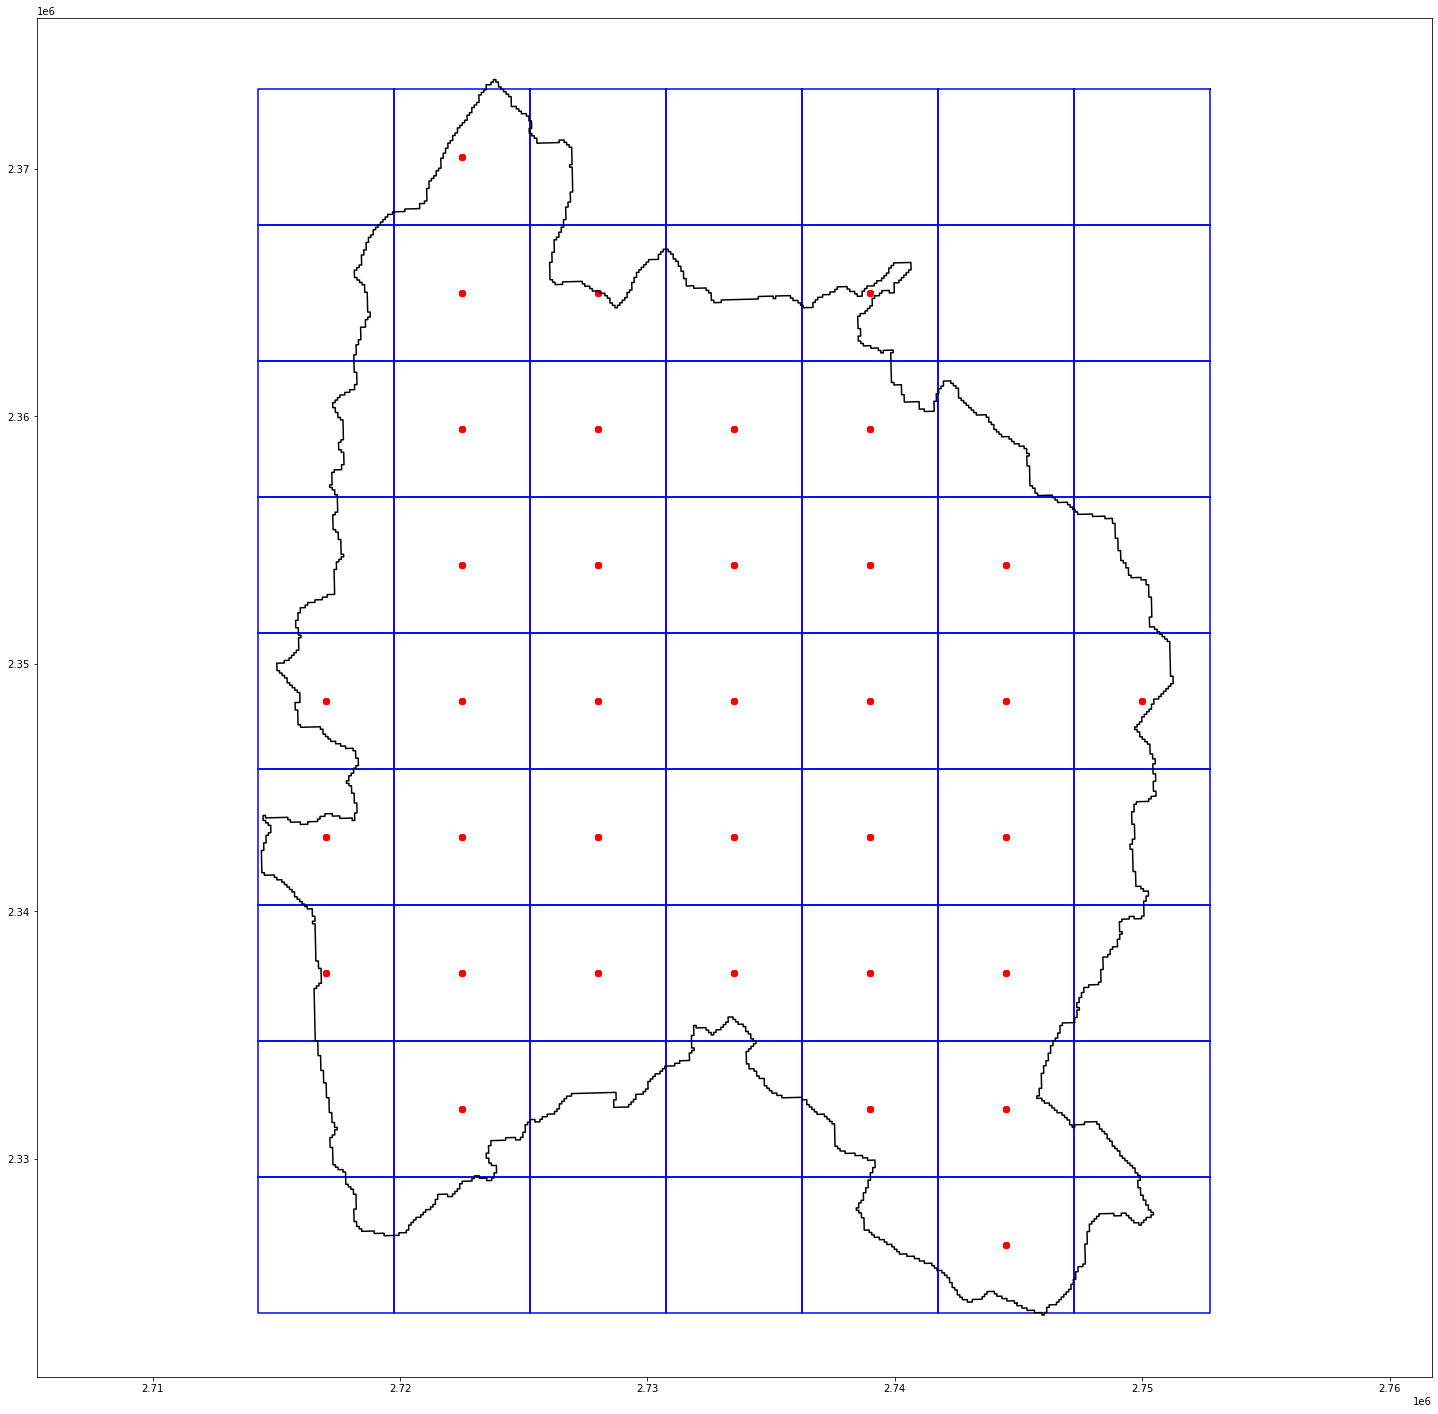

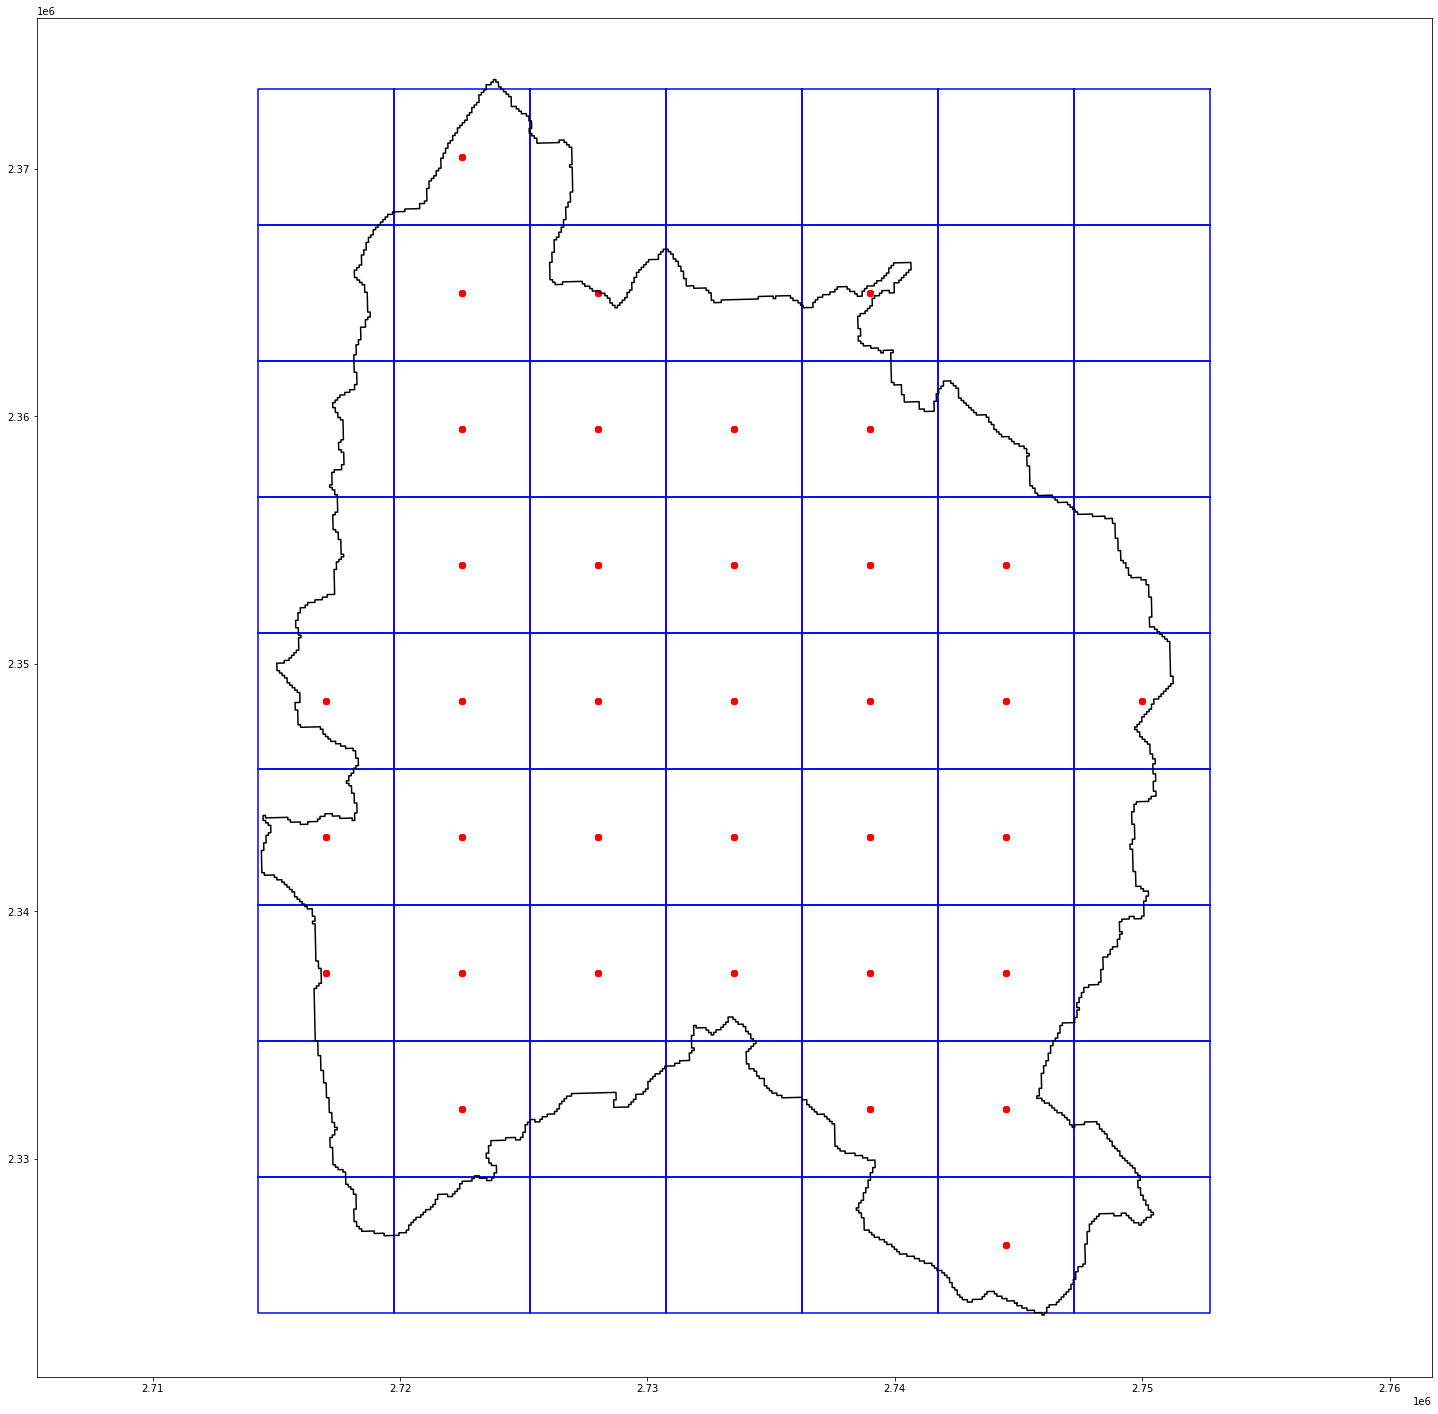

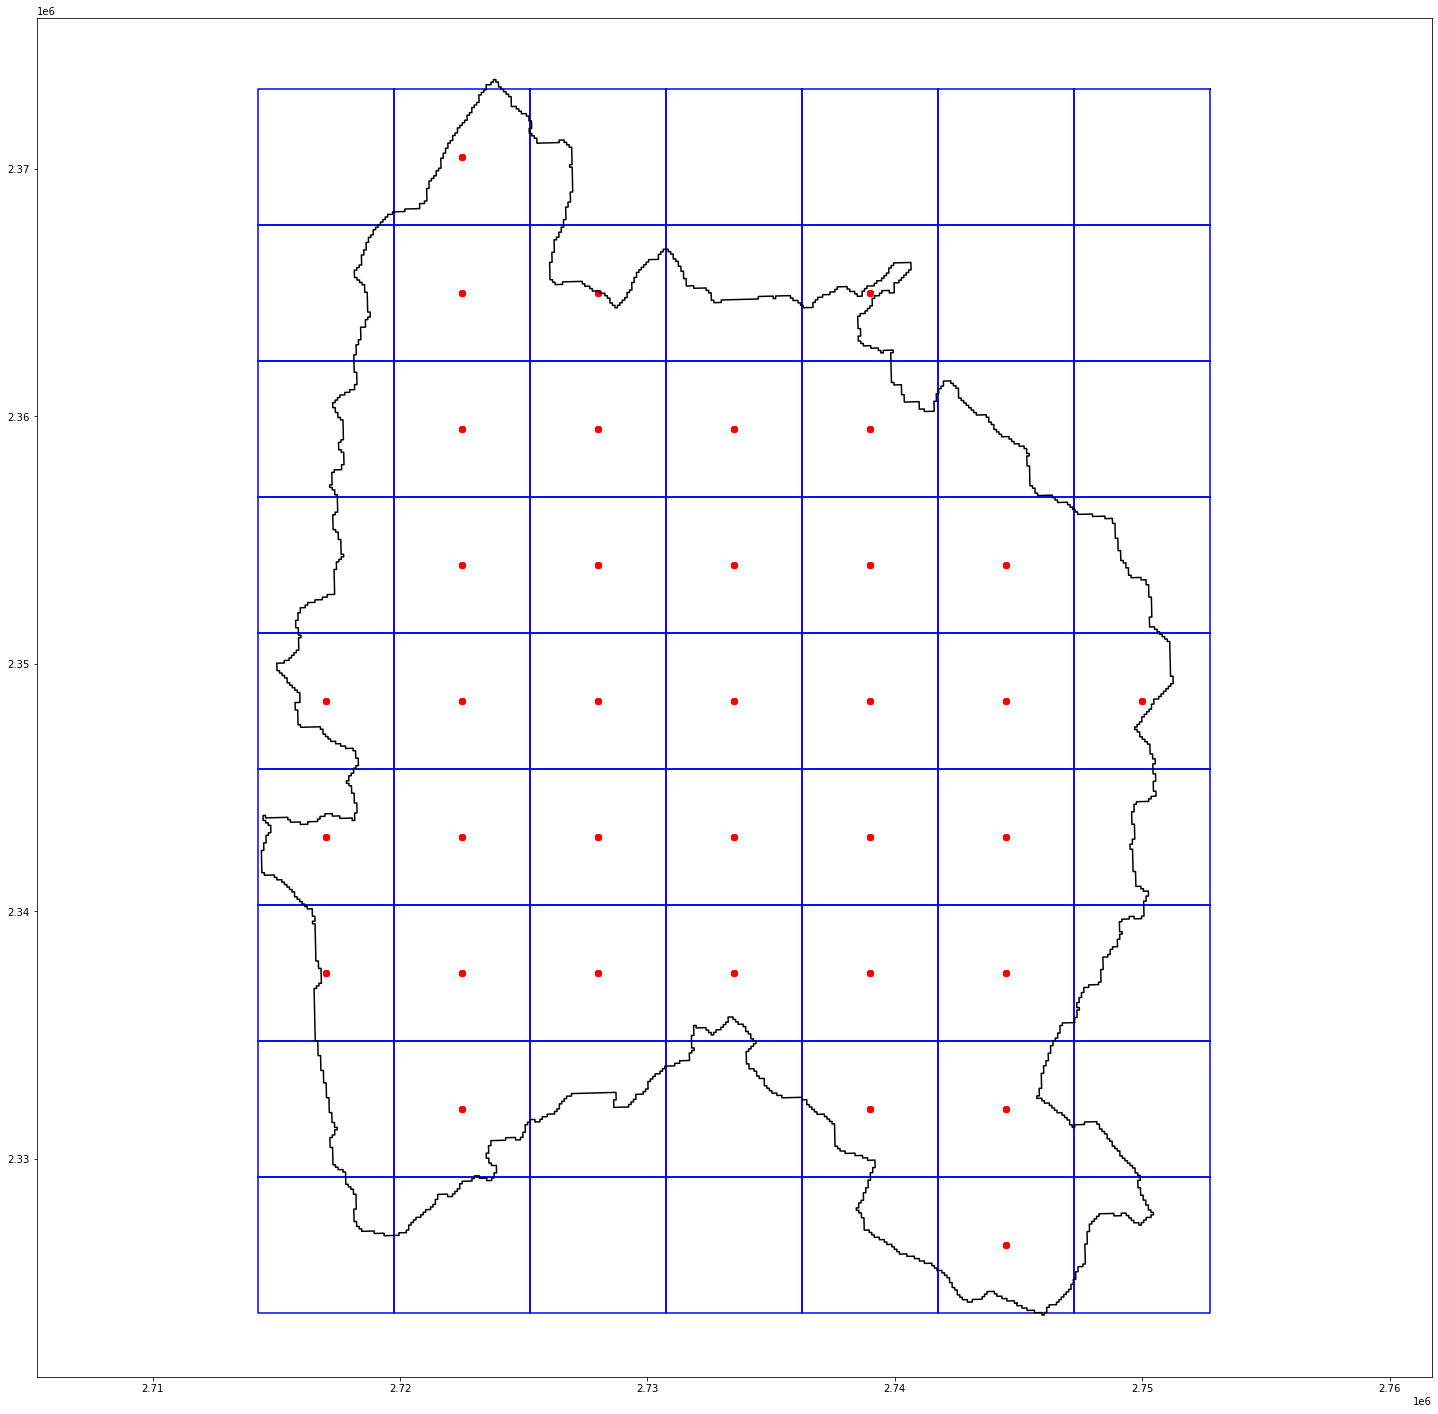

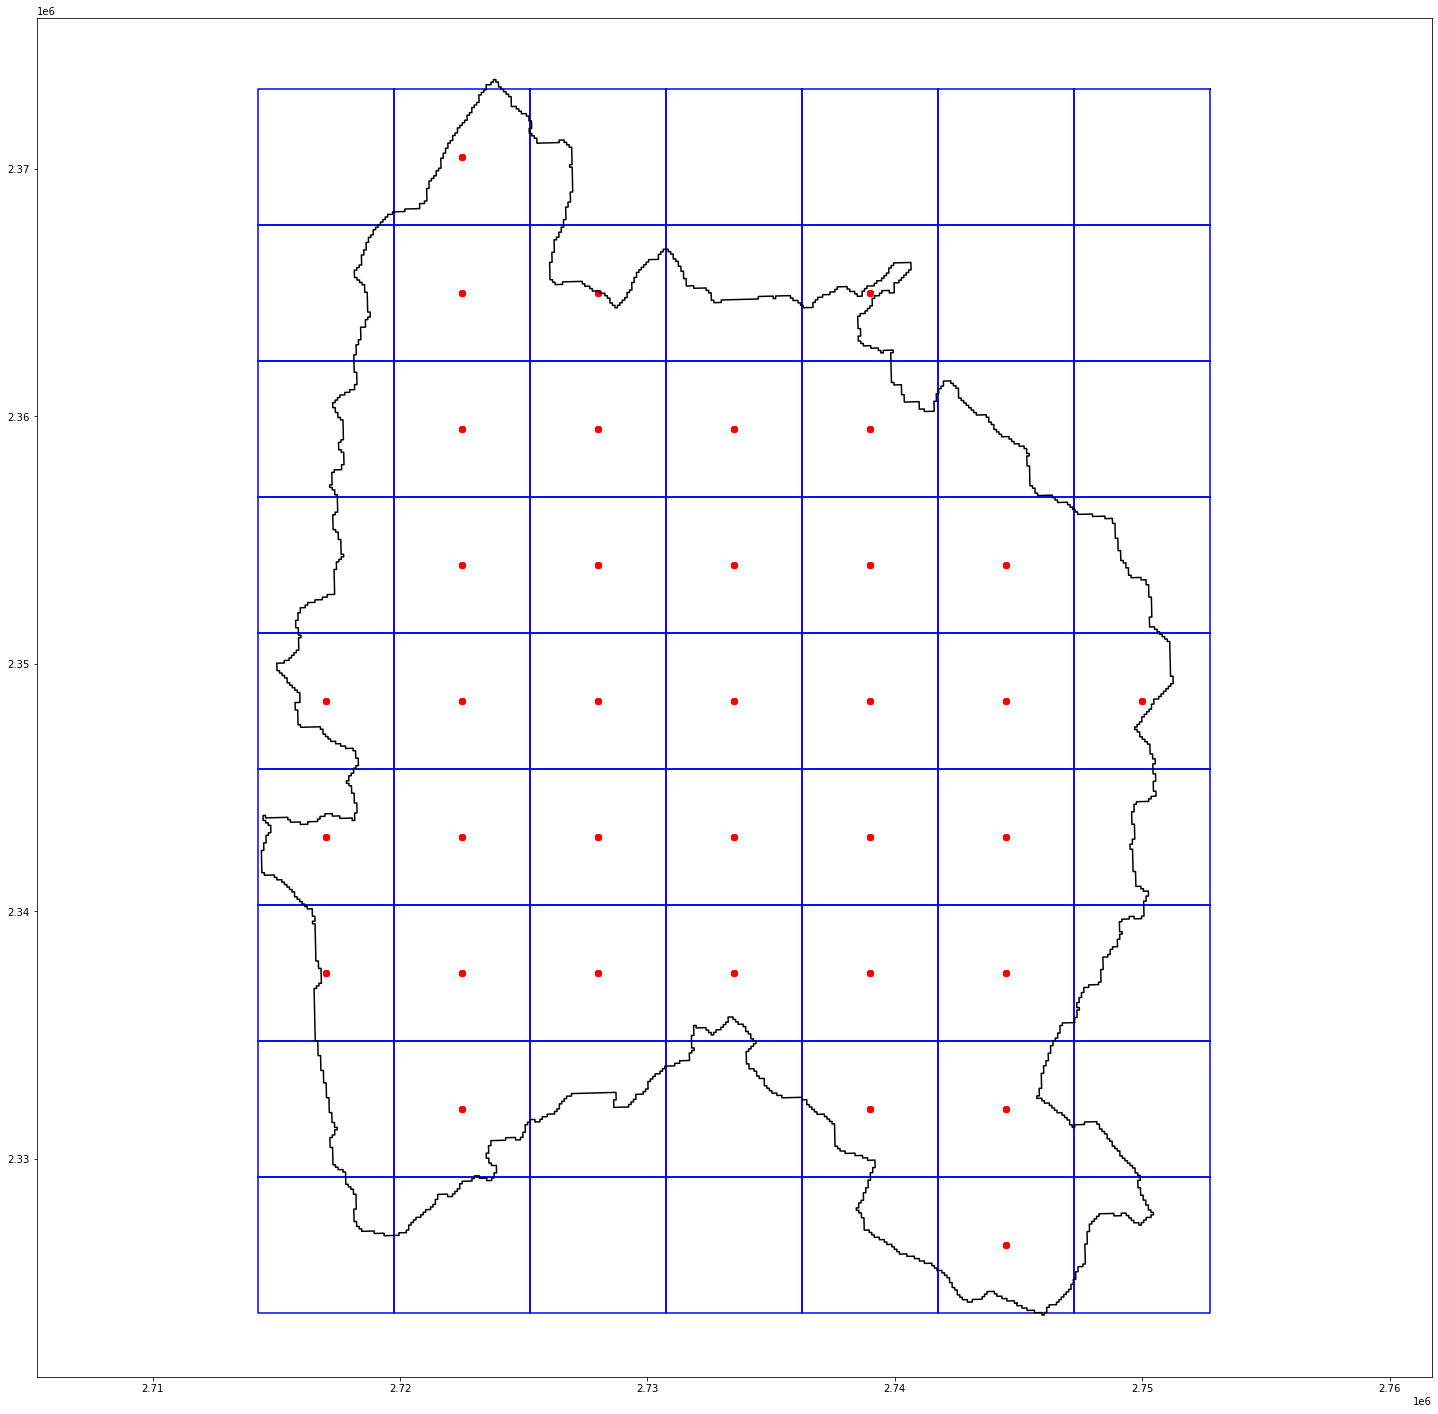

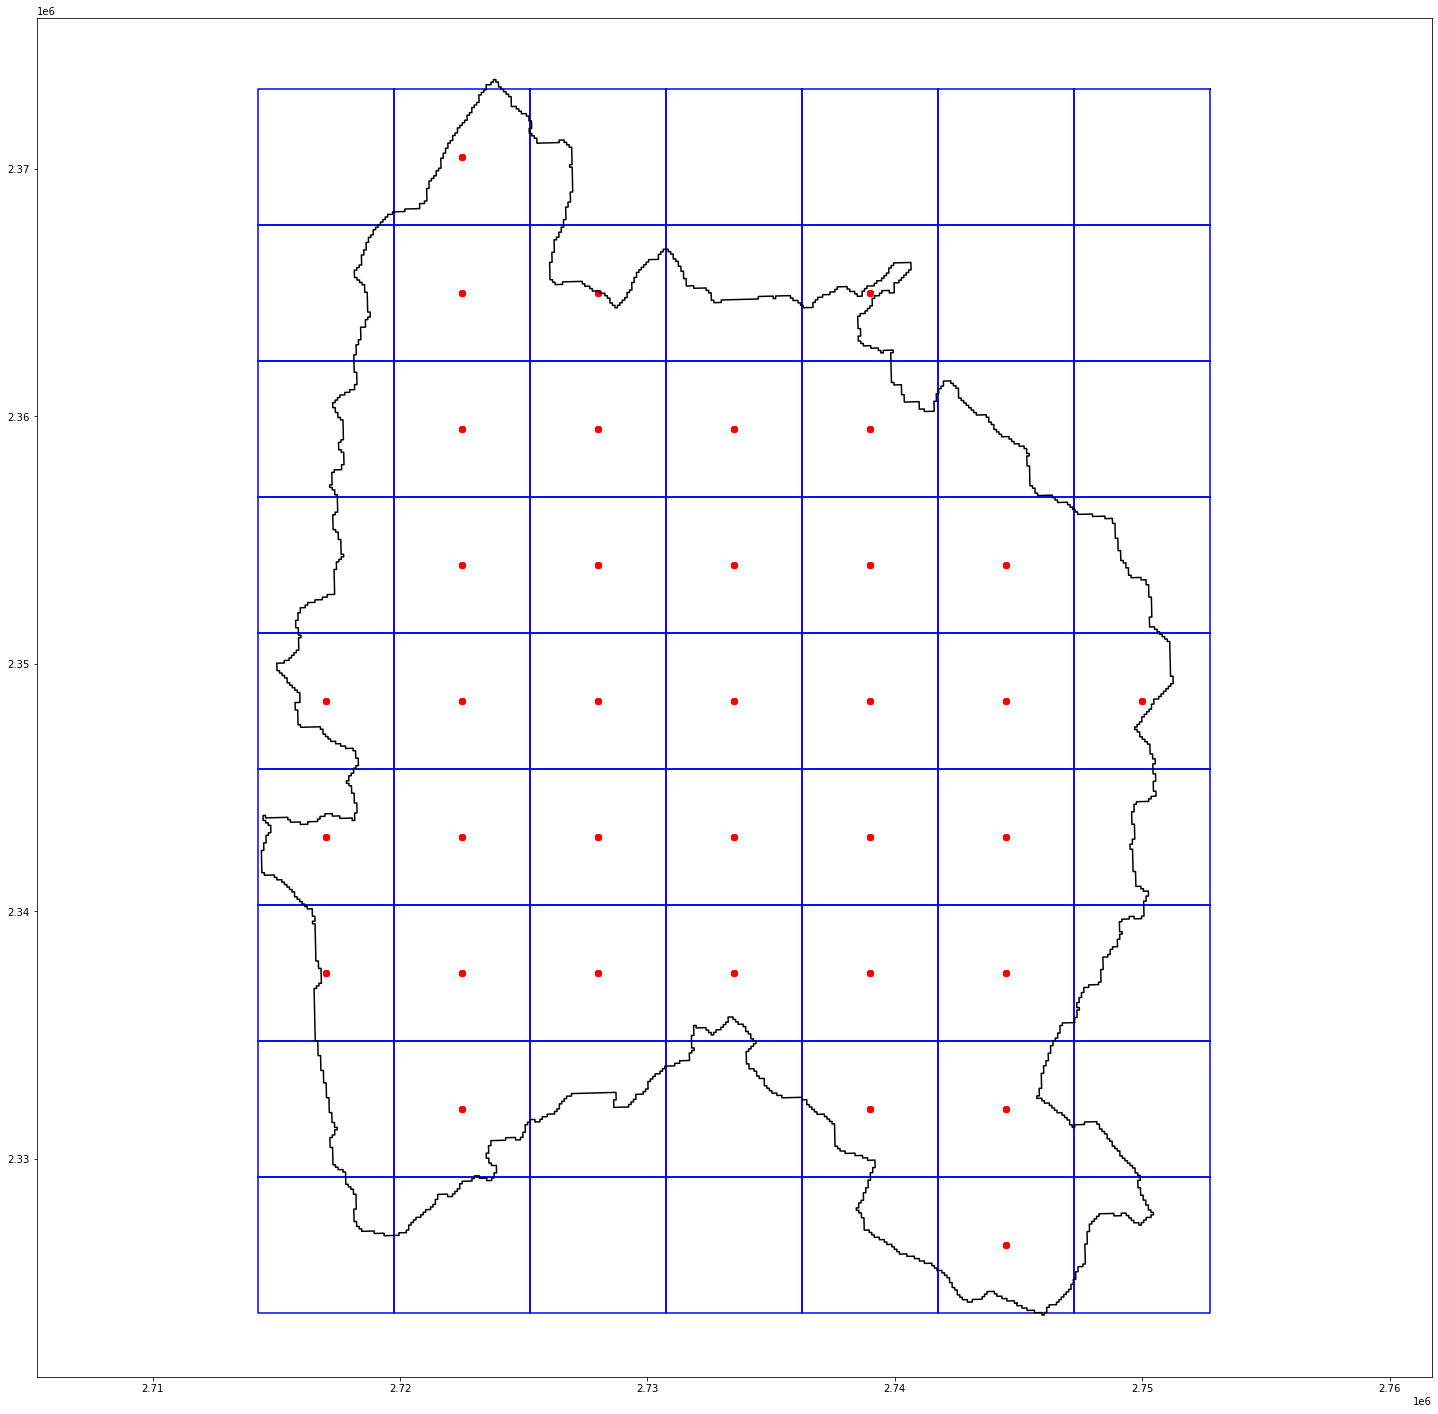

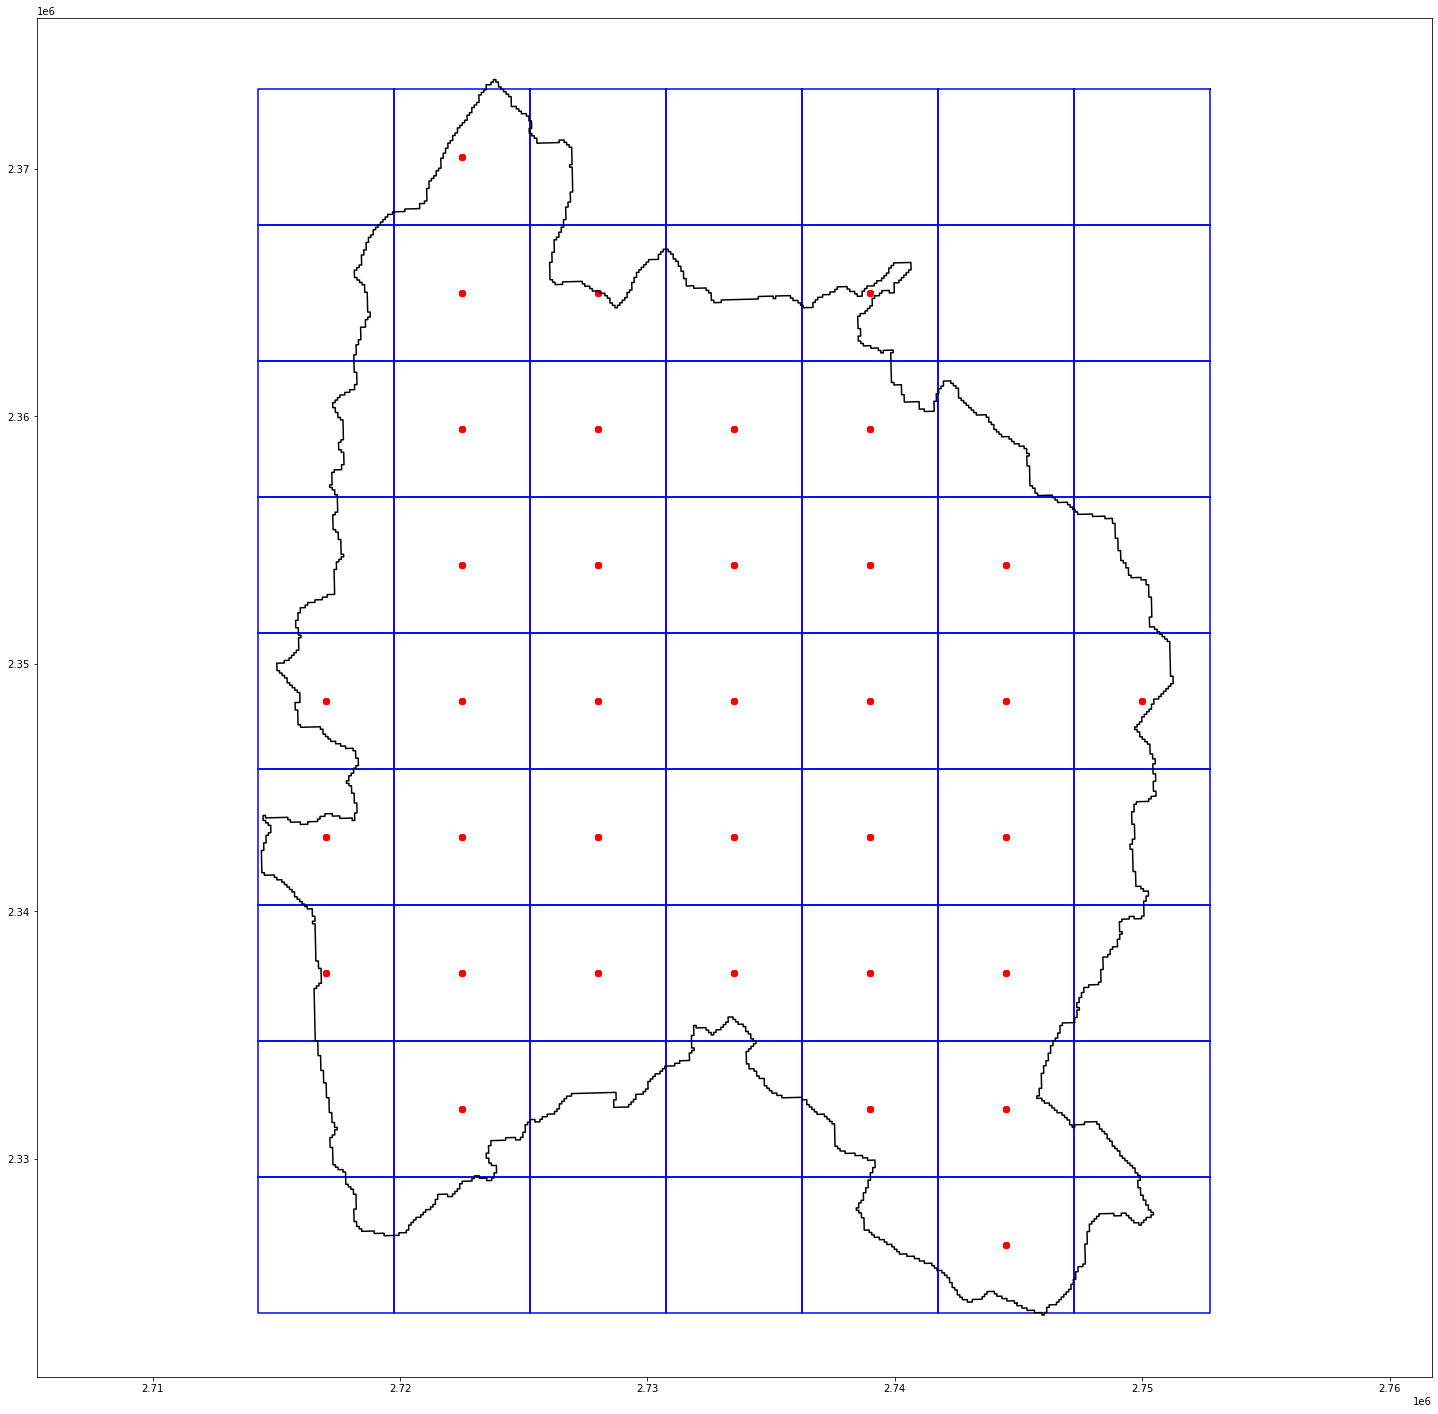

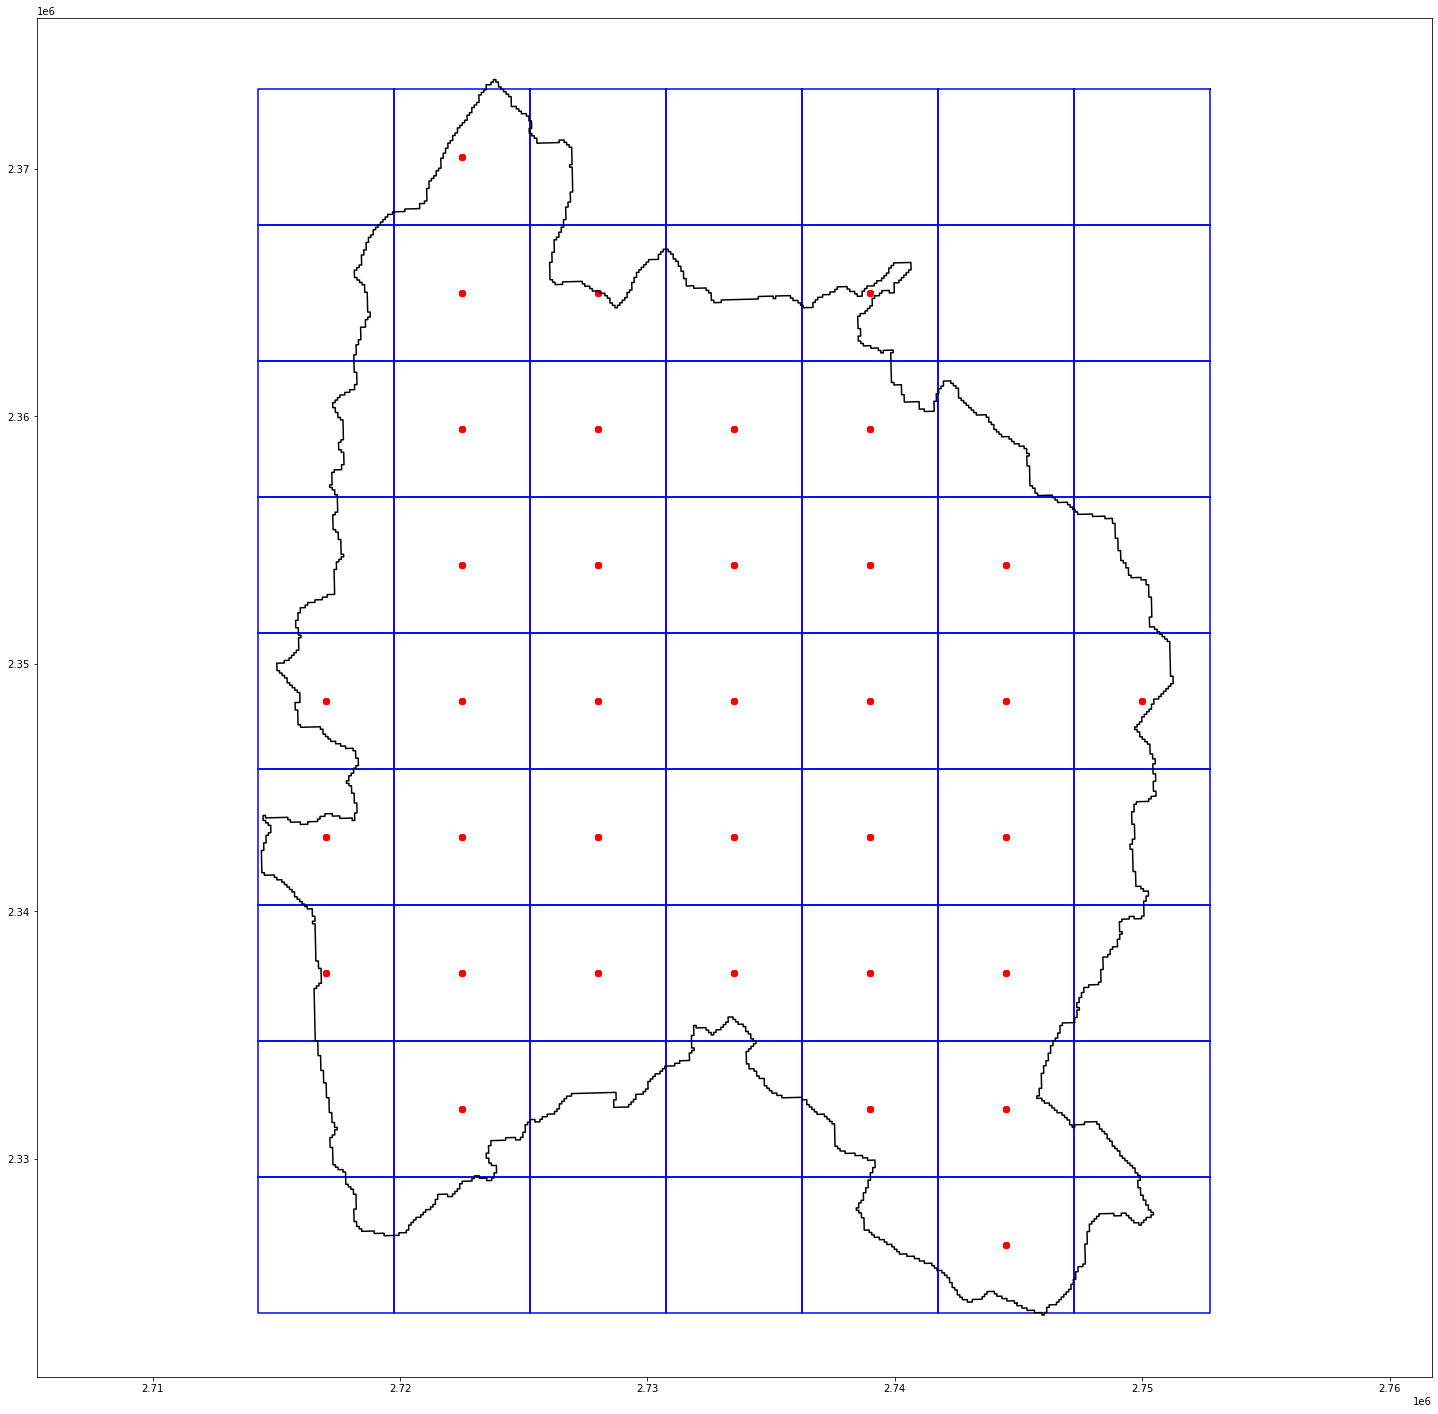

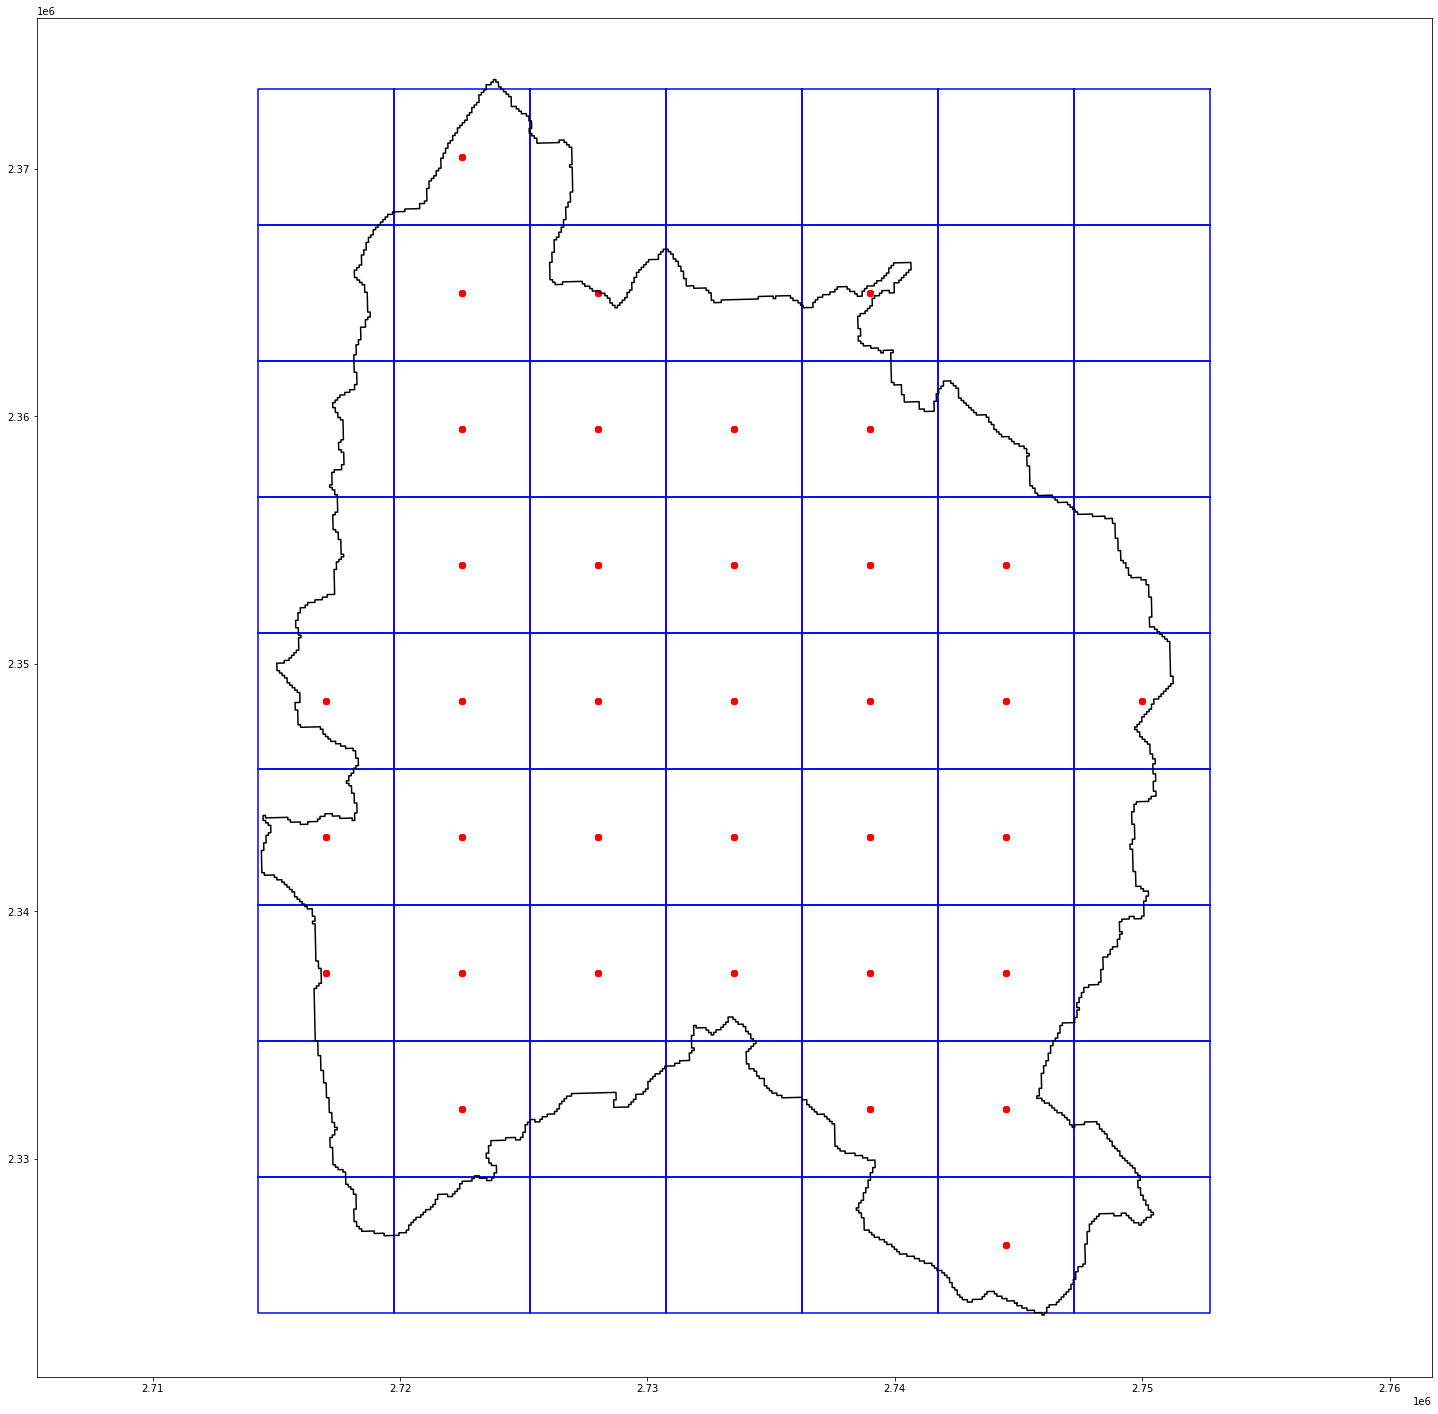

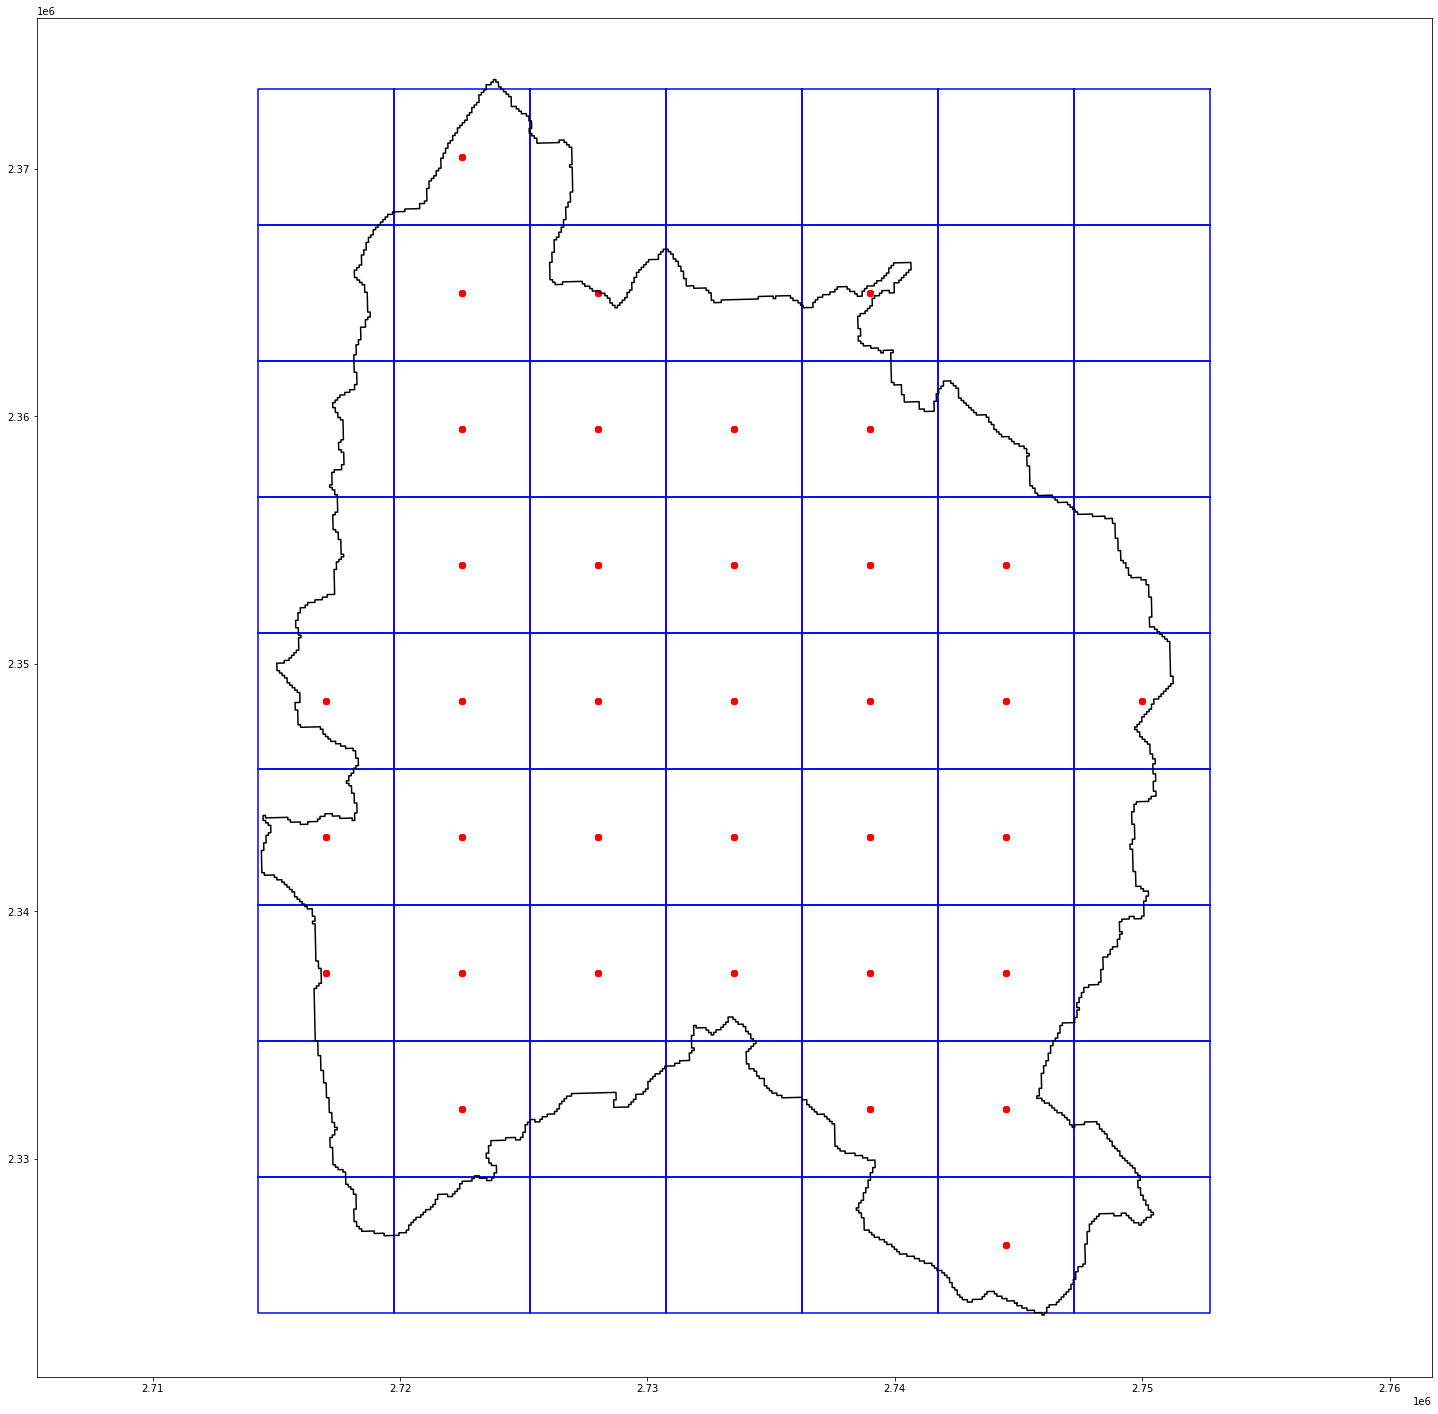

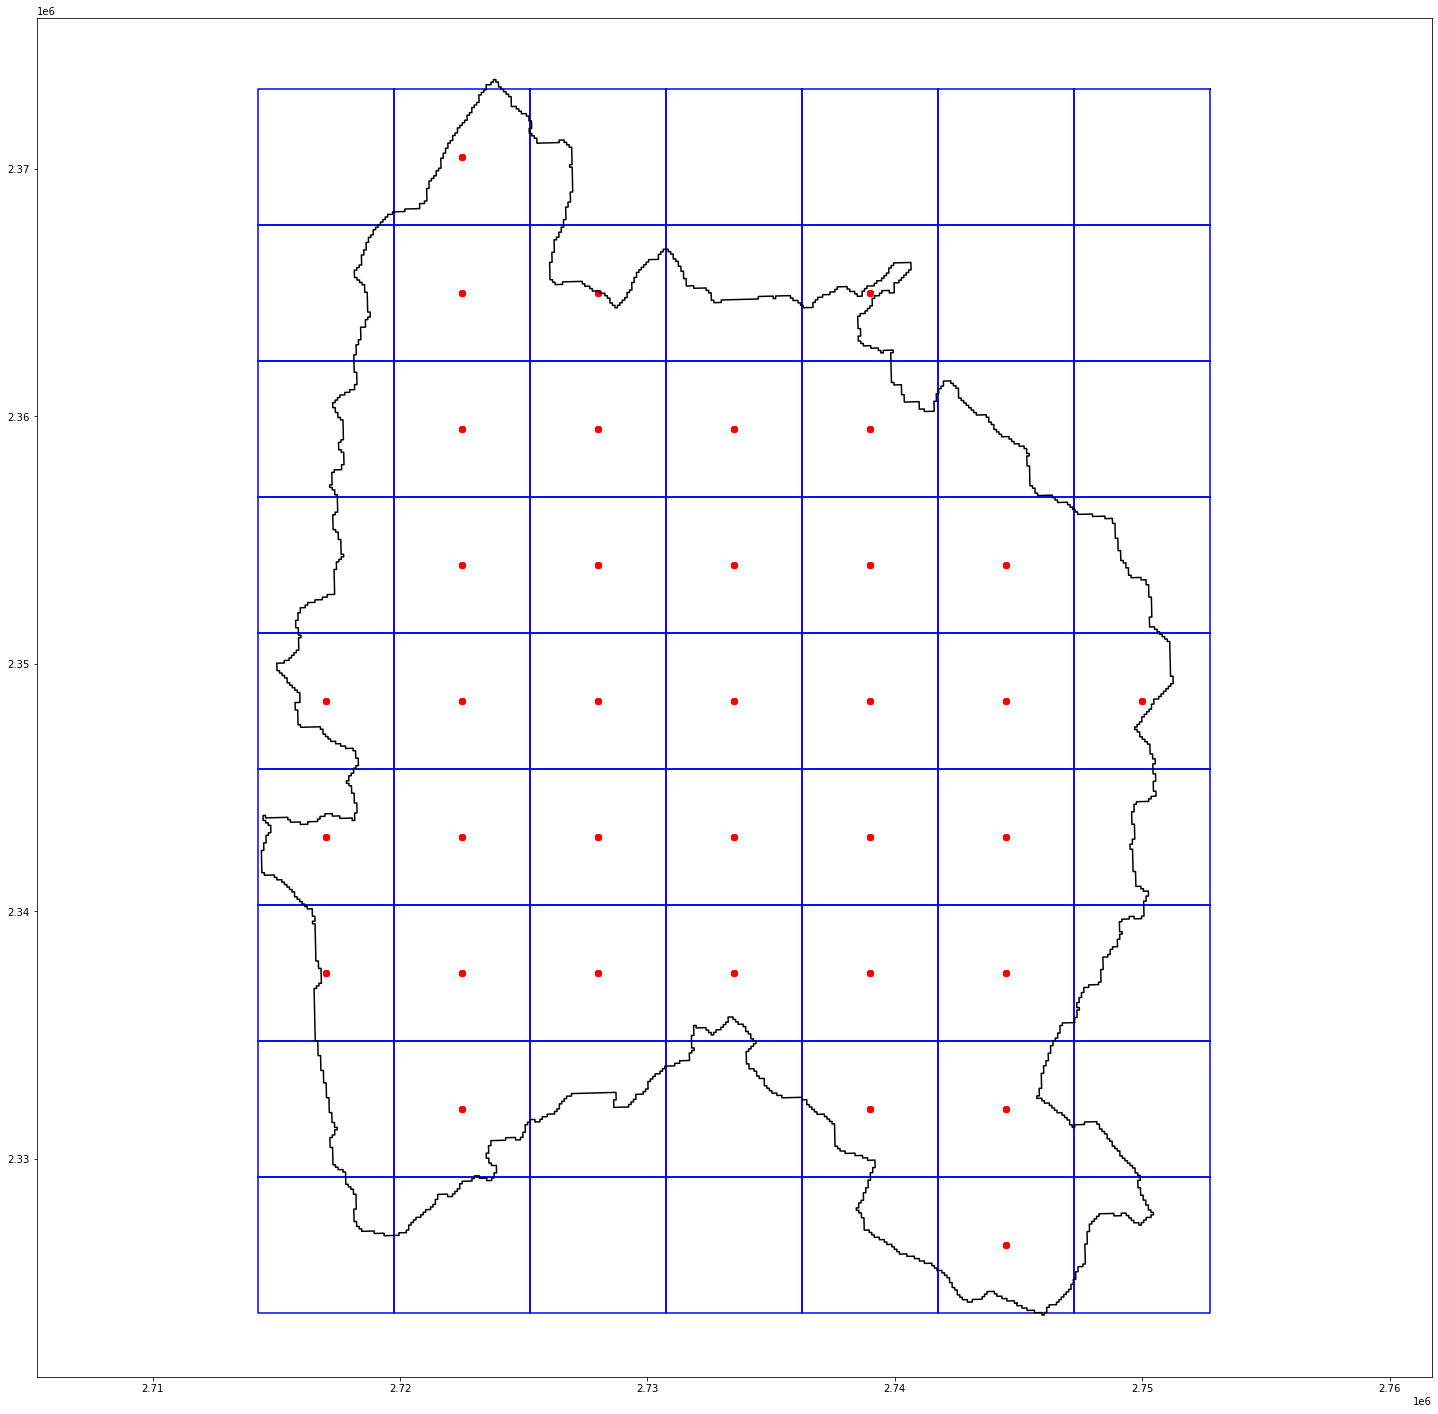

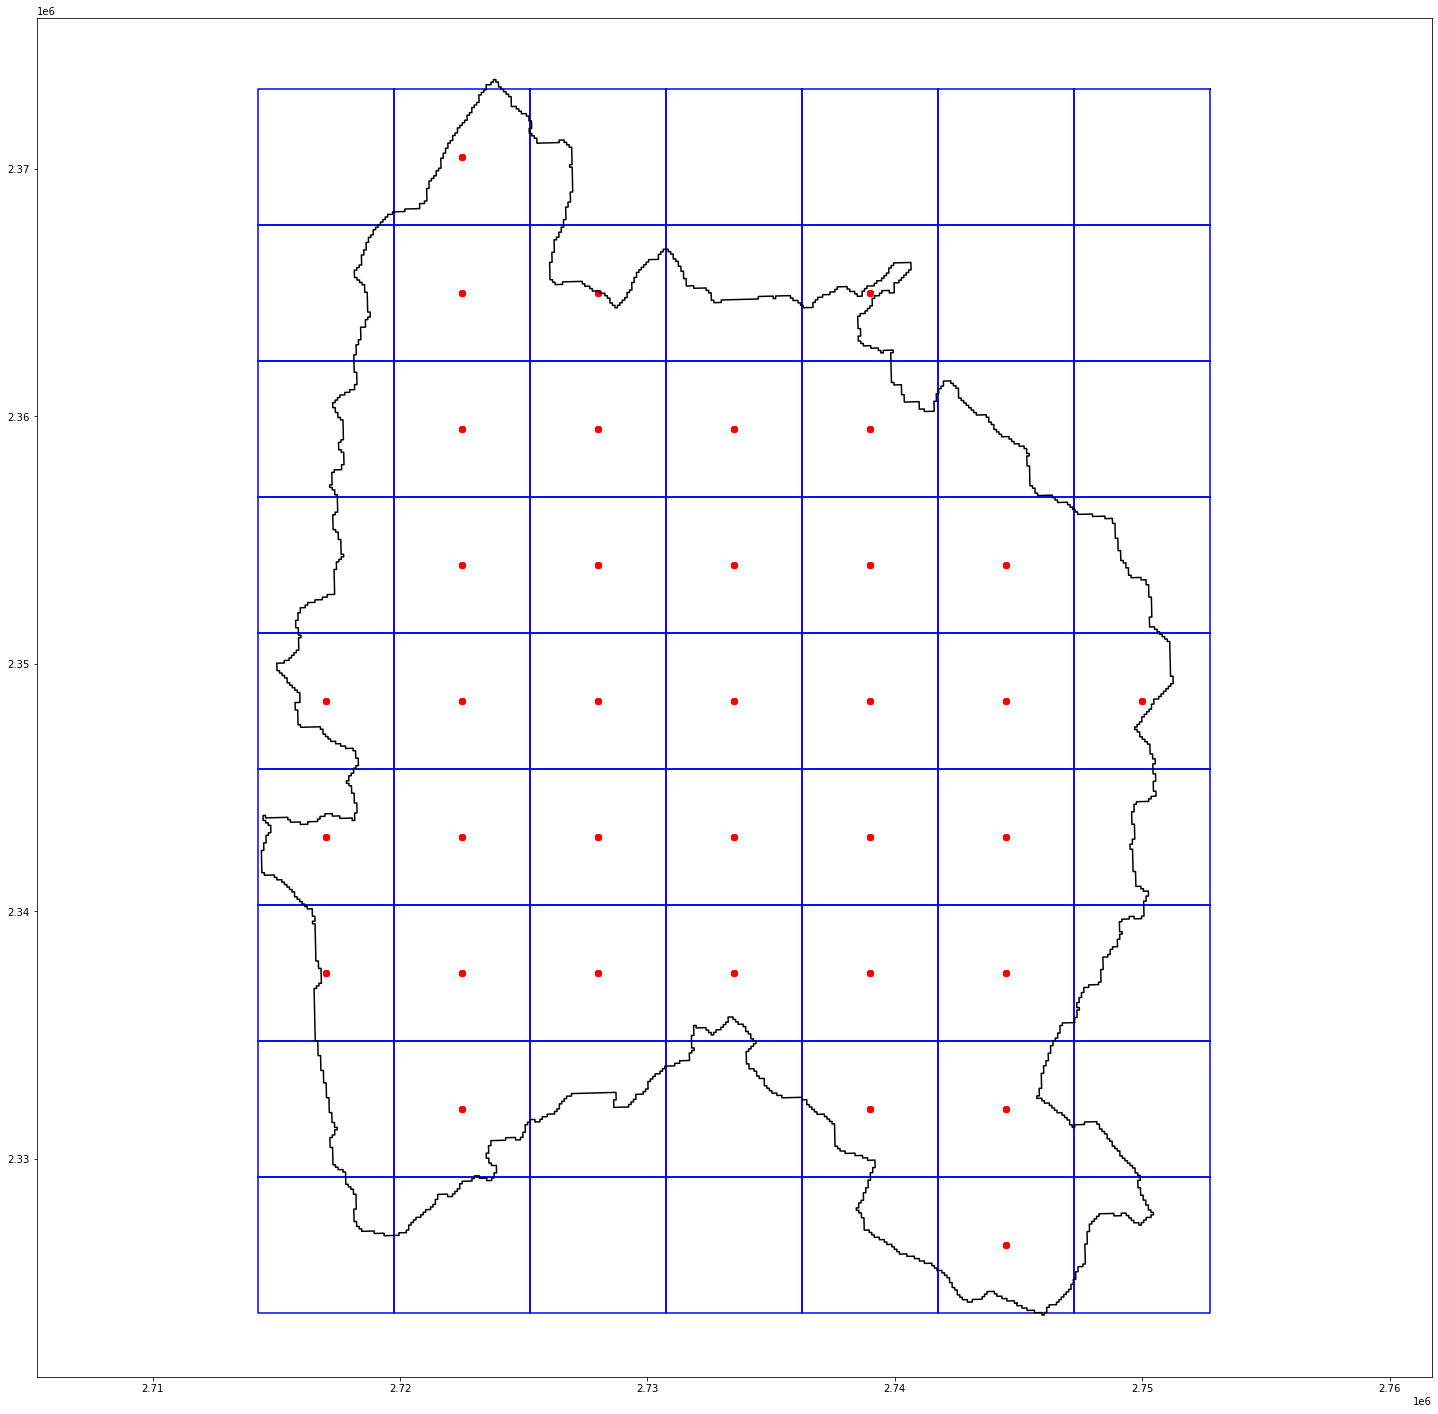

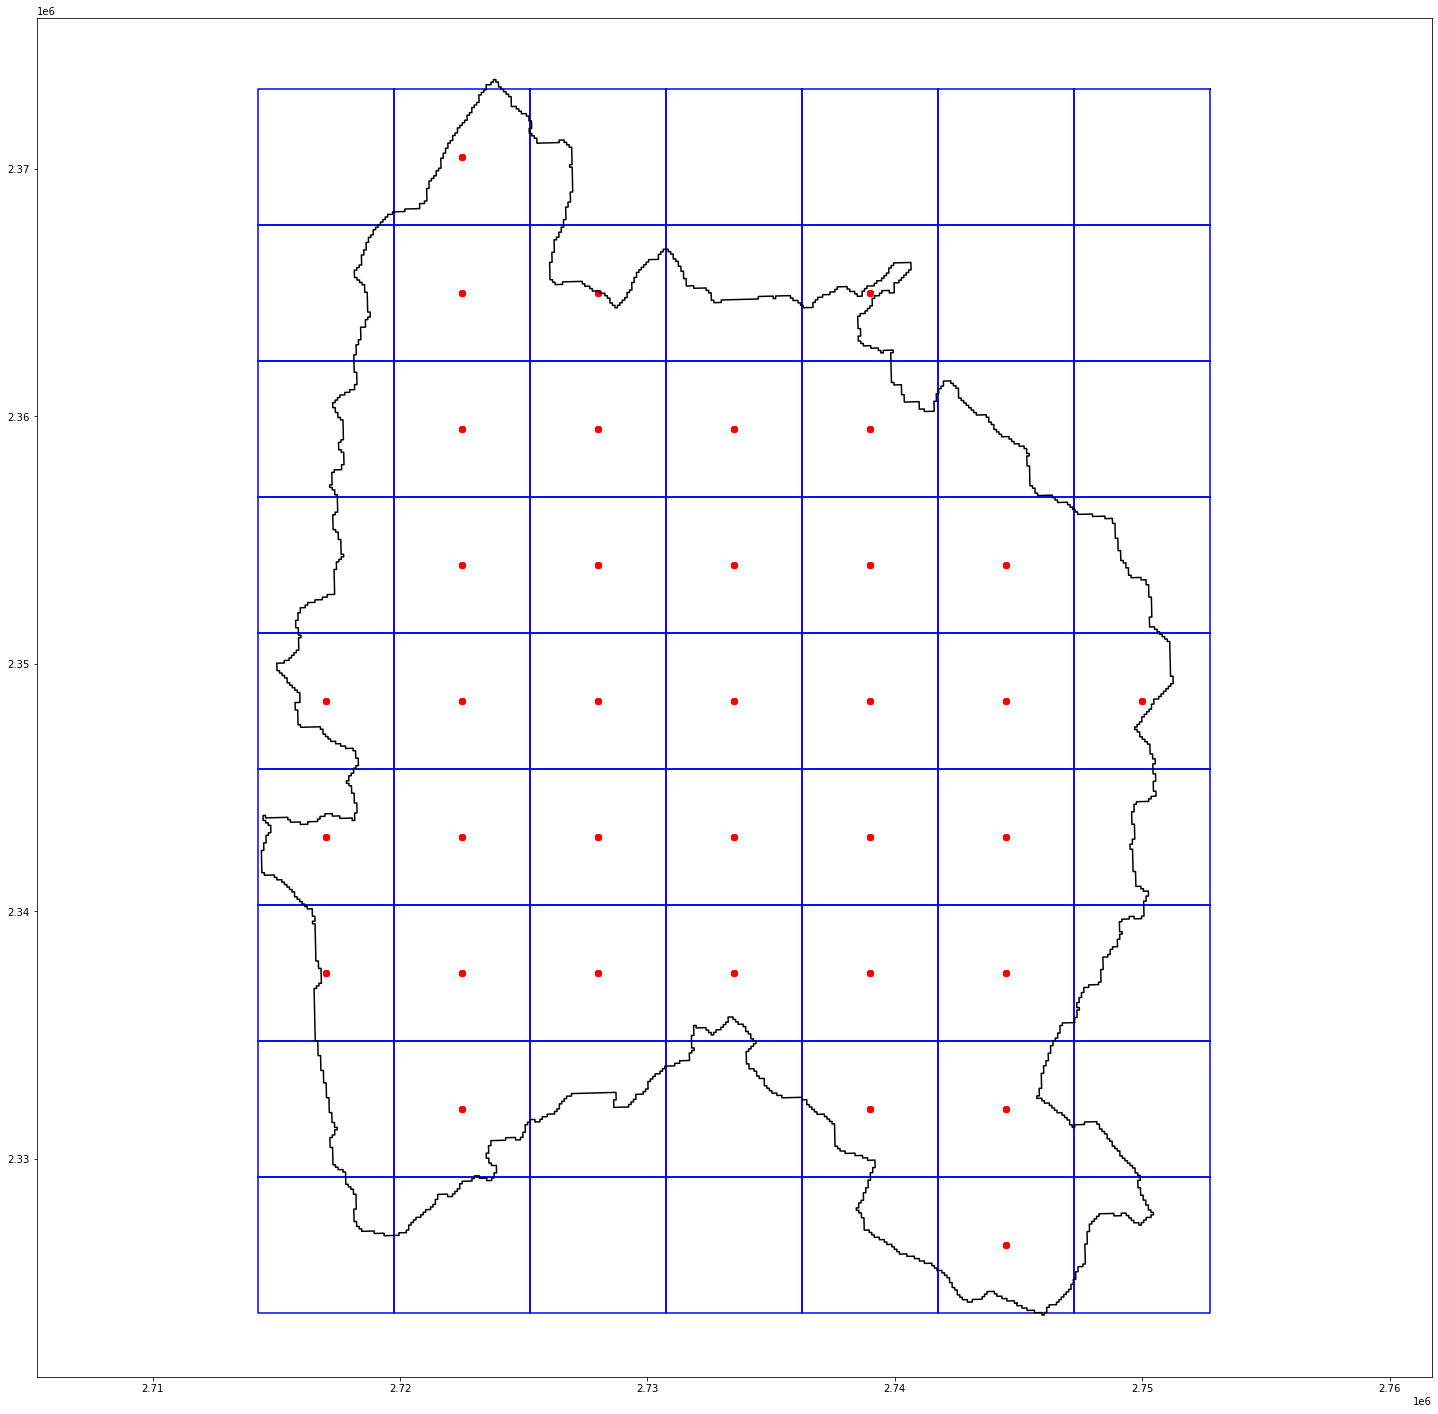

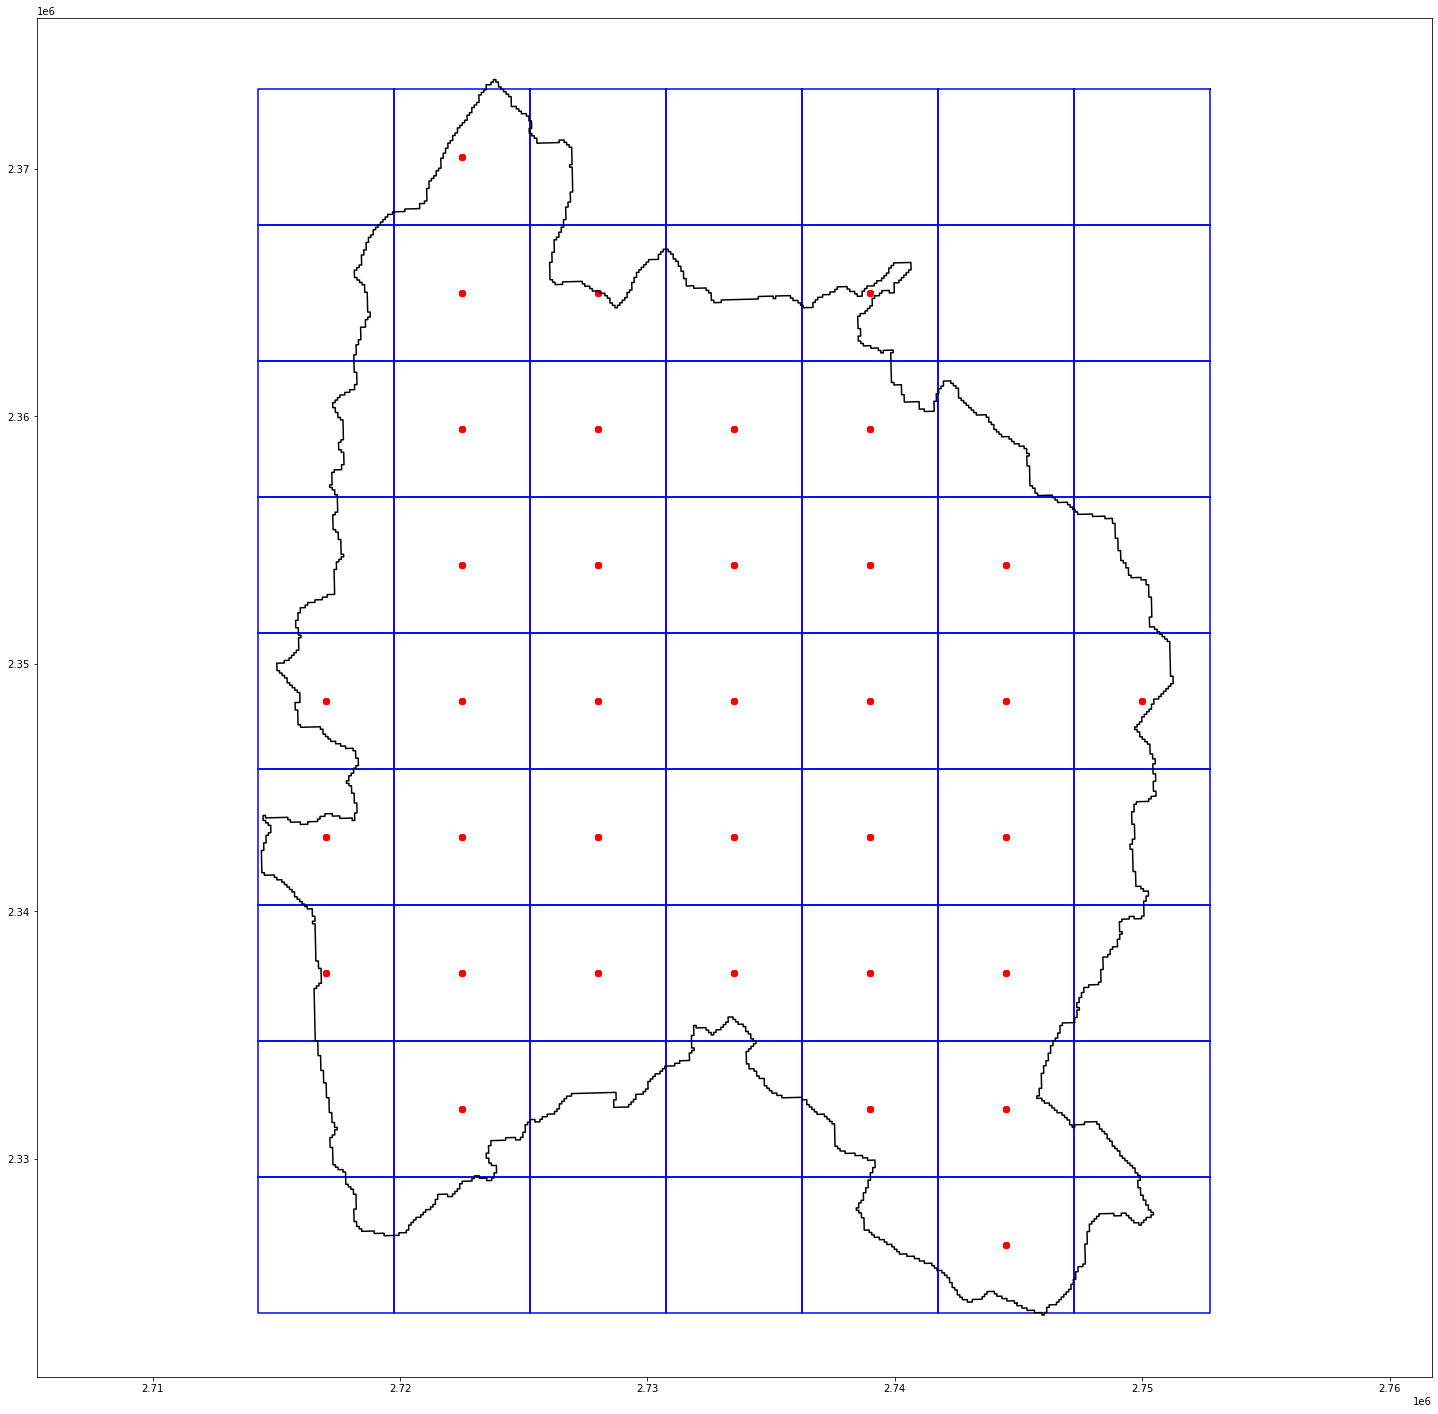

Error in callback <function flush_figures at 0x0000023D7085CD30> (for post_execute):


KeyboardInterrupt: 

In [111]:
swe=[]
c=0
for i in filenames:
    support=readnetcdf_in_shp_db((mypath+i), STAT_CODE,plot=True)
    swe.append(xarray2df(support.resample(time='1d').sum(skipna=False),'S', 'swe_tot'))
    runoff.append(xarray2df(support.resample(time='1d').sum(skipna=False),'R', 'runoff'))
swe=pd.concat(swe).dropna(axis=1,how='all')

In [115]:
# Concatenate and save
catchment_name='DROME_SAILLANS.csv'
daily_input = pd.concat([runoff, t2m, tp, pet,s,r], axis=1, join='inner')
#daily_input = pd.concat([daily_input,swe.loc[~swe.index.duplicated(keep='first')]], axis=1, join='inner')

path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'+catchment_name

In [117]:
#save into a csv file.
# if file does not exist write header 
if not os.path.isfile(path):
   daily_input.to_csv(path)
else: # else print the problem
   print('file already exists')